# Imports

In [1]:
import time
import json
import os
import pickle


import pandas as pd
import numpy as np
import sklearn 

from sklearn.preprocessing import StandardScaler

import torch
print(torch.__version__)  # Should print a compatible version
print(torch.cuda.is_available())

import tsai
from tsai.basics import*


import matplotlib.pyplot as plt
%matplotlib inline

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.tuner import Tuner

import optuna
import joblib
# import plotly
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2.2.2+cu121
True


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Utils

In [3]:
def get_test_windows(test, history_horizon): 
    
    
    windows = [test.iloc[: i+history_horizon] for i in range(len(test) - history_horizon+1)]

    return windows

In [4]:
class MSE(MultiHorizonMetric):
    """
    Mean Squared Error

    Defined as ``(y_pred - target)**2``
    """



    def loss(self, y_pred, target):
        loss = (self.to_prediction(y_pred) - target)**2
        return loss




In [5]:
 def get_test_loader(window, train, train_dataset, history_horizon_size): 

    window = window.copy()
    window["time_idx"]= range(train["time_idx"].max() + 1, train["time_idx"].max() + 1 + len(window))
    train_plus_window = pd.concat([train, window], ignore_index=True).fillna(0.0)

    
    test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        train_plus_window, 
                                        predict=True, 
                                        stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=8)

    return test_dataloader


In [6]:
def get_total_loss(model, test, train, train_dataset, history_horizon):

    test_windows = get_test_windows(test, history_horizon)

    window_losses_mape = []
    window_losses_smape = []
    window_losses_mae = []
    window_losses_rmse = []

    
    for window in tqdm((test_windows), total=len(test_windows), desc = 'Window'):
        window_loader = get_test_loader(window, train, train_dataset, history_horizon) #gets the window loader for a given idx
        window_preds = model.predict(window_loader, return_y=True) #inference for that window 
        
        window_loss_mape = MAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mape = window_loss_mape.item() #item to get the float from tensor 
        window_losses_mape.append(window_loss_mape) #appending to master list 

        window_loss_smape = SMAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_smape = window_loss_smape.item() #item to get the float from tensor 
        window_losses_smape.append(window_loss_smape) #appending to master list 

        window_loss_mae = MAE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mae = window_loss_mae.item() #item to get the float from tensor 
        window_losses_mae.append(window_loss_mae) #appending to master list 

        window_loss_rmse = RMSE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_rmse = window_loss_rmse.item() #item to get the float from tensor 
        window_losses_rmse.append(window_loss_rmse) #appending to master list 

    mean_loss_mape= np.mean(window_losses_mape)
    mean_loss_smape= np.mean(window_losses_smape)
    mean_loss_mae= np.mean(window_losses_mae)
    mean_loss_rmse= np.mean(window_losses_rmse)#return the mean lsos 

    print(f"Mean Losses Across Windows:")
    print(f"  - Mean MAPE: {mean_loss_mape:.4f}")
    print(f"  - Mean SMAPE: {mean_loss_smape:.4f}")
    print(f"  - Mean MAE: {mean_loss_mae:.4f}")
    print(f"  - Mean RMSE: {mean_loss_rmse:.4f}")

    
    return window_losses_mape, window_losses_smape, window_losses_mae, window_losses_rmse


        

    

    

In [7]:
def get_first_preds(model, test, train, train_dataset, history_horizon):

    test_windows = get_test_windows(test, history_horizon)

    first_preds = []
    
    for window_idx, window in tqdm(enumerate((test_windows)), total=len(test_windows), desc = 'Window'):
        window_loader = get_test_loader(window, train, train_dataset, history_horizon) #gets the window loader for a given idx
        window_preds = model.predict(window_loader, return_y=True) #inference for that window 
        window_first = window_preds.output[0][0].item()
        first_preds.append(window_first)
        if window_idx == len(test_windows) - 1: 
            first_preds.extend([item.item() for item in (window_preds.output[0][1:])])




    return first_preds 

        

    

    

In [8]:
def get_all_plots(start, end, step, model, test, train, train_dataset, history_horizon):

    test_windows = get_test_windows(test, history_horizon)
    
    for i in range(start, end, step):
            window = test_windows[i]
            window_loader = get_test_loader(window, train, train_dataset, history_horizon)
            window_predictions = model.predict(window_loader, mode="raw", return_x=True)
            tft.plot_prediction(window_predictions.x, window_predictions.output, idx=0, show_future_observed=True)
            plt.show()
            print(f'Plot for Window {i}')

        
    interpretation = model.interpret_output(window_predictions.output, reduction="sum")
    model.plot_interpretation(interpretation)
    plt.show()
        

    

    

# Data Loading

In [2]:

master_df = pd.read_csv("../Outputs/Data_Master.csv")

# EDA

In [9]:
master_df.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'],
      dtype='object')

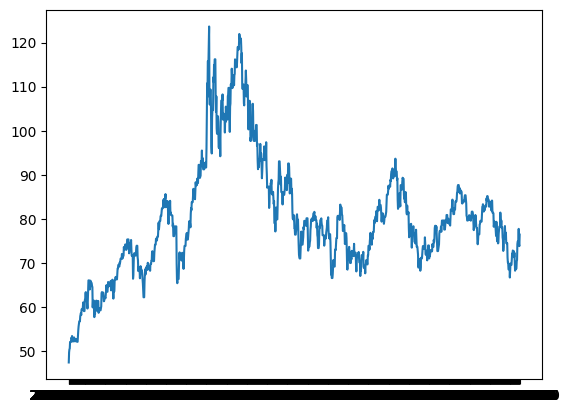

In [10]:
plt.plot(master_df['Date'], master_df['crude'])

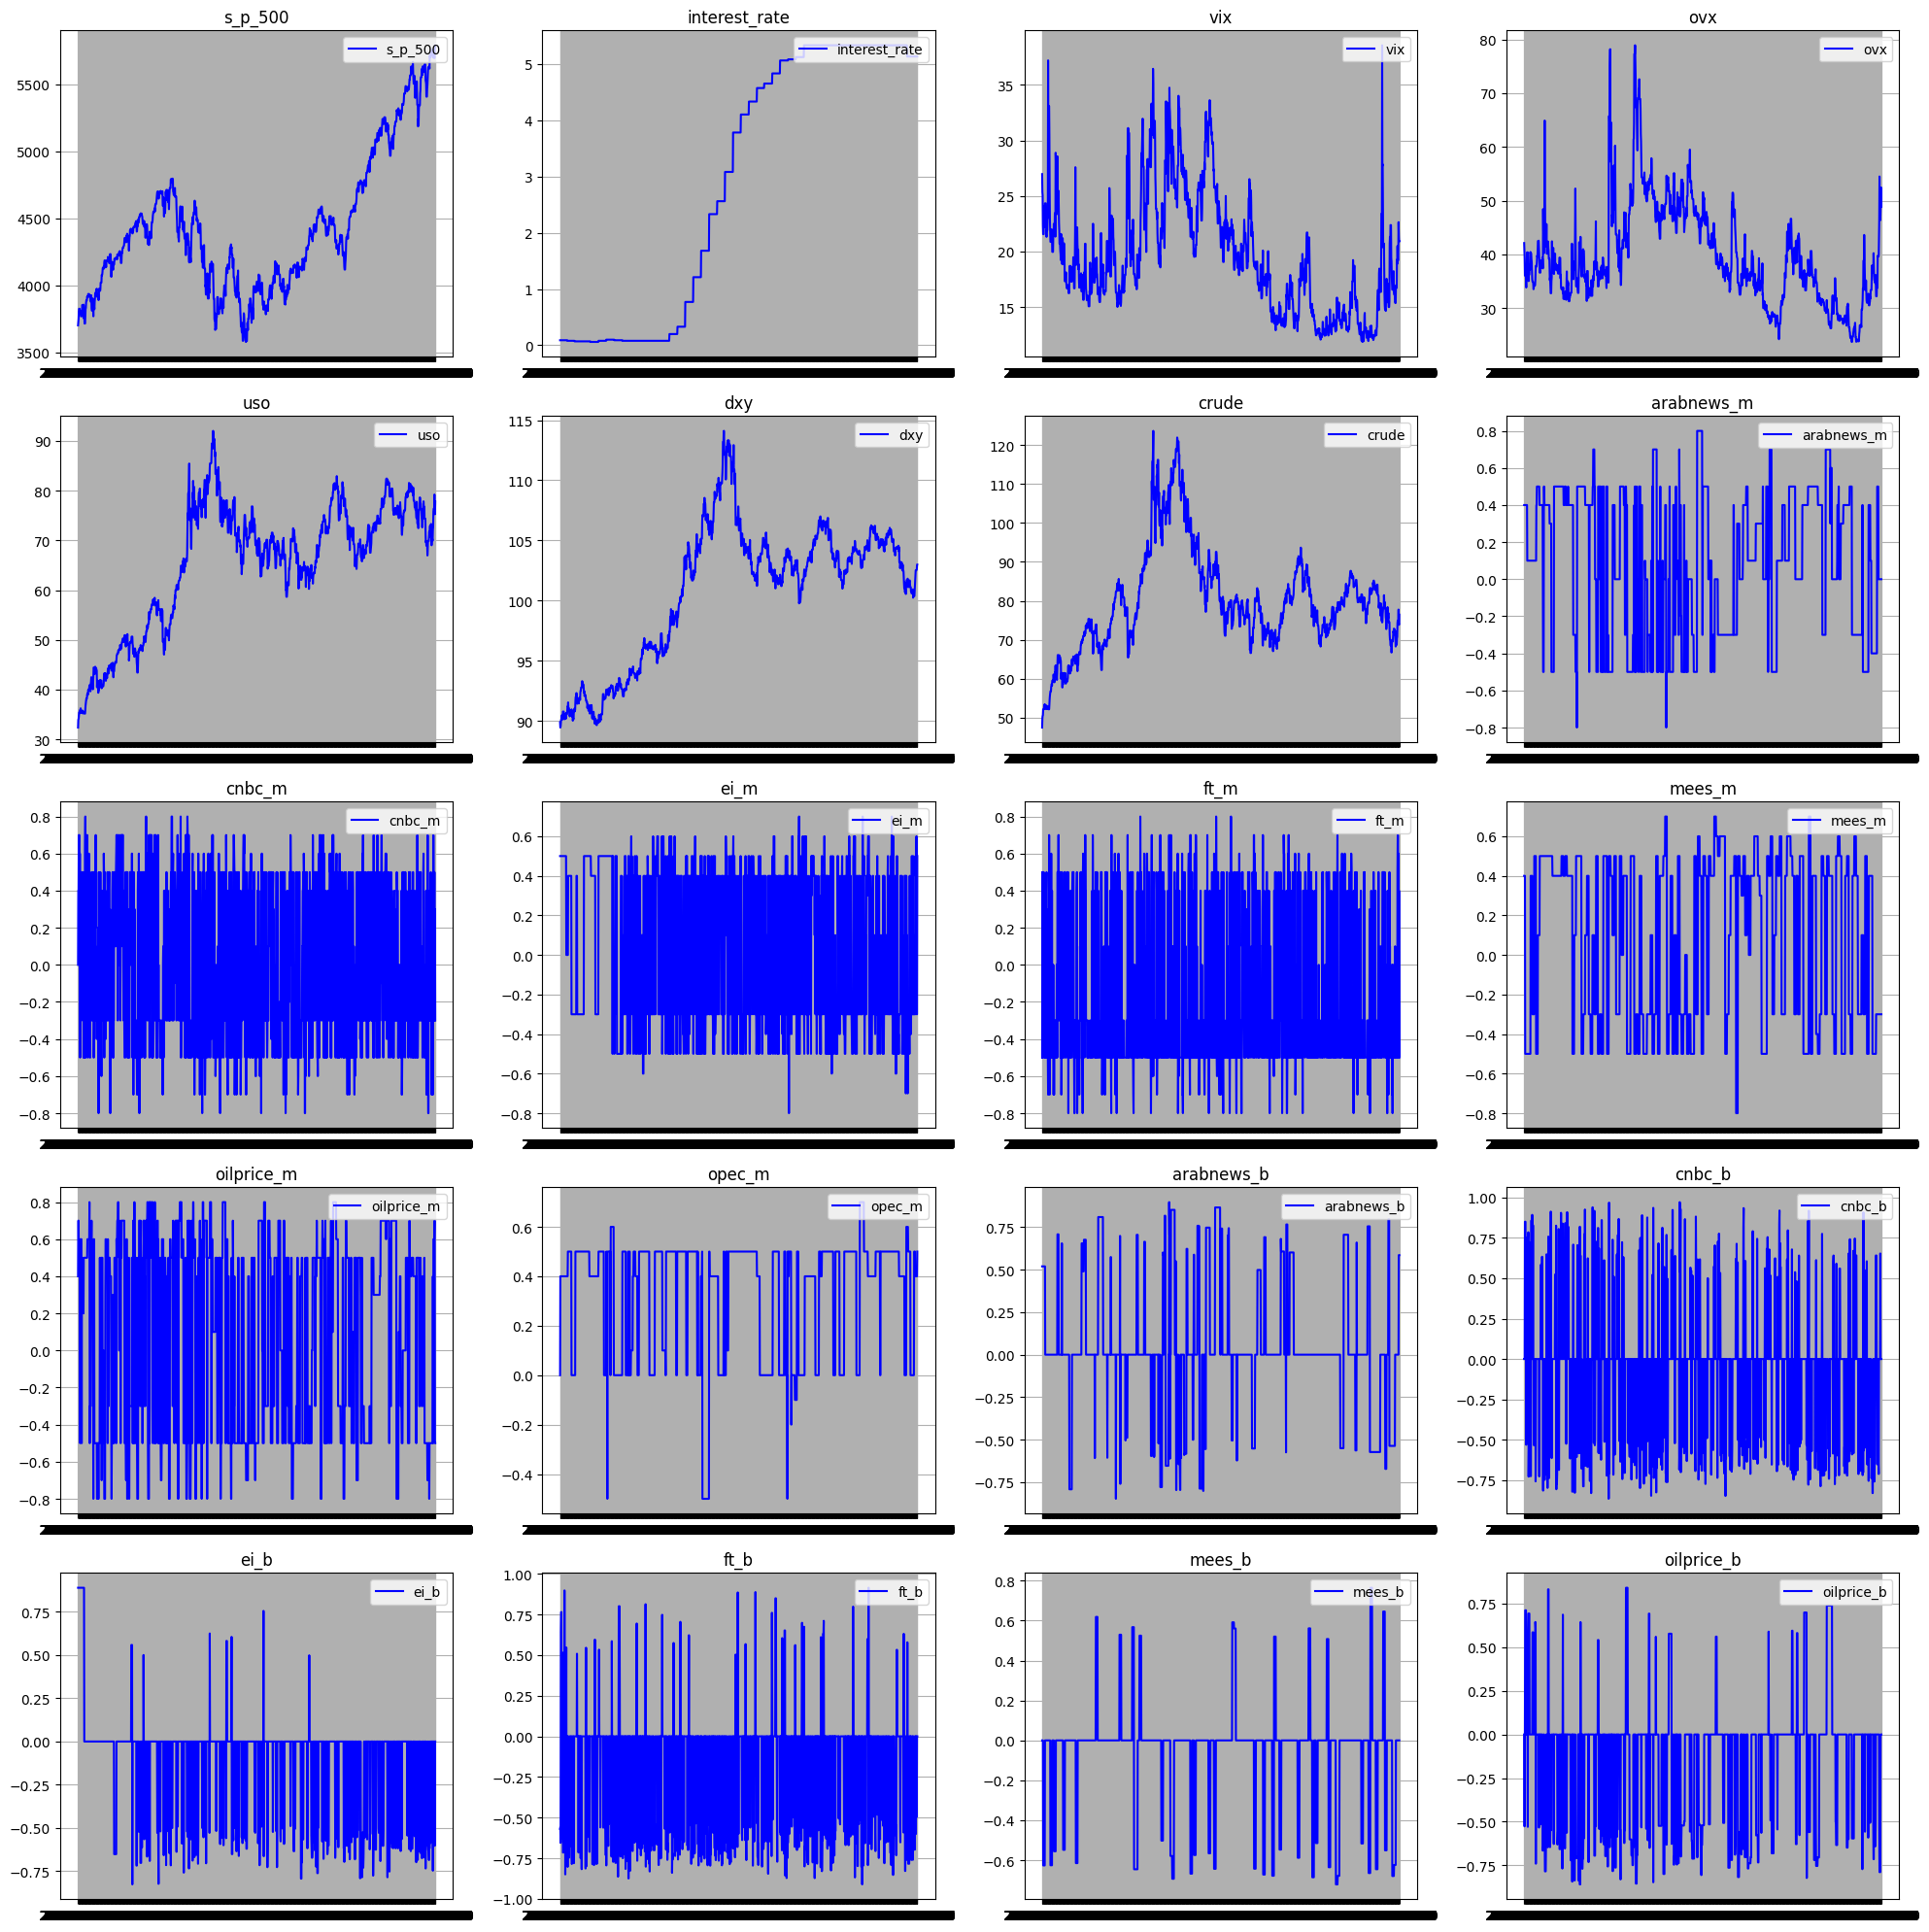

In [14]:
import matplotlib.pyplot as plt
import math

# List of variables to plot (excluding 'Date')
variables = [
    's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
    'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
    'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
    'oilprice_b'
]

# Number of variables and layout configuration
num_vars = len(variables)
plots_per_row = 4
num_rows = math.ceil(num_vars / plots_per_row)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, num_rows * 4))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    axes[i].plot(master_df['Date'], master_df[var], label=var, color='blue')
    axes[i].set_title(var)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Data Prep for Modelling

In [9]:
CALENDAR_CYCLES= {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [10]:
def add_cyclical_calendar_features(df: pd.DataFrame, date_col: str, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features based on a date column."""
    
    if isinstance(features, str):
        features = [features]

    # Ensure the date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"

        if feat == "week":
            # Use ISO calendar week
            values = df[date_col].dt.isocalendar().week
        else:
            # For other features (weekday, month), use .dt accessor
            values = getattr(df[date_col].dt, feat)

        # Apply cyclical encoding
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df


In [11]:
master_df_processed = add_cyclical_calendar_features(master_df, 'Date', features=["weekday", "week", 'month'])
master_df_processed

Date  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0    2021-01-04  3700.65           0.09  26.97  42.12  32.38   89.87  47.47   
1    2021-01-05  3726.86           0.09  25.34  40.39  33.94   89.44  49.78   
2    2021-01-06  3748.14           0.09  25.07  39.31  34.11   89.53  50.45   
3    2021-01-07  3803.79           0.09  22.37  36.06  34.53   89.83  50.63   
4    2021-01-08  3824.68           0.09  21.56  36.65  35.43   90.10  52.14   
...         ...      ...            ...    ...    ...    ...     ...    ...   
1371 2024-10-06  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
1372 2024-10-07  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
1373 2024-10-08  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
1374 2024-10-09  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
1375 2024-10-10  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

      arabnews_m  cnbc_m  ...      ei_b      ft_b    mees_b  oilprice_b  \
0            0.4     0.0  ...  0.889924 -0.569241  0.000000    0.000000   
1            0.4     0.4  ...  0.889924 -0.560321  0.000000   -0.526396   
2            0.4     0.4  ...  0.889924 -0.654790  0.000000   -0.526396   
3            0.4     0.7  ...  0.889924  0.644426  0.000000    0.000000   
4            0.4     0.7  ...  0.889924  0.764327 -0.626426    0.711697   
...          ...     ...  ...       ...       ...       ...         ...   
1371         0.0     0.0  ...  0.000000  0.000000  0.000000   -0.788622   
1372         0.0     0.5  ...  0.000000  0.000000  0.000000    0.000000   
1373         0.0    -0.3  ... -0.603633 -0.496074  0.000000    0.000000   
1374         0.0     0.3  ...  0.000000  0.000000  0.000000    0.000000   
1375         0.0    -0.3  ...  0.000000  0.000000  0.000000    0.000000   

      weekday_sin  weekday_cos  week_sin  week_cos  month_sin  month_cos  
0        0.000000     1.000000  0.120537  0.992709   0.500000   0.866025  
1        0.781831     0.623490  0.120537  0.992709   0.500000   0.866025  
2        0.974928    -0.222521  0.120537  0.992709   0.500000   0.866025  
3        0.433884    -0.900969  0.120537  0.992709   0.500000   0.866025  
4       -0.433884    -0.900969  0.120537  0.992709   0.500000   0.866025  
...           ...          ...       ...       ...        ...        ...  
1371    -0.781831     0.623490 -0.992709  0.120537  -0.866025   0.500000  
1372     0.000000     1.000000 -0.970942  0.239316  -0.866025   0.500000  
1373     0.781831     0.623490 -0.970942  0.239316  -0.866025   0.500000  
1374     0.974928    -0.222521 -0.970942  0.239316  -0.866025   0.500000  
1375     0.433884    -0.900969 -0.970942  0.239316  -0.866025   0.500000  

[1376 rows x 27 columns]

In [16]:
master_df_processed.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [12]:
# scaler = StandardScaler()
master_df_processed = master_df_processed[['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'month_sin', 'month_cos']]

In [19]:
# master_df_processed["weekend"] = (master_df_processed['Date'].dt.dayofweek > 4).astype(int)

## Train-Val-Test Splits

In [13]:
split = round(len(master_df_processed)*0.8)
print(split)

train = master_df_processed.iloc[: split]
test = master_df_processed.iloc[split:]

# test_dates = test[['Date']]
test.shape

1101


(275, 20)

In [14]:
train= train.reset_index()
train= (train.merge((train[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)


test= test.reset_index()
test= (test.merge((test[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)



In [15]:
print(train.shape)
print(test.shape)

(1101, 21)
(275, 21)


In [16]:
constant_tr= [1 for item in train['vix']]
train['constant'] = constant_tr

constant_te= [1 for item in test['vix']]
test['constant'] = constant_te

# Optuna Large Model

## Runs

In [31]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 15, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 8, 16, step=4),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16), 
              'max_encoder_length': trial.suggest_int('max_encoder_length', 32, 128, step = 32 )
              }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [32]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 96 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
                                    'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
                                    'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [ ]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_large_large_tuning', 
                            storage='sqlite:///tft_large_large_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning

for i in range(10): 
    study.optimize(objective, n_trials=10)
    joblib.dump(study, "tft_large_large_tuning.pkl")

[I 2024-12-14 15:57:06,826] Using an existing study with name 'tft_large_large_tuning' instead of creating a new one.


Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 12.08it/s, v_num=5.48e+7, train_loss_step=0.114]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s, v_num=5.48e+7, train_loss_step=0.0889, val_loss=0.118, train_loss_epoch=0.115]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s, v_num=5.48e+7, train_loss_step=0.091, val_loss=0.102, train_loss_epoch=0.0983] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:00<00:00,  6.62it/s, v_num=5.48e+7, train_loss_step=0.088, val_loss=0.0925, train_loss_epoch=0.0912] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s, v_num=5.48e+7, train_loss_step=0.0881, val_loss=0.0853, train_loss_epoch=0.0876]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s, v_num=5.48e+7, train_loss_step=0.090, val_

[I 2024-12-14 15:57:33,534] Trial 21 finished with value: 23.001680374145508 and parameters: {'epochs': 15, 'learning_rate': 0.001556452074072031, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 80, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.31%
    MAPE  (Mean Absolute Percentage Error):          5.40%
    RMSE  (Root Mean Squared Error):                4.80
    MAE   (Mean Absolute Error):                    4.13
    MSE   (Mean Squared Error):                    23.00
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 12.86it/s, v_num=5.48e+7, train_loss_step=0.0896]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, v_num=5.48e+7, train_loss_step=0.0865, val_loss=0.103, train_loss_epoch=0.0938]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s, v_num=5.48e+7, train_loss_step=0.0777, val_loss=0.097, train_loss_epoch=0.0845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s, v_num=5.48e+7, train_loss_step=0.0726, val_loss=

[I 2024-12-14 15:58:00,611] Trial 22 finished with value: 35.0155143737793 and parameters: {'epochs': 15, 'learning_rate': 0.0014009085649399908, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 64, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.81%
    MAPE  (Mean Absolute Percentage Error):          6.91%
    RMSE  (Root Mean Squared Error):                5.92
    MAE   (Mean Absolute Error):                    5.31
    MSE   (Mean Squared Error):                    35.02
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, v_num=5.48e+7, train_loss_step=0.099] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s, v_num=5.48e+7, train_loss_step=0.0992, val_loss=0.110, train_loss_epoch=0.0997]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, v_num=5.48e+7, train_loss_step=0.0884, val_loss=0.103, train_loss_epoch=0.0965]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s, v_num=5.48e+7, train_loss_step=0.0938, val_loss=

[I 2024-12-14 15:58:26,585] Trial 23 finished with value: 40.22330093383789 and parameters: {'epochs': 15, 'learning_rate': 0.0003076757617190692, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 2, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 96, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.22%
    MAPE  (Mean Absolute Percentage Error):          7.45%
    RMSE  (Root Mean Squared Error):                6.34
    MAE   (Mean Absolute Error):                    5.64
    MSE   (Mean Squared Error):                    40.22
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s, v_num=5.48e+7, train_loss_step=0.0759]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s, v_num=5.48e+7, train_loss_step=0.071, val_loss=0.0608, train_loss_epoch=0.0884] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, v_num=5.48e+7, train_loss_step=0.0684, val_loss=0.0626, train_loss_epoch=0.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s, v_num=5.48e+7, train_loss_step=0.0676, val_loss

[I 2024-12-14 15:58:52,078] Trial 24 finished with value: 46.39494705200195 and parameters: {'epochs': 15, 'learning_rate': 0.0034220459206632716, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.75%
    MAPE  (Mean Absolute Percentage Error):          7.10%
    RMSE  (Root Mean Squared Error):                6.81
    MAE   (Mean Absolute Error):                    5.51
    MSE   (Mean Squared Error):                    46.39
    
Number of parameters in network: 19.0k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.04it/s, v_num=5.48e+7, train_loss_step=7.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  8.93it/s, v_num=5.48e+7, train_loss_step=5.390, val_loss=6.140, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s, v_num=5.48e+7, train_loss_step=4.430, val_loss=5.780, train_loss_epoch=6.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  8.93it/s, v_num=5.48e+7, train_loss_step=4.850, val_los

[I 2024-12-14 15:59:21,659] Trial 25 finished with value: 107.16717529296875 and parameters: {'epochs': 15, 'learning_rate': 0.003029349830053254, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 2, 'dropout': 0.1, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 11.48%
    MAPE  (Mean Absolute Percentage Error):          12.34%
    RMSE  (Root Mean Squared Error):                10.35
    MAE   (Mean Absolute Error):                    9.42
    MSE   (Mean Squared Error):                    107.17
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 14.10it/s, v_num=5.48e+7, train_loss_step=0.0848]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  7.71it/s, v_num=5.48e+7, train_loss_step=0.0825, val_loss=0.127, train_loss_epoch=0.0871]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:00<00:00,  8.03it/s, v_num=5.48e+7, train_loss_step=0.0791, val_loss=0.123, train_loss_epoch=0.0823]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  7.68it/s, v_num=5.48e+7, train_loss_step=0.0715, val_l

[I 2024-12-14 15:59:48,680] Trial 26 finished with value: 88.54010009765625 and parameters: {'epochs': 15, 'learning_rate': 0.0005902472373092007, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 64, 'max_encoder_length': 32}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.37%
    MAPE  (Mean Absolute Percentage Error):          11.14%
    RMSE  (Root Mean Squared Error):                9.41
    MAE   (Mean Absolute Error):                    8.26
    MSE   (Mean Squared Error):                    88.54
    
Number of parameters in network: 25.9k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=5.48e+7, train_loss_step=0.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s, v_num=5.48e+7, train_loss_step=0.107, val_loss=0.0958, train_loss_epoch=0.124]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, v_num=5.48e+7, train_loss_step=0.0962, val_loss=0.0787, train_loss_epoch=0.107]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=5.48e+7, train_loss_step=0.0893, val_loss=

[I 2024-12-14 16:00:11,023] Trial 27 finished with value: 32.18977355957031 and parameters: {'epochs': 10, 'learning_rate': 0.0010327599005600535, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 1, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.61%
    MAPE  (Mean Absolute Percentage Error):          5.45%
    RMSE  (Root Mean Squared Error):                5.67
    MAE   (Mean Absolute Error):                    4.39
    MSE   (Mean Squared Error):                    32.19
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 10.72it/s, v_num=5.48e+7, train_loss_step=7.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s, v_num=5.48e+7, train_loss_step=6.200, val_loss=5.910, train_loss_epoch=7.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:00<00:00,  6.66it/s, v_num=5.48e+7, train_loss_step=5.470, val_loss=5.460, train_loss_epoch=7.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s, v_num=5.48e+7, train_loss_step=4.900, val_loss=5.170,

[I 2024-12-14 16:00:37,188] Trial 28 finished with value: 126.5512466430664 and parameters: {'epochs': 15, 'learning_rate': 0.010579623017612998, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 2, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.8, 'batch_size': 80, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 12.87%
    MAPE  (Mean Absolute Percentage Error):          13.88%
    RMSE  (Root Mean Squared Error):                11.25
    MAE   (Mean Absolute Error):                    10.60
    MSE   (Mean Squared Error):                    126.55
    
Number of parameters in network: 30.9k
Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  9.97it/s, v_num=5.48e+7, train_loss_step=6.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s, v_num=5.48e+7, train_loss_step=5.370, val_loss=5.080, train_loss_epoch=7.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s, v_num=5.48e+7, train_loss_step=5.370, val_loss=6.590, train_loss_epoch=5.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s, v_num=5.48e+7, train_loss_step=4.910, va

[I 2024-12-14 16:01:11,662] Trial 29 finished with value: 20.152877807617188 and parameters: {'epochs': 15, 'learning_rate': 0.021379893862522495, 'hidden_size': 12, 'lstm_layers': 3, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.08%
    MAPE  (Mean Absolute Percentage Error):          5.25%
    RMSE  (Root Mean Squared Error):                4.49
    MAE   (Mean Absolute Error):                    3.94
    MSE   (Mean Squared Error):                    20.15
    
Number of parameters in network: 44.3k
Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, v_num=5.48e+7, train_loss_step=8.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s, v_num=5.48e+7, train_loss_step=5.050, val_loss=5.590, train_loss_epoch=9.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, v_num=5.48e+7, train_loss_step=5.030, val_loss=4.460, train_loss_epoch=7.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s, v_num=5.48e+7, train_loss_step=4.470, val_los

[I 2024-12-14 16:01:46,665] Trial 30 finished with value: 41.989681243896484 and parameters: {'epochs': 15, 'learning_rate': 0.06087949910815731, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.23%
    MAPE  (Mean Absolute Percentage Error):          7.58%
    RMSE  (Root Mean Squared Error):                6.48
    MAE   (Mean Absolute Error):                    5.73
    MSE   (Mean Squared Error):                    41.99
    
Number of parameters in network: 30.9k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.93it/s, v_num=5.48e+7, train_loss_step=6.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.10it/s, v_num=5.48e+7, train_loss_step=4.780, val_loss=5.570, train_loss_epoch=7.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s, v_num=5.48e+7, train_loss_step=4.640, val_loss=6.510, train_loss_epoch=5.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s, v_num=5.48e+7, train_loss_step=4.040, val_loss=4.750,

[I 2024-12-14 16:02:19,320] Trial 31 finished with value: 67.7377700805664 and parameters: {'epochs': 15, 'learning_rate': 0.019577855679952502, 'hidden_size': 12, 'lstm_layers': 3, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 64, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.35%
    MAPE  (Mean Absolute Percentage Error):          9.91%
    RMSE  (Root Mean Squared Error):                8.23
    MAE   (Mean Absolute Error):                    7.52
    MSE   (Mean Squared Error):                    67.74
    
Number of parameters in network: 19.1k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.52it/s, v_num=5.48e+7, train_loss_step=5.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s, v_num=5.48e+7, train_loss_step=4.590, val_loss=4.740, train_loss_epoch=6.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s, v_num=5.48e+7, train_loss_step=4.710, val_loss=4.610, train_loss_epoch=4.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  8.96it/s, v_num=5.48e+7, train_loss_step=3.440, val_los

[I 2024-12-14 16:02:48,431] Trial 32 finished with value: 23.797088623046875 and parameters: {'epochs': 15, 'learning_rate': 0.01700748931321918, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.60%
    MAPE  (Mean Absolute Percentage Error):          5.74%
    RMSE  (Root Mean Squared Error):                4.88
    MAE   (Mean Absolute Error):                    4.35
    MSE   (Mean Squared Error):                    23.80
    
Number of parameters in network: 28.4k
Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s, v_num=5.48e+7, train_loss_step=11.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s, v_num=5.48e+7, train_loss_step=10.50, val_loss=8.550, train_loss_epoch=12.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s, v_num=5.48e+7, train_loss_step=8.860, val_loss=8.020, train_loss_epoch=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s, v_num=5.48e+7, train_loss_step=8.460, val_loss=8.320,

[I 2024-12-14 16:03:21,185] Trial 33 finished with value: 146.38052368164062 and parameters: {'epochs': 15, 'learning_rate': 0.00207664445926331, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.5, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 13.63%
    MAPE  (Mean Absolute Percentage Error):          14.86%
    RMSE  (Root Mean Squared Error):                12.10
    MAE   (Mean Absolute Error):                    11.11
    MSE   (Mean Squared Error):                    146.38
    
Number of parameters in network: 33.4k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s, v_num=5.48e+7, train_loss_step=92.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, v_num=5.48e+7, train_loss_step=72.30, val_loss=54.20, train_loss_epoch=123.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, v_num=5.48e+7, train_loss_step=55.60, val_loss=53.60, train_loss_epoch=78.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, v_num=5.48e+7, train_loss_step=46.20, val_loss=4

[I 2024-12-14 16:03:54,325] Trial 34 finished with value: 28.71620750427246 and parameters: {'epochs': 15, 'learning_rate': 0.006716969035428914, 'hidden_size': 12, 'lstm_layers': 4, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.5, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.74%
    MAPE  (Mean Absolute Percentage Error):          5.72%
    RMSE  (Root Mean Squared Error):                5.36
    MAE   (Mean Absolute Error):                    4.49
    MSE   (Mean Squared Error):                    28.72
    
Number of parameters in network: 19.1k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s, v_num=5.48e+7, train_loss_step=6.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s, v_num=5.48e+7, train_loss_step=5.550, val_loss=10.10, train_loss_epoch=7.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s, v_num=5.48e+7, train_loss_step=5.760, val_loss=9.230, train_loss_epoch=6.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s, v_num=5.48e+7, train_loss_step=4.590, val_los

[I 2024-12-14 16:04:14,307] Trial 35 finished with value: 428.6622009277344 and parameters: {'epochs': 10, 'learning_rate': 0.030039560106118593, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 1, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 32}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 23.29%
    MAPE  (Mean Absolute Percentage Error):          26.62%
    RMSE  (Root Mean Squared Error):                20.70
    MAE   (Mean Absolute Error):                    20.19
    MSE   (Mean Squared Error):                    428.66
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s, v_num=5.48e+7, train_loss_step=0.0876]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s, v_num=5.48e+7, train_loss_step=0.0628, val_loss=0.0838, train_loss_epoch=0.0923]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, v_num=5.48e+7, train_loss_step=0.0598, val_loss=0.0911, train_loss_epoch=0.0725]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s, v_num=5.48e+7, train_loss_step=0.0565, va

[I 2024-12-14 16:04:39,987] Trial 36 finished with value: 296.3063049316406 and parameters: {'epochs': 15, 'learning_rate': 0.06672916882167809, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 96, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 18.17%
    MAPE  (Mean Absolute Percentage Error):          20.58%
    RMSE  (Root Mean Squared Error):                17.21
    MAE   (Mean Absolute Error):                    15.32
    MSE   (Mean Squared Error):                    296.31
    
Number of parameters in network: 40.3k
Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s, v_num=5.48e+7, train_loss_step=12.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  3.91it/s, v_num=5.48e+7, train_loss_step=10.70, val_loss=5.330, train_loss_epoch=12.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  3.69it/s, v_num=5.48e+7, train_loss_step=10.90, val_loss=4.140, train_loss_epoch=11.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s, v_num=5.48e+7, train_loss_step=9.500, val_loss=5

[I 2024-12-14 16:05:15,754] Trial 37 finished with value: 82.17818450927734 and parameters: {'epochs': 15, 'learning_rate': 0.00032784918440994354, 'hidden_size': 16, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.5, 'loss': 'RMSE', 'gradient_clip_val': 0.6, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.62%
    MAPE  (Mean Absolute Percentage Error):          9.97%
    RMSE  (Root Mean Squared Error):                9.07
    MAE   (Mean Absolute Error):                    7.97
    MSE   (Mean Squared Error):                    82.18
    
Number of parameters in network: 20.2k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, v_num=5.48e+7, train_loss_step=11.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=5.48e+7, train_loss_step=10.80, val_loss=10.70, train_loss_epoch=11.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=5.48e+7, train_loss_step=9.190, val_loss=8.400, train_loss_epoch=10.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=8.350, val_loss=6.120

[I 2024-12-14 16:05:42,334] Trial 38 finished with value: 21.70770835876465 and parameters: {'epochs': 15, 'learning_rate': 0.0008681257858456333, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.9, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.34%
    MAPE  (Mean Absolute Percentage Error):          4.22%
    RMSE  (Root Mean Squared Error):                4.66
    MAE   (Mean Absolute Error):                    3.43
    MSE   (Mean Squared Error):                    21.71
    
Number of parameters in network: 33.3k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s, v_num=5.48e+7, train_loss_step=13.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, v_num=5.48e+7, train_loss_step=11.60, val_loss=8.910, train_loss_epoch=13.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, v_num=5.48e+7, train_loss_step=9.790, val_loss=7.260, train_loss_epoch=11.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, v_num=5.48e+7, train_loss_step=8.020, val_loss=6.090,

[I 2024-12-14 16:05:54,805] Trial 39 finished with value: 42.336002349853516 and parameters: {'epochs': 5, 'learning_rate': 0.0009465969511377589, 'hidden_size': 12, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.30000000000000004, 'loss': 'MAE', 'gradient_clip_val': 0.8, 'batch_size': 112, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.54%
    MAPE  (Mean Absolute Percentage Error):          6.31%
    RMSE  (Root Mean Squared Error):                6.51
    MAE   (Mean Absolute Error):                    5.10
    MSE   (Mean Squared Error):                    42.34
    
Number of parameters in network: 20.1k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s, v_num=5.48e+7, train_loss_step=9.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s, v_num=5.48e+7, train_loss_step=9.310, val_loss=7.310, train_loss_epoch=10.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s, v_num=5.48e+7, train_loss_step=9.830, val_loss=7.130, train_loss_epoch=9.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s, v_num=5.48e+7, train_loss_step=9.670, val_loss=6.980,

[I 2024-12-14 16:06:13,112] Trial 40 finished with value: 43.489620208740234 and parameters: {'epochs': 10, 'learning_rate': 0.000448532617631193, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.62%
    MAPE  (Mean Absolute Percentage Error):          7.79%
    RMSE  (Root Mean Squared Error):                6.59
    MAE   (Mean Absolute Error):                    5.96
    MSE   (Mean Squared Error):                    43.49
    
Number of parameters in network: 20.2k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s, v_num=5.48e+7, train_loss_step=8.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=5.48e+7, train_loss_step=8.280, val_loss=8.340, train_loss_epoch=8.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=5.48e+7, train_loss_step=8.260, val_loss=7.480, train_loss_epoch=8.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=5.48e+7, train_loss_step=8.910, val_loss=7.020,

[I 2024-12-14 16:06:38,888] Trial 41 finished with value: 38.34195327758789 and parameters: {'epochs': 15, 'learning_rate': 0.0010647287660231735, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.9, 'batch_size': 112, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.04%
    MAPE  (Mean Absolute Percentage Error):          7.28%
    RMSE  (Root Mean Squared Error):                6.19
    MAE   (Mean Absolute Error):                    5.49
    MSE   (Mean Squared Error):                    38.34
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 13.64it/s, v_num=5.48e+7, train_loss_step=10.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s, v_num=5.48e+7, train_loss_step=9.440, val_loss=7.990, train_loss_epoch=10.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s, v_num=5.48e+7, train_loss_step=9.790, val_loss=7.690, train_loss_epoch=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s, v_num=5.48e+7, train_loss_step=9.810, val_loss=7.400,

[I 2024-12-14 16:07:06,375] Trial 42 finished with value: 24.935386657714844 and parameters: {'epochs': 15, 'learning_rate': 0.00016490372446969042, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.30000000000000004, 'loss': 'MAE', 'gradient_clip_val': 1.0, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.52%
    MAPE  (Mean Absolute Percentage Error):          5.67%
    RMSE  (Root Mean Squared Error):                4.99
    MAE   (Mean Absolute Error):                    4.30
    MSE   (Mean Squared Error):                    24.94
    
Number of parameters in network: 20.2k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s, v_num=5.48e+7, train_loss_step=0.139]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=5.48e+7, train_loss_step=0.132, val_loss=0.0763, train_loss_epoch=0.142]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=5.48e+7, train_loss_step=0.115, val_loss=0.0671, train_loss_epoch=0.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=5.48e+7, train_loss_step=0.105, val_loss=0.06

[I 2024-12-14 16:07:33,254] Trial 43 finished with value: 104.61348724365234 and parameters: {'epochs': 15, 'learning_rate': 0.0006977822351249624, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.9, 'batch_size': 96, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 11.50%
    MAPE  (Mean Absolute Percentage Error):          10.68%
    RMSE  (Root Mean Squared Error):                10.23
    MAE   (Mean Absolute Error):                    8.63
    MSE   (Mean Squared Error):                    104.61
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s, v_num=5.48e+7, train_loss_step=0.0933]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:01<00:00, 10.53it/s, v_num=5.48e+7, train_loss_step=0.0864, val_loss=0.0805, train_loss_epoch=0.0929]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:01<00:00, 10.61it/s, v_num=5.48e+7, train_loss_step=0.0768, val_loss=0.0734, train_loss_epoch=0.085] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s, v_num=5.48e+7, train_loss_step=0.0

[I 2024-12-14 16:08:07,375] Trial 44 finished with value: 29.935930252075195 and parameters: {'epochs': 15, 'learning_rate': 0.001974150219293195, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.87%
    MAPE  (Mean Absolute Percentage Error):          6.11%
    RMSE  (Root Mean Squared Error):                5.47
    MAE   (Mean Absolute Error):                    4.62
    MSE   (Mean Squared Error):                    29.94
    
Number of parameters in network: 18.9k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s, v_num=5.48e+7, train_loss_step=97.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s, v_num=5.48e+7, train_loss_step=89.80, val_loss=38.30, train_loss_epoch=105.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s, v_num=5.48e+7, train_loss_step=89.10, val_loss=37.70, train_loss_epoch=90.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s, v_num=5.48e+7, train_loss_step=73.90, val_loss=36.40,

[I 2024-12-14 16:08:34,497] Trial 45 finished with value: 25.918466567993164 and parameters: {'epochs': 15, 'learning_rate': 0.00386868505757859, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.66%
    MAPE  (Mean Absolute Percentage Error):          4.51%
    RMSE  (Root Mean Squared Error):                5.09
    MAE   (Mean Absolute Error):                    3.68
    MSE   (Mean Squared Error):                    25.92
    
Number of parameters in network: 28.3k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.91it/s, v_num=5.48e+7, train_loss_step=7.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s, v_num=5.48e+7, train_loss_step=6.150, val_loss=5.870, train_loss_epoch=9.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s, v_num=5.48e+7, train_loss_step=5.670, val_loss=6.190, train_loss_epoch=6.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s, v_num=5.48e+7, train_loss_step=5.330, val_loss=7.090,

[I 2024-12-14 16:09:07,068] Trial 46 finished with value: 181.72906494140625 and parameters: {'epochs': 15, 'learning_rate': 0.015285177521665846, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 2, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 0.8, 'batch_size': 64, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 14.71%
    MAPE  (Mean Absolute Percentage Error):          16.08%
    RMSE  (Root Mean Squared Error):                13.48
    MAE   (Mean Absolute Error):                    12.44
    MSE   (Mean Squared Error):                    181.73
    
Number of parameters in network: 16.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.86it/s, v_num=5.48e+7, train_loss_step=6.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=7.290, val_loss=4.770, train_loss_epoch=8.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=5.48e+7, train_loss_step=5.970, val_loss=5.260, train_loss_epoch=7.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=6.030, val_loss=5

[I 2024-12-14 16:09:32,267] Trial 47 finished with value: 86.20136260986328 and parameters: {'epochs': 15, 'learning_rate': 0.007116785992816079, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.49%
    MAPE  (Mean Absolute Percentage Error):          10.15%
    RMSE  (Root Mean Squared Error):                9.28
    MAE   (Mean Absolute Error):                    7.89
    MSE   (Mean Squared Error):                    86.20
    
Number of parameters in network: 20.2k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.64it/s, v_num=5.48e+7, train_loss_step=0.095] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s, v_num=5.48e+7, train_loss_step=0.0885, val_loss=0.149, train_loss_epoch=0.0975]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.66it/s, v_num=5.48e+7, train_loss_step=0.0918, val_loss=0.140, train_loss_epoch=0.0924]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s, v_num=5.48e+7, train_loss_step=0.091, val_loss=

[I 2024-12-14 16:09:50,490] Trial 48 finished with value: 97.4393310546875 and parameters: {'epochs': 10, 'learning_rate': 0.0007787541332133659, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 80, 'max_encoder_length': 32}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.74%
    MAPE  (Mean Absolute Percentage Error):          11.58%
    RMSE  (Root Mean Squared Error):                9.87
    MAE   (Mean Absolute Error):                    8.57
    MSE   (Mean Squared Error):                    97.44
    
Number of parameters in network: 44.3k
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.26it/s, v_num=5.48e+7, train_loss_step=7.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s, v_num=5.48e+7, train_loss_step=5.270, val_loss=10.60, train_loss_epoch=7.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, v_num=5.48e+7, train_loss_step=6.500, val_loss=8.310, train_loss_epoch=6.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.83it/s, v_num=5.48e+7, train_loss_step=5.340, val_l

[I 2024-12-14 16:10:31,595] Trial 49 finished with value: 160.12205505371094 and parameters: {'epochs': 15, 'learning_rate': 0.0014865689585847398, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 3, 'dropout': 0.30000000000000004, 'loss': 'MAE', 'gradient_clip_val': 1.0, 'batch_size': 32, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 13.88%
    MAPE  (Mean Absolute Percentage Error):          15.19%
    RMSE  (Root Mean Squared Error):                12.65
    MAE   (Mean Absolute Error):                    11.46
    MSE   (Mean Squared Error):                    160.12
    
Number of parameters in network: 28.4k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s, v_num=5.48e+7, train_loss_step=0.0885]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s, v_num=5.48e+7, train_loss_step=0.0801, val_loss=0.0828, train_loss_epoch=0.0967]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=0.0715, val_loss=0.0721, train_loss_epoch=0.0837]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=0.0619, va

[I 2024-12-14 16:11:04,589] Trial 50 finished with value: 203.70127868652344 and parameters: {'epochs': 15, 'learning_rate': 0.004298726476271254, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 15.81%
    MAPE  (Mean Absolute Percentage Error):          17.36%
    RMSE  (Root Mean Squared Error):                14.27
    MAE   (Mean Absolute Error):                    13.40
    MSE   (Mean Squared Error):                    203.70
    
Number of parameters in network: 28.2k
Epoch 0: 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, v_num=5.48e+7, train_loss_step=0.0672]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s, v_num=5.48e+7, train_loss_step=0.0449, val_loss=0.0748, train_loss_epoch=0.0823]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s, v_num=5.48e+7, train_loss_step=0.0487, val_loss=0.0798, train_loss_epoch=0.0594]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s, v_num=5.48e+7, train_loss_step=0.

[I 2024-12-14 16:11:44,103] Trial 51 finished with value: 28.387802124023438 and parameters: {'epochs': 15, 'learning_rate': 0.010947281435291962, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 1.0, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.89%
    MAPE  (Mean Absolute Percentage Error):          6.12%
    RMSE  (Root Mean Squared Error):                5.33
    MAE   (Mean Absolute Error):                    4.61
    MSE   (Mean Squared Error):                    28.39
    
Number of parameters in network: 28.2k
Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s, v_num=5.48e+7, train_loss_step=0.0615]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s, v_num=5.48e+7, train_loss_step=0.0532, val_loss=0.0782, train_loss_epoch=0.0772]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s, v_num=5.48e+7, train_loss_step=0.0523, val_loss=0.0785, train_loss_epoch=0.0575]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s, v_num=5.48e+7, train_loss_step=0.0452,

[I 2024-12-14 16:12:19,136] Trial 52 finished with value: 53.26495361328125 and parameters: {'epochs': 15, 'learning_rate': 0.024893043254585162, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.9, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.27%
    MAPE  (Mean Absolute Percentage Error):          8.70%
    RMSE  (Root Mean Squared Error):                7.30
    MAE   (Mean Absolute Error):                    6.49
    MSE   (Mean Squared Error):                    53.26
    
Number of parameters in network: 28.2k
Epoch 0: 100%|██████████| 15/15 [00:01<00:00, 12.16it/s, v_num=5.48e+7, train_loss_step=0.0548]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:01<00:00,  8.57it/s, v_num=5.48e+7, train_loss_step=0.0496, val_loss=0.0723, train_loss_epoch=0.066]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s, v_num=5.48e+7, train_loss_step=0.042, val_loss=0.0448, train_loss_epoch=0.0514] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:01<00:00,  8.32it/s, v_num=5.48e+7, train_loss_step=0.0426, 

[I 2024-12-14 16:12:57,732] Trial 53 finished with value: 55.555877685546875 and parameters: {'epochs': 15, 'learning_rate': 0.04047132905805871, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 1.0, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.42%
    MAPE  (Mean Absolute Percentage Error):          8.88%
    RMSE  (Root Mean Squared Error):                7.45
    MAE   (Mean Absolute Error):                    6.72
    MSE   (Mean Squared Error):                    55.56
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 15/15 [00:00<00:00, 15.94it/s, v_num=5.48e+7, train_loss_step=0.0479]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:01<00:00, 10.57it/s, v_num=5.48e+7, train_loss_step=0.0506, val_loss=0.0477, train_loss_epoch=0.0704]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:01<00:00, 11.02it/s, v_num=5.48e+7, train_loss_step=0.042, val_loss=0.0458, train_loss_epoch=0.0502] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:01<00:00, 10.60it/s, v_num=5.48e+7, train_loss_step=0.0371,

[I 2024-12-14 16:13:31,054] Trial 54 finished with value: 33.4106330871582 and parameters: {'epochs': 15, 'learning_rate': 0.012380990057813837, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.99%
    MAPE  (Mean Absolute Percentage Error):          6.25%
    RMSE  (Root Mean Squared Error):                5.78
    MAE   (Mean Absolute Error):                    4.79
    MSE   (Mean Squared Error):                    33.41
    
Number of parameters in network: 28.3k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, v_num=5.48e+7, train_loss_step=0.0964]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=5.48e+7, train_loss_step=0.0891, val_loss=0.142, train_loss_epoch=0.0981]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=5.48e+7, train_loss_step=0.0902, val_loss=0.130, train_loss_epoch=0.0901]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=5.48e+7, train_loss_step=0.0861, val_loss=

[I 2024-12-14 16:13:59,570] Trial 55 finished with value: 81.51671600341797 and parameters: {'epochs': 15, 'learning_rate': 0.0027716608887786496, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 2, 'dropout': 0.2, 'loss': 'SMAPE', 'gradient_clip_val': 0.9, 'batch_size': 112, 'max_encoder_length': 32}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.31%
    MAPE  (Mean Absolute Percentage Error):          11.01%
    RMSE  (Root Mean Squared Error):                9.03
    MAE   (Mean Absolute Error):                    8.25
    MSE   (Mean Squared Error):                    81.52
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 11.44it/s, v_num=5.48e+7, train_loss_step=0.084] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, v_num=5.48e+7, train_loss_step=0.0625, val_loss=0.0578, train_loss_epoch=0.0802]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s, v_num=5.48e+7, train_loss_step=0.0518, val_loss=0.0417, train_loss_epoch=0.0712]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, v_num=5.48e+7, train_loss_step=0.0513, val_l

[I 2024-12-14 16:14:24,845] Trial 56 finished with value: 25.372610092163086 and parameters: {'epochs': 15, 'learning_rate': 0.008683535999507318, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 2, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.14%
    MAPE  (Mean Absolute Percentage Error):          5.34%
    RMSE  (Root Mean Squared Error):                5.04
    MAE   (Mean Absolute Error):                    4.16
    MSE   (Mean Squared Error):                    25.37
    
Number of parameters in network: 19.1k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s, v_num=5.48e+7, train_loss_step=67.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s, v_num=5.48e+7, train_loss_step=44.10, val_loss=52.20, train_loss_epoch=89.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s, v_num=5.48e+7, train_loss_step=34.90, val_loss=35.80, train_loss_epoch=53.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  8.94it/s, v_num=5.48e+7, train_loss_step=26.60, val_los

[I 2024-12-14 16:14:35,892] Trial 57 finished with value: 31.648237228393555 and parameters: {'epochs': 5, 'learning_rate': 0.005118794502467914, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 1, 'dropout': 0.30000000000000004, 'loss': 'MSE', 'gradient_clip_val': 0.5, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.45%
    MAPE  (Mean Absolute Percentage Error):          6.72%
    RMSE  (Root Mean Squared Error):                5.63
    MAE   (Mean Absolute Error):                    5.08
    MSE   (Mean Squared Error):                    31.65
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s, v_num=5.48e+7, train_loss_step=7.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s, v_num=5.48e+7, train_loss_step=5.160, val_loss=4.770, train_loss_epoch=7.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, v_num=5.48e+7, train_loss_step=4.550, val_loss=4.790, train_loss_epoch=6.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s, v_num=5.48e+7, train_loss_step=4.680, val_loss=4.260,

[I 2024-12-14 16:15:01,991] Trial 58 finished with value: 17.003934860229492 and parameters: {'epochs': 15, 'learning_rate': 0.022583861556390868, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.38%
    MAPE  (Mean Absolute Percentage Error):          4.52%
    RMSE  (Root Mean Squared Error):                4.12
    MAE   (Mean Absolute Error):                    3.43
    MSE   (Mean Squared Error):                    17.00
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s, v_num=5.48e+7, train_loss_step=7.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=5.48e+7, train_loss_step=6.180, val_loss=5.840, train_loss_epoch=7.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=6.460, val_loss=4.580, train_loss_epoch=6.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=5.48e+7, train_loss_step=5.290, val_loss=5.360,

[I 2024-12-14 16:15:27,239] Trial 59 finished with value: 9.66166877746582 and parameters: {'epochs': 15, 'learning_rate': 0.05519839734187915, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.20%
    MAPE  (Mean Absolute Percentage Error):          3.21%
    RMSE  (Root Mean Squared Error):                3.11
    MAE   (Mean Absolute Error):                    2.50
    MSE   (Mean Squared Error):                    9.66
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s, v_num=5.48e+7, train_loss_step=7.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=5.48e+7, train_loss_step=7.170, val_loss=5.470, train_loss_epoch=8.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=5.910, val_loss=4.750, train_loss_epoch=6.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, v_num=5.48e+7, train_loss_step=5.590, val_loss=6.830, 

[I 2024-12-14 16:15:45,394] Trial 60 finished with value: 29.686241149902344 and parameters: {'epochs': 10, 'learning_rate': 0.08133201220070625, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.00%
    MAPE  (Mean Absolute Percentage Error):          5.15%
    RMSE  (Root Mean Squared Error):                5.45
    MAE   (Mean Absolute Error):                    4.06
    MSE   (Mean Squared Error):                    29.69
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s, v_num=5.48e+7, train_loss_step=6.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=5.870, val_loss=6.640, train_loss_epoch=7.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=5.48e+7, train_loss_step=4.750, val_loss=6.730, train_loss_epoch=6.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=5.48e+7, train_loss_step=4.870, val_loss=4.390,

[I 2024-12-14 16:16:10,691] Trial 61 finished with value: 42.46451187133789 and parameters: {'epochs': 15, 'learning_rate': 0.03265801692625958, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.90%
    MAPE  (Mean Absolute Percentage Error):          6.58%
    RMSE  (Root Mean Squared Error):                6.52
    MAE   (Mean Absolute Error):                    5.32
    MSE   (Mean Squared Error):                    42.46
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, v_num=5.48e+7, train_loss_step=6.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=5.100, val_loss=6.850, train_loss_epoch=7.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=4.750, val_loss=5.020, train_loss_epoch=5.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=5.48e+7, train_loss_step=4.290, val_loss=5.020,

[I 2024-12-14 16:16:37,110] Trial 62 finished with value: 16.25160789489746 and parameters: {'epochs': 15, 'learning_rate': 0.048006896335330757, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.63%
    MAPE  (Mean Absolute Percentage Error):          3.54%
    RMSE  (Root Mean Squared Error):                4.03
    MAE   (Mean Absolute Error):                    2.89
    MSE   (Mean Squared Error):                    16.25
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s, v_num=5.48e+7, train_loss_step=5.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=5.48e+7, train_loss_step=4.480, val_loss=2.930, train_loss_epoch=7.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=5.48e+7, train_loss_step=4.080, val_loss=3.000, train_loss_epoch=4.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=5.48e+7, train_loss_step=3.560, val_loss=3.640,

[I 2024-12-14 16:17:02,539] Trial 63 finished with value: 143.4611053466797 and parameters: {'epochs': 15, 'learning_rate': 0.05694106369845236, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 13.35%
    MAPE  (Mean Absolute Percentage Error):          14.51%
    RMSE  (Root Mean Squared Error):                11.98
    MAE   (Mean Absolute Error):                    10.98
    MSE   (Mean Squared Error):                    143.46
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, v_num=5.48e+7, train_loss_step=6.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=5.48e+7, train_loss_step=5.750, val_loss=5.590, train_loss_epoch=7.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=5.48e+7, train_loss_step=5.580, val_loss=4.950, train_loss_epoch=6.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=5.48e+7, train_loss_step=4.690, val_loss=4

[I 2024-12-14 16:17:28,474] Trial 64 finished with value: 14.331007957458496 and parameters: {'epochs': 15, 'learning_rate': 0.05316596339409981, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.54%
    MAPE  (Mean Absolute Percentage Error):          3.60%
    RMSE  (Root Mean Squared Error):                3.79
    MAE   (Mean Absolute Error):                    2.80
    MSE   (Mean Squared Error):                    14.33
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s, v_num=5.48e+7, train_loss_step=5.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s, v_num=5.48e+7, train_loss_step=5.280, val_loss=10.60, train_loss_epoch=6.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s, v_num=5.48e+7, train_loss_step=4.840, val_loss=5.670, train_loss_epoch=5.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, v_num=5.48e+7, train_loss_step=4.350, val_loss=5.570,

[I 2024-12-14 16:17:54,290] Trial 65 finished with value: 402.3273620605469 and parameters: {'epochs': 15, 'learning_rate': 0.04977873879752199, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 128, 'max_encoder_length': 128}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 22.20%
    MAPE  (Mean Absolute Percentage Error):          25.38%
    RMSE  (Root Mean Squared Error):                20.06
    MAE   (Mean Absolute Error):                    19.11
    MSE   (Mean Squared Error):                    402.33
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.80it/s, v_num=5.48e+7, train_loss_step=7.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=6.970, val_loss=4.980, train_loss_epoch=9.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=5.48e+7, train_loss_step=7.010, val_loss=5.180, train_loss_epoch=7.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=5.48e+7, train_loss_step=5.800, val_loss=3

[I 2024-12-14 16:18:20,723] Trial 66 finished with value: 21.7927303314209 and parameters: {'epochs': 15, 'learning_rate': 0.021000590157535012, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.92%
    MAPE  (Mean Absolute Percentage Error):          4.91%
    RMSE  (Root Mean Squared Error):                4.67
    MAE   (Mean Absolute Error):                    3.84
    MSE   (Mean Squared Error):                    21.79
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s, v_num=5.48e+7, train_loss_step=6.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=5.48e+7, train_loss_step=5.770, val_loss=3.870, train_loss_epoch=7.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=5.48e+7, train_loss_step=4.850, val_loss=4.400, train_loss_epoch=6.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=5.48e+7, train_loss_step=4.490, val_loss=4.240,

[I 2024-12-14 16:18:47,351] Trial 67 finished with value: 18.434329986572266 and parameters: {'epochs': 15, 'learning_rate': 0.08340507024390617, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.


Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, v_num=5.48e+7, train_loss_step=7.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=5.48e+7, train_loss_step=6.490, val_loss=8.220, train_loss_epoch=7.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=5.48e+7, train_loss_step=5.310, val_loss=4.930, train_loss_epoch=6.720]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=5.48e+7, train_loss_step=4.760, val_loss=8.290, train_loss_epoch=5.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=5.48e+7, train_loss_step=4.880, val_loss=4.700, train_loss_epoch=5.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=4.310, val_loss=4.10

[I 2024-12-14 16:19:14,076] Trial 68 finished with value: 20.900253295898438 and parameters: {'epochs': 15, 'learning_rate': 0.09178225784130946, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.73%
    MAPE  (Mean Absolute Percentage Error):          4.58%
    RMSE  (Root Mean Squared Error):                4.57
    MAE   (Mean Absolute Error):                    3.67
    MSE   (Mean Squared Error):                    20.90
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, v_num=5.48e+7, train_loss_step=6.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=5.48e+7, train_loss_step=5.050, val_loss=6.780, train_loss_epoch=8.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=5.48e+7, train_loss_step=4.880, val_loss=5.030, train_loss_epoch=5.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=4.450, val_loss=2.930,

[I 2024-12-14 16:19:40,355] Trial 69 finished with value: 16.255033493041992 and parameters: {'epochs': 15, 'learning_rate': 0.04767389851888594, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 59 with value: 9.66166877746582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.46%
    MAPE  (Mean Absolute Percentage Error):          4.56%
    RMSE  (Root Mean Squared Error):                4.03
    MAE   (Mean Absolute Error):                    3.48
    MSE   (Mean Squared Error):                    16.26
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.83it/s, v_num=5.48e+7, train_loss_step=7.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=5.48e+7, train_loss_step=6.220, val_loss=4.620, train_loss_epoch=7.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=5.48e+7, train_loss_step=4.820, val_loss=5.630, train_loss_epoch=6.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=5.48e+7, train_loss_step=4.580, val_loss=4.670,

[I 2024-12-14 16:20:06,093] Trial 70 finished with value: 8.727385520935059 and parameters: {'epochs': 15, 'learning_rate': 0.04563873708336398, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.03%
    MAPE  (Mean Absolute Percentage Error):          3.04%
    RMSE  (Root Mean Squared Error):                2.95
    MAE   (Mean Absolute Error):                    2.37
    MSE   (Mean Squared Error):                    8.73
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.47it/s, v_num=5.48e+7, train_loss_step=6.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=5.170, val_loss=4.960, train_loss_epoch=7.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=5.48e+7, train_loss_step=4.850, val_loss=6.550, train_loss_epoch=5.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=4.290, val_loss=3.770, 

[I 2024-12-14 16:20:31,767] Trial 71 finished with value: 13.492278099060059 and parameters: {'epochs': 15, 'learning_rate': 0.04822002656373307, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.53%
    MAPE  (Mean Absolute Percentage Error):          3.53%
    RMSE  (Root Mean Squared Error):                3.67
    MAE   (Mean Absolute Error):                    2.80
    MSE   (Mean Squared Error):                    13.49
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s, v_num=5.48e+7, train_loss_step=7.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=5.48e+7, train_loss_step=6.190, val_loss=4.990, train_loss_epoch=7.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=5.48e+7, train_loss_step=5.440, val_loss=6.630, train_loss_epoch=6.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=4.780, val_loss=6.370,

[I 2024-12-14 16:20:57,333] Trial 72 finished with value: 21.699560165405273 and parameters: {'epochs': 15, 'learning_rate': 0.03614536234586356, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.86%
    MAPE  (Mean Absolute Percentage Error):          4.81%
    RMSE  (Root Mean Squared Error):                4.66
    MAE   (Mean Absolute Error):                    3.82
    MSE   (Mean Squared Error):                    21.70
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s, v_num=5.48e+7, train_loss_step=7.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=5.48e+7, train_loss_step=6.080, val_loss=3.180, train_loss_epoch=7.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=5.48e+7, train_loss_step=4.750, val_loss=4.700, train_loss_epoch=6.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=5.48e+7, train_loss_step=3.880, val_loss=3.730,

[I 2024-12-14 16:21:22,917] Trial 73 finished with value: 18.49657440185547 and parameters: {'epochs': 15, 'learning_rate': 0.049186165526945894, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.79%
    MAPE  (Mean Absolute Percentage Error):          4.85%
    RMSE  (Root Mean Squared Error):                4.30
    MAE   (Mean Absolute Error):                    3.72
    MSE   (Mean Squared Error):                    18.50
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s, v_num=5.48e+7, train_loss_step=6.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=5.48e+7, train_loss_step=6.560, val_loss=4.040, train_loss_epoch=8.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=5.48e+7, train_loss_step=6.160, val_loss=4.140, train_loss_epoch=6.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=5.48e+7, train_loss_step=4.890, val_loss=4.970,

[I 2024-12-14 16:21:48,688] Trial 74 finished with value: 55.38017654418945 and parameters: {'epochs': 15, 'learning_rate': 0.04719905000844889, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.60%
    MAPE  (Mean Absolute Percentage Error):          8.05%
    RMSE  (Root Mean Squared Error):                7.44
    MAE   (Mean Absolute Error):                    6.16
    MSE   (Mean Squared Error):                    55.38
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s, v_num=5.48e+7, train_loss_step=6.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=5.48e+7, train_loss_step=5.840, val_loss=5.890, train_loss_epoch=7.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=5.030, val_loss=6.920, train_loss_epoch=6.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=5.48e+7, train_loss_step=4.190, val_loss=6.890,

[I 2024-12-14 16:22:14,557] Trial 75 finished with value: 11.971595764160156 and parameters: {'epochs': 15, 'learning_rate': 0.027006074629140682, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.53%
    MAPE  (Mean Absolute Percentage Error):          3.48%
    RMSE  (Root Mean Squared Error):                3.46
    MAE   (Mean Absolute Error):                    2.76
    MSE   (Mean Squared Error):                    11.97
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s, v_num=5.48e+7, train_loss_step=7.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=5.48e+7, train_loss_step=7.680, val_loss=5.000, train_loss_epoch=8.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=5.48e+7, train_loss_step=5.760, val_loss=5.050, train_loss_epoch=7.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=5.48e+7, train_loss_step=5.050, val_loss=4.700,

[I 2024-12-14 16:22:40,963] Trial 76 finished with value: 58.54473876953125 and parameters: {'epochs': 15, 'learning_rate': 0.0726240095203973, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.44%
    MAPE  (Mean Absolute Percentage Error):          8.86%
    RMSE  (Root Mean Squared Error):                7.65
    MAE   (Mean Absolute Error):                    6.79
    MSE   (Mean Squared Error):                    58.54
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, v_num=5.48e+7, train_loss_step=6.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, v_num=5.48e+7, train_loss_step=6.470, val_loss=5.750, train_loss_epoch=7.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, v_num=5.48e+7, train_loss_step=5.820, val_loss=6.260, train_loss_epoch=6.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s, v_num=5.48e+7, train_loss_step=5.020, val_loss=5.570,

[I 2024-12-14 16:23:05,978] Trial 77 finished with value: 20.644920349121094 and parameters: {'epochs': 15, 'learning_rate': 0.03060791735559606, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.11%
    MAPE  (Mean Absolute Percentage Error):          3.99%
    RMSE  (Root Mean Squared Error):                4.54
    MAE   (Mean Absolute Error):                    3.26
    MSE   (Mean Squared Error):                    20.64
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s, v_num=5.48e+7, train_loss_step=6.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s, v_num=5.48e+7, train_loss_step=6.030, val_loss=9.640, train_loss_epoch=8.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s, v_num=5.48e+7, train_loss_step=6.250, val_loss=10.80, train_loss_epoch=5.950]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s, v_num=5.48e+7, train_loss_step=5.580, val_loss=10.50,

[I 2024-12-14 16:23:31,374] Trial 78 finished with value: 55.10874557495117 and parameters: {'epochs': 15, 'learning_rate': 0.05862998718522716, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 128}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.05%
    MAPE  (Mean Absolute Percentage Error):          6.65%
    RMSE  (Root Mean Squared Error):                7.42
    MAE   (Mean Absolute Error):                    5.47
    MSE   (Mean Squared Error):                    55.11
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s, v_num=5.48e+7, train_loss_step=6.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=5.350, val_loss=3.520, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=4.560, val_loss=3.250, train_loss_epoch=5.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=5.48e+7, train_loss_step=4.090, val_loss=4.230,

[I 2024-12-14 16:23:56,800] Trial 79 finished with value: 13.941421508789062 and parameters: {'epochs': 15, 'learning_rate': 0.04313472023202144, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.82%
    MAPE  (Mean Absolute Percentage Error):          3.82%
    RMSE  (Root Mean Squared Error):                3.73
    MAE   (Mean Absolute Error):                    3.00
    MSE   (Mean Squared Error):                    13.94
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  9.12it/s, v_num=5.48e+7, train_loss_step=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=5.48e+7, train_loss_step=6.430, val_loss=4.150, train_loss_epoch=8.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=5.48e+7, train_loss_step=5.100, val_loss=8.180, train_loss_epoch=6.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=5.48e+7, train_loss_step=4.130, val_loss=5.740,

[I 2024-12-14 16:24:22,136] Trial 80 finished with value: 151.7595672607422 and parameters: {'epochs': 15, 'learning_rate': 0.03781646113039769, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 12.92%
    MAPE  (Mean Absolute Percentage Error):          14.13%
    RMSE  (Root Mean Squared Error):                12.32
    MAE   (Mean Absolute Error):                    10.80
    MSE   (Mean Squared Error):                    151.76
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.83it/s, v_num=5.48e+7, train_loss_step=7.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=5.48e+7, train_loss_step=6.860, val_loss=5.680, train_loss_epoch=8.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=5.660, val_loss=6.600, train_loss_epoch=6.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, v_num=5.48e+7, train_loss_step=6.040, val_loss=4

[I 2024-12-14 16:24:47,481] Trial 81 finished with value: 22.679845809936523 and parameters: {'epochs': 15, 'learning_rate': 0.09982001063837691, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.36%
    MAPE  (Mean Absolute Percentage Error):          4.33%
    RMSE  (Root Mean Squared Error):                4.76
    MAE   (Mean Absolute Error):                    3.49
    MSE   (Mean Squared Error):                    22.68
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.63it/s, v_num=5.48e+7, train_loss_step=7.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=5.48e+7, train_loss_step=6.050, val_loss=5.220, train_loss_epoch=7.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=5.48e+7, train_loss_step=4.990, val_loss=7.650, train_loss_epoch=6.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=5.48e+7, train_loss_step=4.790, val_loss=3.370,

[I 2024-12-14 16:25:12,777] Trial 82 finished with value: 16.803388595581055 and parameters: {'epochs': 15, 'learning_rate': 0.048523184634034475, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.58%
    MAPE  (Mean Absolute Percentage Error):          4.70%
    RMSE  (Root Mean Squared Error):                4.10
    MAE   (Mean Absolute Error):                    3.58
    MSE   (Mean Squared Error):                    16.80
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s, v_num=5.48e+7, train_loss_step=6.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, v_num=5.48e+7, train_loss_step=7.840, val_loss=4.380, train_loss_epoch=7.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, v_num=5.48e+7, train_loss_step=7.220, val_loss=4.380, train_loss_epoch=7.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s, v_num=5.48e+7, train_loss_step=5.990, val_loss=3.310,

[I 2024-12-14 16:25:38,196] Trial 83 finished with value: 99.54601287841797 and parameters: {'epochs': 15, 'learning_rate': 0.02594599695569184, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.91%
    MAPE  (Mean Absolute Percentage Error):          11.70%
    RMSE  (Root Mean Squared Error):                9.98
    MAE   (Mean Absolute Error):                    8.95
    MSE   (Mean Squared Error):                    99.55
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s, v_num=5.48e+7, train_loss_step=9.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=5.48e+7, train_loss_step=9.160, val_loss=6.010, train_loss_epoch=10.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=5.48e+7, train_loss_step=8.090, val_loss=7.250, train_loss_epoch=9.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=6.660, val_loss=9.73

[I 2024-12-14 16:26:03,620] Trial 84 finished with value: 257.7484130859375 and parameters: {'epochs': 15, 'learning_rate': 0.058378819637546556, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'RMSE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 17.09%
    MAPE  (Mean Absolute Percentage Error):          19.18%
    RMSE  (Root Mean Squared Error):                16.05
    MAE   (Mean Absolute Error):                    14.26
    MSE   (Mean Squared Error):                    257.75
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.48it/s, v_num=5.48e+7, train_loss_step=8.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=5.48e+7, train_loss_step=6.640, val_loss=4.950, train_loss_epoch=8.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s, v_num=5.48e+7, train_loss_step=5.730, val_loss=5.220, train_loss_epoch=7.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=5.48e+7, train_loss_step=4.500, val_loss=4

[I 2024-12-14 16:26:30,492] Trial 85 finished with value: 13.033241271972656 and parameters: {'epochs': 15, 'learning_rate': 0.07388565282951802, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.83%
    MAPE  (Mean Absolute Percentage Error):          3.89%
    RMSE  (Root Mean Squared Error):                3.61
    MAE   (Mean Absolute Error):                    3.00
    MSE   (Mean Squared Error):                    13.03
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s, v_num=5.48e+7, train_loss_step=6.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=5.760, val_loss=4.440, train_loss_epoch=7.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=5.48e+7, train_loss_step=5.740, val_loss=4.050, train_loss_epoch=6.720]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=5.48e+7, train_loss_step=4.560, val_loss=3.370,

[I 2024-12-14 16:26:56,050] Trial 86 finished with value: 29.288957595825195 and parameters: {'epochs': 15, 'learning_rate': 0.06531289367614763, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.92%
    MAPE  (Mean Absolute Percentage Error):          6.03%
    RMSE  (Root Mean Squared Error):                5.41
    MAE   (Mean Absolute Error):                    4.72
    MSE   (Mean Squared Error):                    29.29
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.29it/s, v_num=5.48e+7, train_loss_step=6.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s, v_num=5.48e+7, train_loss_step=6.600, val_loss=11.60, train_loss_epoch=7.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s, v_num=5.48e+7, train_loss_step=6.330, val_loss=5.930, train_loss_epoch=6.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, v_num=5.48e+7, train_loss_step=5.490, val_loss=13.90,

[I 2024-12-14 16:27:21,627] Trial 87 finished with value: 53.470794677734375 and parameters: {'epochs': 15, 'learning_rate': 0.07375740257137985, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 128, 'max_encoder_length': 128}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.82%
    MAPE  (Mean Absolute Percentage Error):          7.41%
    RMSE  (Root Mean Squared Error):                7.31
    MAE   (Mean Absolute Error):                    6.00
    MSE   (Mean Squared Error):                    53.47
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s, v_num=5.48e+7, train_loss_step=6.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=5.48e+7, train_loss_step=5.360, val_loss=5.090, train_loss_epoch=7.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=5.48e+7, train_loss_step=4.730, val_loss=5.870, train_loss_epoch=5.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=5.48e+7, train_loss_step=4.630, val_loss=6.860,

[I 2024-12-14 16:27:47,281] Trial 88 finished with value: 32.53511428833008 and parameters: {'epochs': 15, 'learning_rate': 0.015176533477817958, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.92%
    MAPE  (Mean Absolute Percentage Error):          5.13%
    RMSE  (Root Mean Squared Error):                5.70
    MAE   (Mean Absolute Error):                    4.03
    MSE   (Mean Squared Error):                    32.54
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s, v_num=5.48e+7, train_loss_step=0.0733]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=5.48e+7, train_loss_step=0.0614, val_loss=0.0607, train_loss_epoch=0.0857]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=5.48e+7, train_loss_step=0.0545, val_loss=0.0953, train_loss_epoch=0.0666]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=0.048, val_loss

[I 2024-12-14 16:28:12,890] Trial 89 finished with value: 20.680124282836914 and parameters: {'epochs': 15, 'learning_rate': 0.033897487370098386, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'SMAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.02%
    MAPE  (Mean Absolute Percentage Error):          5.07%
    RMSE  (Root Mean Squared Error):                4.55
    MAE   (Mean Absolute Error):                    3.92
    MSE   (Mean Squared Error):                    20.68
    
Number of parameters in network: 16.6k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, v_num=5.48e+7, train_loss_step=6.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s, v_num=5.48e+7, train_loss_step=6.450, val_loss=8.670, train_loss_epoch=7.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s, v_num=5.48e+7, train_loss_step=5.660, val_loss=8.410, train_loss_epoch=6.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s, v_num=5.48e+7, train_loss_step=6.150, val_loss=8.990,

[I 2024-12-14 16:28:38,128] Trial 90 finished with value: 210.9358673095703 and parameters: {'epochs': 15, 'learning_rate': 0.042550627935216204, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 128}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 16.00%
    MAPE  (Mean Absolute Percentage Error):          17.66%
    RMSE  (Root Mean Squared Error):                14.52
    MAE   (Mean Absolute Error):                    13.49
    MSE   (Mean Squared Error):                    210.94
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.59it/s, v_num=5.48e+7, train_loss_step=7.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=5.48e+7, train_loss_step=5.650, val_loss=2.970, train_loss_epoch=8.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=5.48e+7, train_loss_step=5.360, val_loss=2.870, train_loss_epoch=6.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=4.160, val_loss=5

[I 2024-12-14 16:29:03,927] Trial 91 finished with value: 74.76073455810547 and parameters: {'epochs': 15, 'learning_rate': 0.027737288458239685, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.53%
    MAPE  (Mean Absolute Percentage Error):          10.13%
    RMSE  (Root Mean Squared Error):                8.65
    MAE   (Mean Absolute Error):                    7.72
    MSE   (Mean Squared Error):                    74.76
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s, v_num=5.48e+7, train_loss_step=5.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=5.48e+7, train_loss_step=6.310, val_loss=5.350, train_loss_epoch=8.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=5.48e+7, train_loss_step=5.830, val_loss=5.740, train_loss_epoch=6.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=5.48e+7, train_loss_step=5.230, val_loss=4.030

[I 2024-12-14 16:29:29,502] Trial 92 finished with value: 127.2668228149414 and parameters: {'epochs': 15, 'learning_rate': 0.04323947417638813, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 12.20%
    MAPE  (Mean Absolute Percentage Error):          13.24%
    RMSE  (Root Mean Squared Error):                11.28
    MAE   (Mean Absolute Error):                    9.98
    MSE   (Mean Squared Error):                    127.27
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s, v_num=5.48e+7, train_loss_step=7.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, v_num=5.48e+7, train_loss_step=6.300, val_loss=3.340, train_loss_epoch=7.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s, v_num=5.48e+7, train_loss_step=5.930, val_loss=2.740, train_loss_epoch=6.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s, v_num=5.48e+7, train_loss_step=5.210, val_loss=3.

[I 2024-12-14 16:29:55,337] Trial 93 finished with value: 44.5672721862793 and parameters: {'epochs': 15, 'learning_rate': 0.05519273498957393, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.74%
    MAPE  (Mean Absolute Percentage Error):          7.09%
    RMSE  (Root Mean Squared Error):                6.68
    MAE   (Mean Absolute Error):                    5.48
    MSE   (Mean Squared Error):                    44.57
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.43it/s, v_num=5.48e+7, train_loss_step=7.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=5.48e+7, train_loss_step=5.970, val_loss=5.010, train_loss_epoch=8.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=5.48e+7, train_loss_step=6.320, val_loss=4.210, train_loss_epoch=6.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=5.48e+7, train_loss_step=5.300, val_loss=5.160,

[I 2024-12-14 16:30:21,163] Trial 94 finished with value: 32.01523971557617 and parameters: {'epochs': 15, 'learning_rate': 0.07603232947708517, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.98%
    MAPE  (Mean Absolute Percentage Error):          5.90%
    RMSE  (Root Mean Squared Error):                5.66
    MAE   (Mean Absolute Error):                    4.67
    MSE   (Mean Squared Error):                    32.02
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.70it/s, v_num=5.48e+7, train_loss_step=93.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=56.30, val_loss=39.60, train_loss_epoch=121.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=41.80, val_loss=71.10, train_loss_epoch=66.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=5.48e+7, train_loss_step=31.80, val_loss=55.80,

[I 2024-12-14 16:30:46,862] Trial 95 finished with value: 9.4693603515625 and parameters: {'epochs': 15, 'learning_rate': 0.06665653090283533, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.17%
    MAPE  (Mean Absolute Percentage Error):          3.12%
    RMSE  (Root Mean Squared Error):                3.08
    MAE   (Mean Absolute Error):                    2.47
    MSE   (Mean Squared Error):                    9.47
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s, v_num=5.48e+7, train_loss_step=88.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=5.48e+7, train_loss_step=49.80, val_loss=53.20, train_loss_epoch=109.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=40.00, val_loss=69.20, train_loss_epoch=59.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=5.48e+7, train_loss_step=37.70, val_loss=56.60, 

[I 2024-12-14 16:31:12,278] Trial 96 finished with value: 33.114707946777344 and parameters: {'epochs': 15, 'learning_rate': 0.06357715153390094, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.29%
    MAPE  (Mean Absolute Percentage Error):          5.06%
    RMSE  (Root Mean Squared Error):                5.75
    MAE   (Mean Absolute Error):                    4.16
    MSE   (Mean Squared Error):                    33.11
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s, v_num=5.48e+7, train_loss_step=93.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=5.48e+7, train_loss_step=60.30, val_loss=26.90, train_loss_epoch=105.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=5.48e+7, train_loss_step=50.20, val_loss=112.0, train_loss_epoch=66.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=5.48e+7, train_loss_step=42.20, val_loss=105.0,

[I 2024-12-14 16:31:38,516] Trial 97 finished with value: 416.0926818847656 and parameters: {'epochs': 15, 'learning_rate': 0.08704687415907629, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.5, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 22.62%
    MAPE  (Mean Absolute Percentage Error):          25.89%
    RMSE  (Root Mean Squared Error):                20.40
    MAE   (Mean Absolute Error):                    19.52
    MSE   (Mean Squared Error):                    416.09
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.72it/s, v_num=5.48e+7, train_loss_step=77.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, v_num=5.48e+7, train_loss_step=51.80, val_loss=86.10, train_loss_epoch=100.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, v_num=5.48e+7, train_loss_step=41.00, val_loss=28.10, train_loss_epoch=58.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, v_num=5.48e+7, train_loss_step=35.90, val_loss=3

[I 2024-12-14 16:32:03,811] Trial 98 finished with value: 23.487836837768555 and parameters: {'epochs': 15, 'learning_rate': 0.03595053419236817, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'MSE', 'gradient_clip_val': 0.4, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.75%
    MAPE  (Mean Absolute Percentage Error):          4.58%
    RMSE  (Root Mean Squared Error):                4.85
    MAE   (Mean Absolute Error):                    3.72
    MSE   (Mean Squared Error):                    23.49
    
Number of parameters in network: 16.6k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s, v_num=5.48e+7, train_loss_step=81.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s, v_num=5.48e+7, train_loss_step=82.80, val_loss=39.20, train_loss_epoch=113.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s, v_num=5.48e+7, train_loss_step=69.50, val_loss=60.10, train_loss_epoch=88.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s, v_num=5.48e+7, train_loss_step=52.30, val_loss=97.60,

[I 2024-12-14 16:32:29,678] Trial 99 finished with value: 30.23012351989746 and parameters: {'epochs': 15, 'learning_rate': 0.06956601687138773, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.51%
    MAPE  (Mean Absolute Percentage Error):          5.30%
    RMSE  (Root Mean Squared Error):                5.50
    MAE   (Mean Absolute Error):                    4.31
    MSE   (Mean Squared Error):                    30.23
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s, v_num=5.48e+7, train_loss_step=9.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=5.48e+7, train_loss_step=7.260, val_loss=6.380, train_loss_epoch=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=5.48e+7, train_loss_step=6.470, val_loss=5.740, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=5.480, val_loss=4.080,

[I 2024-12-14 16:32:55,240] Trial 100 finished with value: 184.36024475097656 and parameters: {'epochs': 15, 'learning_rate': 0.024271433027802977, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 70 with value: 8.727385520935059.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 14.04%
    MAPE  (Mean Absolute Percentage Error):          15.47%
    RMSE  (Root Mean Squared Error):                13.58
    MAE   (Mean Absolute Error):                    11.64
    MSE   (Mean Squared Error):                    184.36
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.40it/s, v_num=5.48e+7, train_loss_step=6.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=5.48e+7, train_loss_step=6.070, val_loss=4.770, train_loss_epoch=8.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=5.48e+7, train_loss_step=4.920, val_loss=5.420, train_loss_epoch=6.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=5.48e+7, train_loss_step=4.880, val_loss=4

[I 2024-12-14 16:33:21,462] Trial 101 finished with value: 7.537509441375732 and parameters: {'epochs': 15, 'learning_rate': 0.045065195172446386, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.94%
    MAPE  (Mean Absolute Percentage Error):          2.95%
    RMSE  (Root Mean Squared Error):                2.75
    MAE   (Mean Absolute Error):                    2.28
    MSE   (Mean Squared Error):                    7.54
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.72it/s, v_num=5.48e+7, train_loss_step=7.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=5.48e+7, train_loss_step=7.020, val_loss=4.900, train_loss_epoch=8.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=5.780, val_loss=4.770, train_loss_epoch=7.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=5.48e+7, train_loss_step=4.850, val_loss=3.470, 

[I 2024-12-14 16:33:47,340] Trial 102 finished with value: 20.062278747558594 and parameters: {'epochs': 15, 'learning_rate': 0.02952286903718007, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.09%
    MAPE  (Mean Absolute Percentage Error):          5.25%
    RMSE  (Root Mean Squared Error):                4.48
    MAE   (Mean Absolute Error):                    3.95
    MSE   (Mean Squared Error):                    20.06
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s, v_num=5.48e+7, train_loss_step=7.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=5.48e+7, train_loss_step=5.840, val_loss=5.010, train_loss_epoch=7.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=5.940, val_loss=4.390, train_loss_epoch=6.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=5.48e+7, train_loss_step=4.850, val_loss=4.640,

[I 2024-12-14 16:34:13,219] Trial 103 finished with value: 28.881601333618164 and parameters: {'epochs': 15, 'learning_rate': 0.01917677910786169, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.17%
    MAPE  (Mean Absolute Percentage Error):          6.28%
    RMSE  (Root Mean Squared Error):                5.37
    MAE   (Mean Absolute Error):                    4.82
    MSE   (Mean Squared Error):                    28.88
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.05it/s, v_num=5.48e+7, train_loss_step=6.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s, v_num=5.48e+7, train_loss_step=4.240, val_loss=2.970, train_loss_epoch=7.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s, v_num=5.48e+7, train_loss_step=4.120, val_loss=4.400, train_loss_epoch=5.870]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, v_num=5.48e+7, train_loss_step=4.370, val_loss=4.210,

[I 2024-12-14 16:34:39,829] Trial 104 finished with value: 82.44103240966797 and parameters: {'epochs': 15, 'learning_rate': 0.03932264029711386, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.49%
    MAPE  (Mean Absolute Percentage Error):          9.09%
    RMSE  (Root Mean Squared Error):                9.08
    MAE   (Mean Absolute Error):                    7.15
    MSE   (Mean Squared Error):                    82.44
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.44it/s, v_num=5.48e+7, train_loss_step=88.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=54.50, val_loss=29.00, train_loss_epoch=111.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=37.80, val_loss=74.50, train_loss_epoch=68.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=5.48e+7, train_loss_step=31.50, val_loss=32.40,

[I 2024-12-14 16:35:05,968] Trial 105 finished with value: 35.81789779663086 and parameters: {'epochs': 15, 'learning_rate': 0.05273916861752571, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.1, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.44%
    MAPE  (Mean Absolute Percentage Error):          5.22%
    RMSE  (Root Mean Squared Error):                5.98
    MAE   (Mean Absolute Error):                    4.26
    MSE   (Mean Squared Error):                    35.82
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s, v_num=5.48e+7, train_loss_step=7.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=5.48e+7, train_loss_step=6.100, val_loss=4.190, train_loss_epoch=7.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=5.48e+7, train_loss_step=5.010, val_loss=5.590, train_loss_epoch=6.640]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=5.48e+7, train_loss_step=4.400, val_loss=4.240,

[I 2024-12-14 16:35:32,322] Trial 106 finished with value: 13.641182899475098 and parameters: {'epochs': 15, 'learning_rate': 0.04496462171528054, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.79%
    MAPE  (Mean Absolute Percentage Error):          3.79%
    RMSE  (Root Mean Squared Error):                3.69
    MAE   (Mean Absolute Error):                    2.98
    MSE   (Mean Squared Error):                    13.64
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.63it/s, v_num=5.48e+7, train_loss_step=6.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=5.48e+7, train_loss_step=7.280, val_loss=5.020, train_loss_epoch=8.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, v_num=5.48e+7, train_loss_step=5.600, val_loss=6.040, train_loss_epoch=7.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=5.48e+7, train_loss_step=5.100, val_loss=4.100,

[I 2024-12-14 16:35:58,006] Trial 107 finished with value: 26.762022018432617 and parameters: {'epochs': 15, 'learning_rate': 0.04346108890629145, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.42%
    MAPE  (Mean Absolute Percentage Error):          5.62%
    RMSE  (Root Mean Squared Error):                5.17
    MAE   (Mean Absolute Error):                    4.29
    MSE   (Mean Squared Error):                    26.76
    
Number of parameters in network: 16.6k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.42it/s, v_num=5.48e+7, train_loss_step=0.0649]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=5.48e+7, train_loss_step=0.0718, val_loss=0.129, train_loss_epoch=0.0857]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=5.48e+7, train_loss_step=0.0736, val_loss=0.0885, train_loss_epoch=0.0708]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=0.0621, val_loss

[I 2024-12-14 16:36:23,108] Trial 108 finished with value: 76.10564422607422 and parameters: {'epochs': 15, 'learning_rate': 0.03284006710357244, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'dropout': 0.5, 'loss': 'SMAPE', 'gradient_clip_val': 0.2, 'batch_size': 96, 'max_encoder_length': 128}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.21%
    MAPE  (Mean Absolute Percentage Error):          9.80%
    RMSE  (Root Mean Squared Error):                8.72
    MAE   (Mean Absolute Error):                    7.58
    MSE   (Mean Squared Error):                    76.11
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s, v_num=5.48e+7, train_loss_step=6.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s, v_num=5.48e+7, train_loss_step=5.810, val_loss=4.610, train_loss_epoch=7.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s, v_num=5.48e+7, train_loss_step=4.360, val_loss=3.770, train_loss_epoch=6.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s, v_num=5.48e+7, train_loss_step=3.890, val_loss=3.540,

[I 2024-12-14 16:36:49,561] Trial 109 finished with value: 15.863792419433594 and parameters: {'epochs': 15, 'learning_rate': 0.06344908043425221, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.88%
    MAPE  (Mean Absolute Percentage Error):          4.00%
    RMSE  (Root Mean Squared Error):                3.98
    MAE   (Mean Absolute Error):                    3.06
    MSE   (Mean Squared Error):                    15.86
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s, v_num=5.48e+7, train_loss_step=7.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=5.48e+7, train_loss_step=6.840, val_loss=5.200, train_loss_epoch=8.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=5.48e+7, train_loss_step=6.390, val_loss=4.010, train_loss_epoch=7.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=5.48e+7, train_loss_step=6.670, val_loss=2.990,

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14cce3f17c40>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1438, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1386, in _mark_worker_as_unavailable
    q.put(None)
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/queues.py", line 94, in put
    self._start_thread()
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/queues.py", line 192, in _start_thread
    self._thread.start()
  File "/ext3/miniforge3/lib/python3.12/threading.py", line 999, in start
    self._started.wait()
  File "/ext3/miniforge3/lib/python3.12/threading.py", line 655, in wait
    signaled = self._cond.wait(timeout


    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.26%
    MAPE  (Mean Absolute Percentage Error):          4.26%
    RMSE  (Root Mean Squared Error):                4.04
    MAE   (Mean Absolute Error):                    3.33
    MSE   (Mean Squared Error):                    16.36
    
Number of parameters in network: 17.8k
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x14cdd88dea20>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
[W 2024-12-14 16:37:09,262] Trial 111 failed with parameters: {'epochs': 15, 'learning_rate': 0.06286907497618538, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96} because of the following error: The value None could not be cast to float..
[W 2024-12-14 16:37:09,263] Trial 111 failed with value None.


An error occurred: name 'exit' is not defined
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.19it/s, v_num=5.48e+7, train_loss_step=7.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, v_num=5.48e+7, train_loss_step=7.050, val_loss=5.120, train_loss_epoch=8.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, v_num=5.48e+7, train_loss_step=6.390, val_loss=4.700, train_loss_epoch=7.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s, v_num=5.48e+7, train_loss_step=5.150, val_loss=2.980, train_loss_epoch=6.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s, v_num=5.48e+7, train_loss_step=4.650, val_loss=3.680, train_loss_epoch=5.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, v_num

[I 2024-12-14 16:37:35,672] Trial 112 finished with value: 27.087472915649414 and parameters: {'epochs': 15, 'learning_rate': 0.05993539499620025, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.77%
    MAPE  (Mean Absolute Percentage Error):          5.78%
    RMSE  (Root Mean Squared Error):                5.20
    MAE   (Mean Absolute Error):                    4.50
    MSE   (Mean Squared Error):                    27.09
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s, v_num=5.48e+7, train_loss_step=8.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s, v_num=5.48e+7, train_loss_step=7.000, val_loss=5.420, train_loss_epoch=7.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, v_num=5.48e+7, train_loss_step=6.090, val_loss=5.350, train_loss_epoch=7.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s, v_num=5.48e+7, train_loss_step=5.070, val_loss=4.860,

[I 2024-12-14 16:38:01,987] Trial 113 finished with value: 12.241536140441895 and parameters: {'epochs': 15, 'learning_rate': 0.06567350409606461, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.33%
    MAPE  (Mean Absolute Percentage Error):          3.29%
    RMSE  (Root Mean Squared Error):                3.50
    MAE   (Mean Absolute Error):                    2.65
    MSE   (Mean Squared Error):                    12.24
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  8.90it/s, v_num=5.48e+7, train_loss_step=6.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s, v_num=5.48e+7, train_loss_step=4.960, val_loss=5.800, train_loss_epoch=7.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s, v_num=5.48e+7, train_loss_step=4.420, val_loss=6.460, train_loss_epoch=5.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s, v_num=5.48e+7, train_loss_step=4.550, val_loss=5.010,

[I 2024-12-14 16:38:28,887] Trial 114 finished with value: 9.996661186218262 and parameters: {'epochs': 15, 'learning_rate': 0.05368082224573368, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.94%
    MAPE  (Mean Absolute Percentage Error):          2.97%
    RMSE  (Root Mean Squared Error):                3.16
    MAE   (Mean Absolute Error):                    2.35
    MSE   (Mean Squared Error):                    10.00
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, v_num=5.48e+7, train_loss_step=6.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s, v_num=5.48e+7, train_loss_step=6.470, val_loss=4.870, train_loss_epoch=8.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s, v_num=5.48e+7, train_loss_step=5.010, val_loss=5.820, train_loss_epoch=6.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, v_num=5.48e+7, train_loss_step=4.450, val_loss=3.360,

[I 2024-12-14 16:38:55,412] Trial 115 finished with value: 25.279272079467773 and parameters: {'epochs': 15, 'learning_rate': 0.0741035425471, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.92%
    MAPE  (Mean Absolute Percentage Error):          4.74%
    RMSE  (Root Mean Squared Error):                5.03
    MAE   (Mean Absolute Error):                    3.84
    MSE   (Mean Squared Error):                    25.28
    
Number of parameters in network: 16.7k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.15it/s, v_num=5.48e+7, train_loss_step=7.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s, v_num=5.48e+7, train_loss_step=5.910, val_loss=3.160, train_loss_epoch=7.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s, v_num=5.48e+7, train_loss_step=4.840, val_loss=3.850, train_loss_epoch=6.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s, v_num=5.48e+7, train_loss_step=4.310, val_loss=4.320,

[I 2024-12-14 16:39:20,852] Trial 116 finished with value: 123.91051483154297 and parameters: {'epochs': 15, 'learning_rate': 0.04109946161782726, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 12.47%
    MAPE  (Mean Absolute Percentage Error):          13.46%
    RMSE  (Root Mean Squared Error):                11.13
    MAE   (Mean Absolute Error):                    10.26
    MSE   (Mean Squared Error):                    123.91
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 11.54it/s, v_num=5.48e+7, train_loss_step=12.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s, v_num=5.48e+7, train_loss_step=12.00, val_loss=9.730, train_loss_epoch=12.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s, v_num=5.48e+7, train_loss_step=14.10, val_loss=9.600, train_loss_epoch=11.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s, v_num=5.48e+7, train_loss_step=11.80, val_loss=9

[I 2024-12-14 16:39:49,082] Trial 117 finished with value: 68.72125244140625 and parameters: {'epochs': 15, 'learning_rate': 0.00010228172928292334, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.21%
    MAPE  (Mean Absolute Percentage Error):          9.72%
    RMSE  (Root Mean Squared Error):                8.29
    MAE   (Mean Absolute Error):                    7.27
    MSE   (Mean Squared Error):                    68.72
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, v_num=5.48e+7, train_loss_step=6.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=5.48e+7, train_loss_step=6.080, val_loss=4.650, train_loss_epoch=7.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=5.48e+7, train_loss_step=5.540, val_loss=2.500, train_loss_epoch=6.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=5.48e+7, train_loss_step=5.140, val_loss=2.980,

[I 2024-12-14 16:40:15,487] Trial 118 finished with value: 12.260173797607422 and parameters: {'epochs': 15, 'learning_rate': 0.03624255142643, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 101 with value: 7.537509441375732.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.28%
    MAPE  (Mean Absolute Percentage Error):          3.24%
    RMSE  (Root Mean Squared Error):                3.50
    MAE   (Mean Absolute Error):                    2.61
    MSE   (Mean Squared Error):                    12.26
    
Number of parameters in network: 17.8k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s, v_num=5.48e+7, train_loss_step=83.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s, v_num=5.48e+7, train_loss_step=85.10, val_loss=50.20, train_loss_epoch=121.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s, v_num=5.48e+7, train_loss_step=45.00, val_loss=35.50, train_loss_epoch=91.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s, v_num=5.48e+7, train_loss_step=36.40, val_loss=35.90,

## Best Large Large Model 

In [17]:
study = joblib.load("tft_large_large_tuning.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))
len(sorted_trials)

121

In [18]:
value = sorted_trials[1].value
print(value)
HPs = sorted_trials[1].params
HPs

8.727385520935059


{'epochs': 15,
 'learning_rate': 0.04563873708336398,
 'hidden_size': 8,
 'lstm_layers': 1,
 'attention_head_size': 4,
 'dropout': 0.5,
 'loss': 'MAE',
 'gradient_clip_val': 0.2,
 'batch_size': 96,
 'max_encoder_length': 96}

In [19]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [21]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 96#forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy'
        , 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )




In [32]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    dropout=HPs['dropout'],
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 16.7k


In [33]:

batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [34]:
trainer = pl.Trainer(
    max_epochs=HPs['epochs'],
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [35]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.78it/s, v_num=5.48e+7, train_loss_step=6.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=5.48e+7, train_loss_step=5.170, val_loss=8.370, train_loss_epoch=6.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=5.48e+7, train_loss_step=4.600, val_loss=7.990, train_loss_epoch=5.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=5.48e+7, train_loss_step=4.360, val_loss=7.460, train_loss_epoch=4.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=5.48e+7, train_loss_step=3.890, val_loss=7.360, train_loss_epoch=4.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=5.48e+7, train_loss_step=3.900, val_loss=7.440, train_loss_epoch=4.100]
Validation: 

In [37]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape



0.04521554708480835

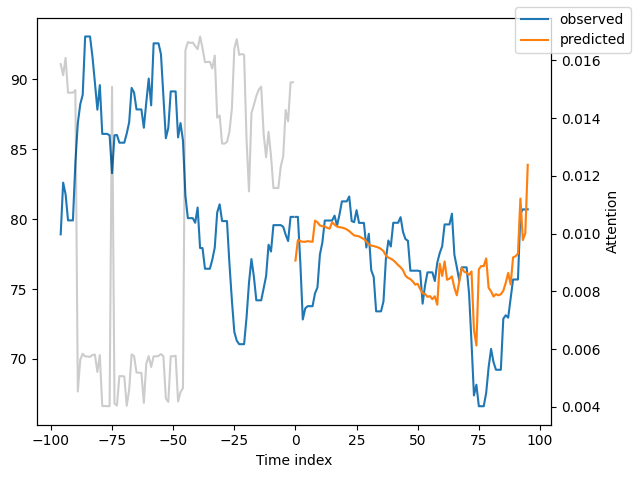

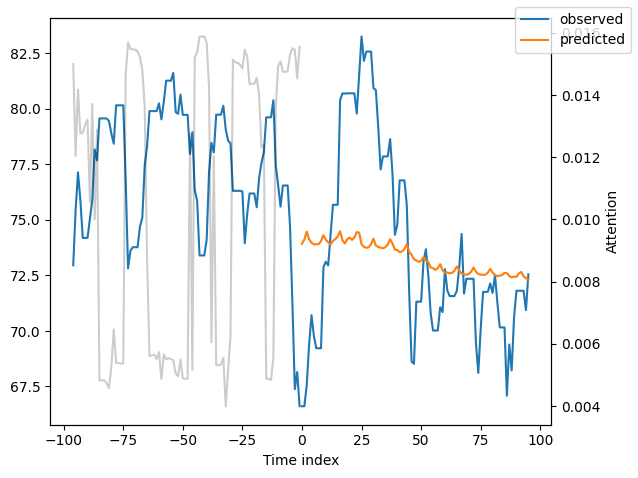

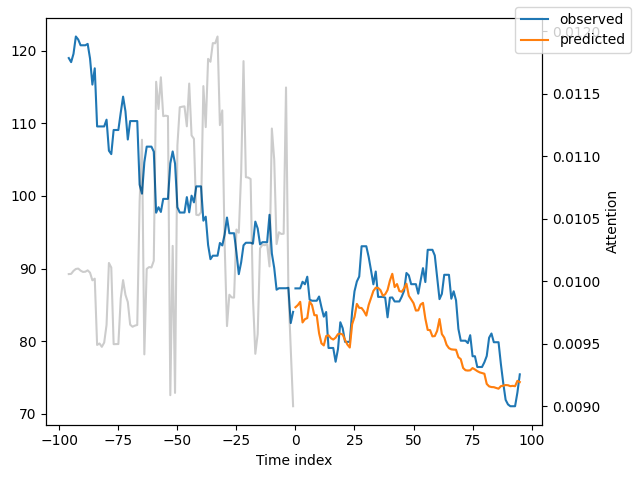

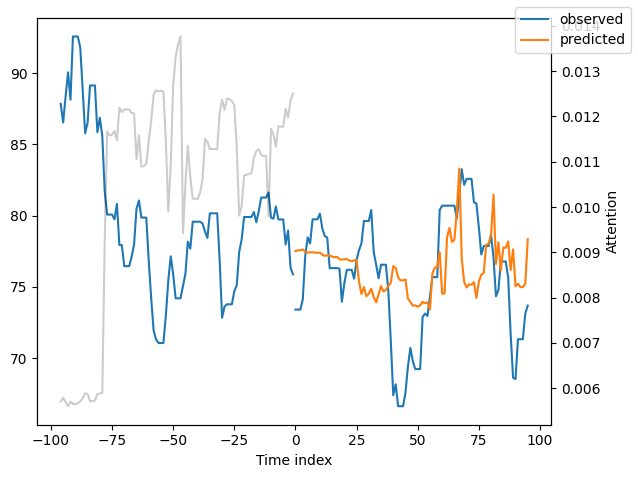

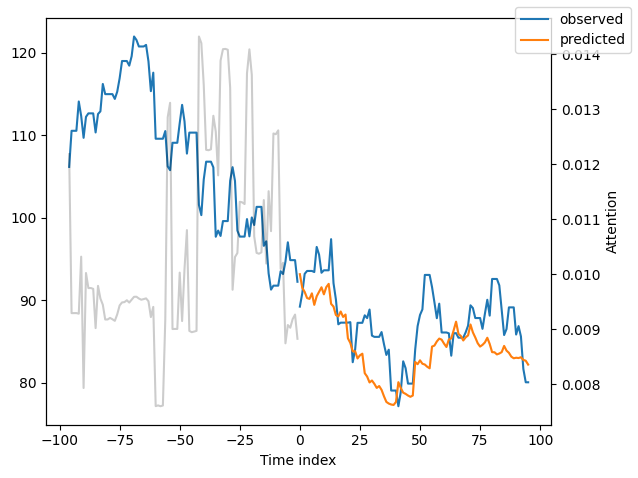

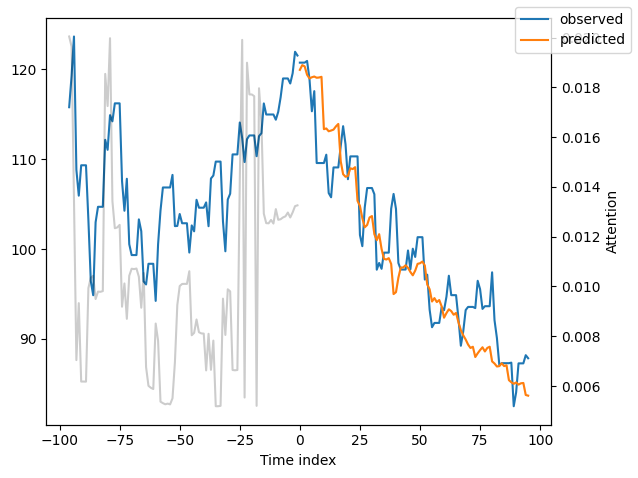

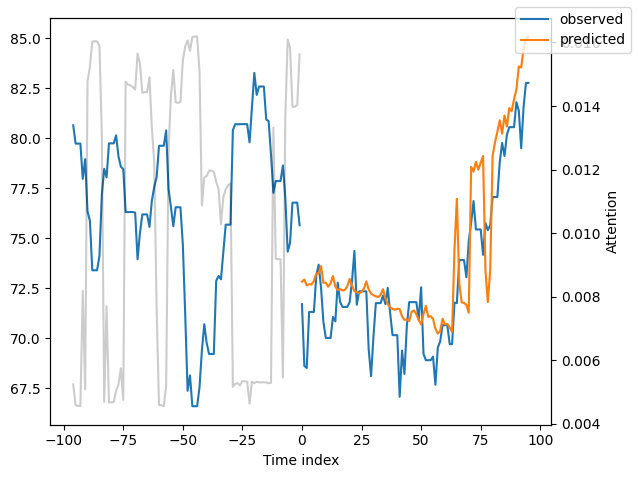

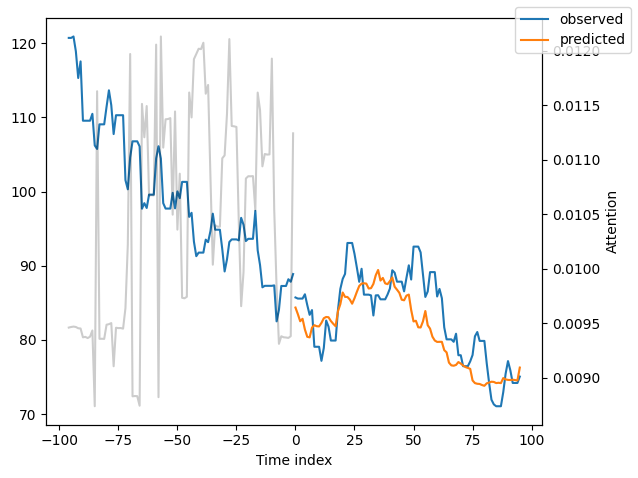

In [38]:
new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 400, 50):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

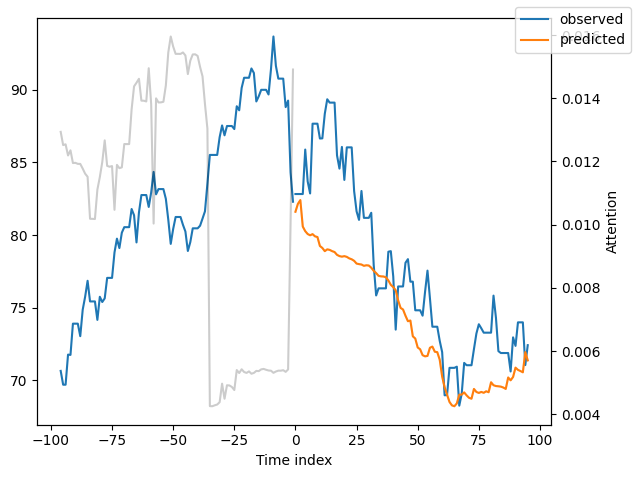

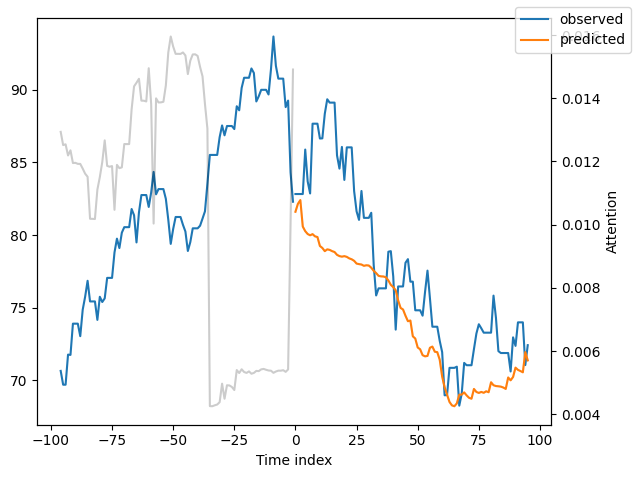

In [39]:
new_raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)


tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [41]:
a, b, c, d = get_total_loss(tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

Window: 100%|██████████| 84/84 [00:53<00:00,  1.57it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.1123
  - Mean SMAPE: 0.1037
  - Mean MAE: 8.5572
  - Mean RMSE: 9.9443


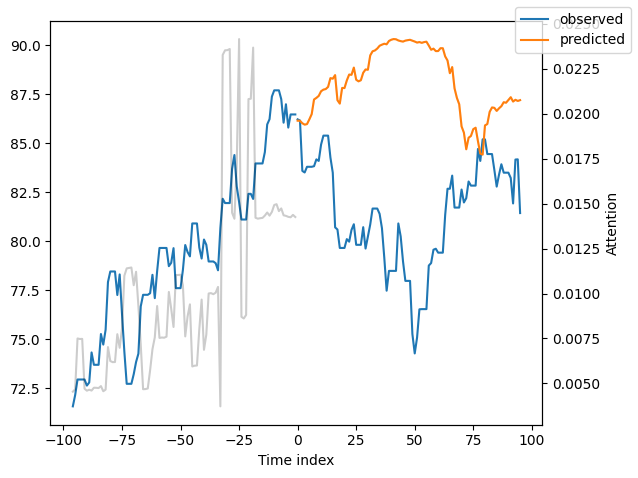

Plot for Window 0


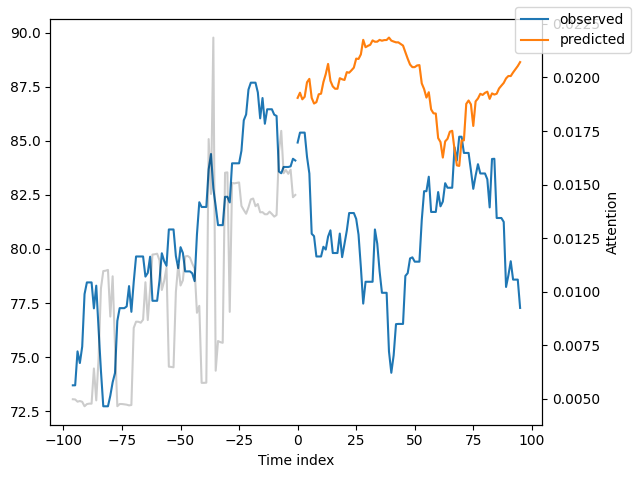

Plot for Window 10


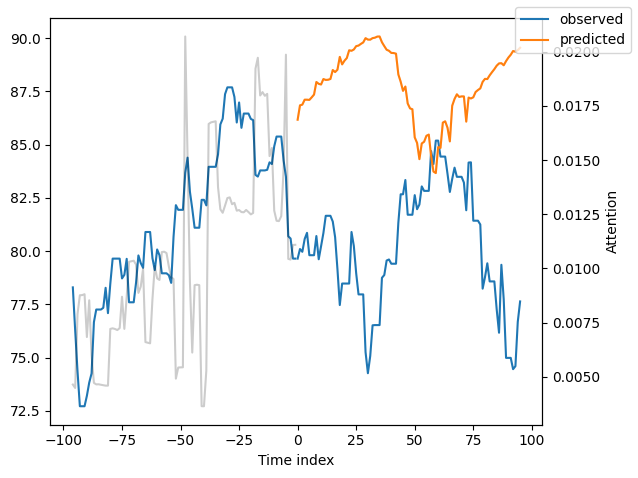

Plot for Window 20


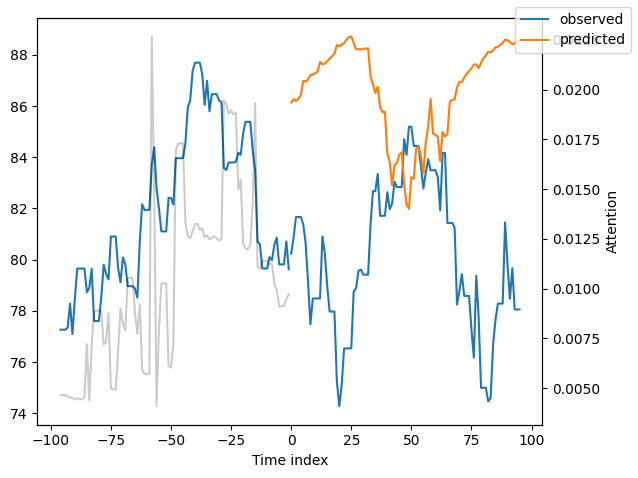

Plot for Window 30


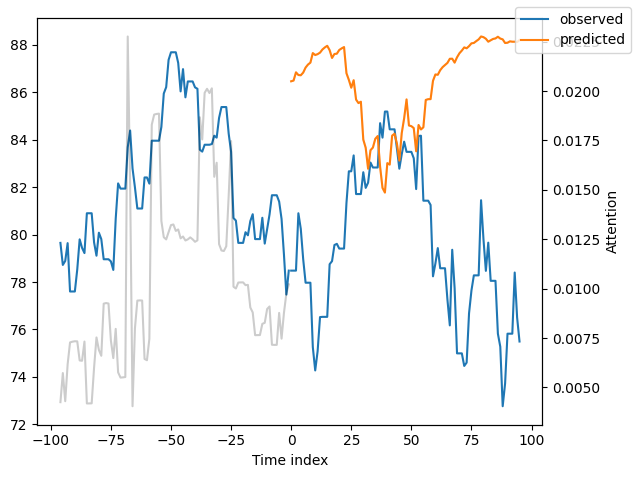

Plot for Window 40


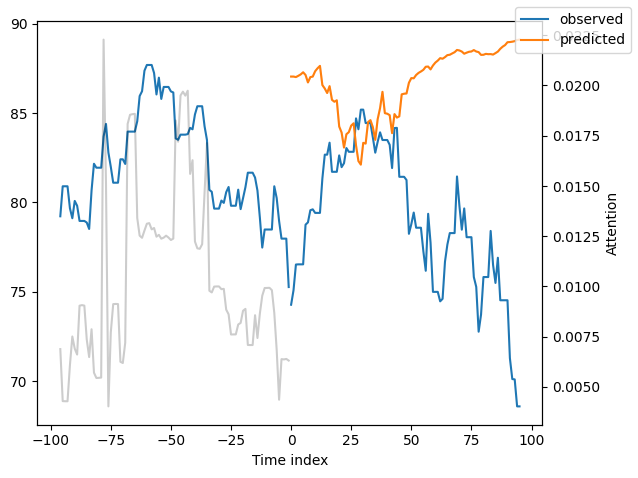

Plot for Window 50


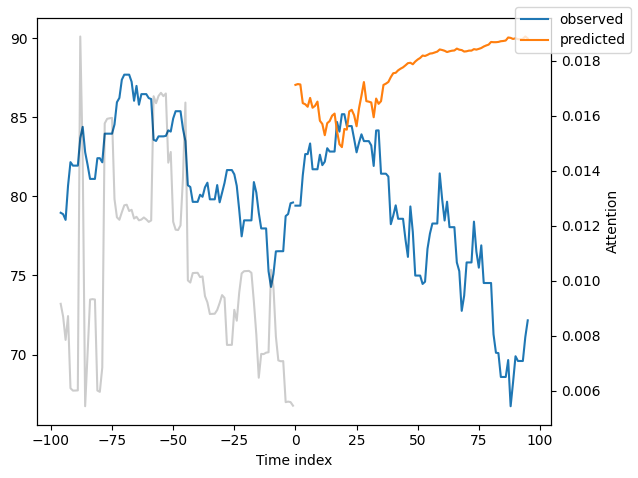

Plot for Window 60


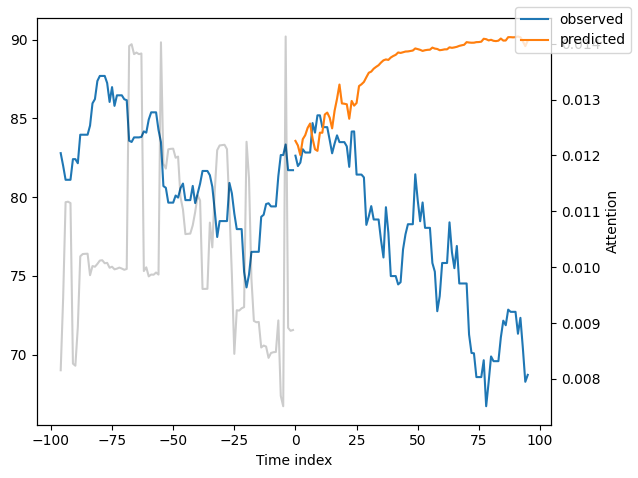

Plot for Window 70


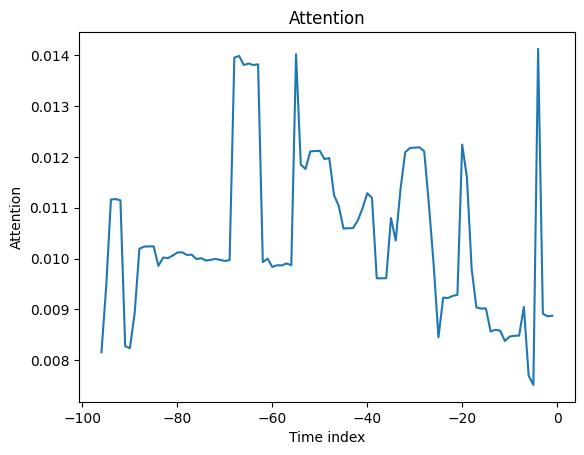

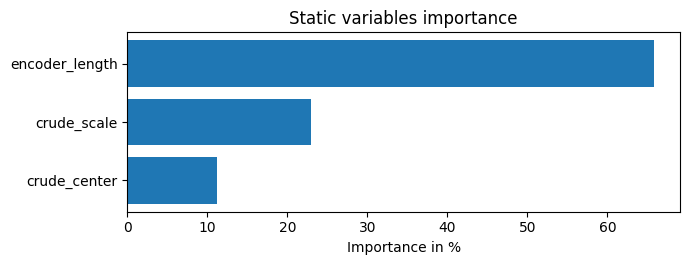

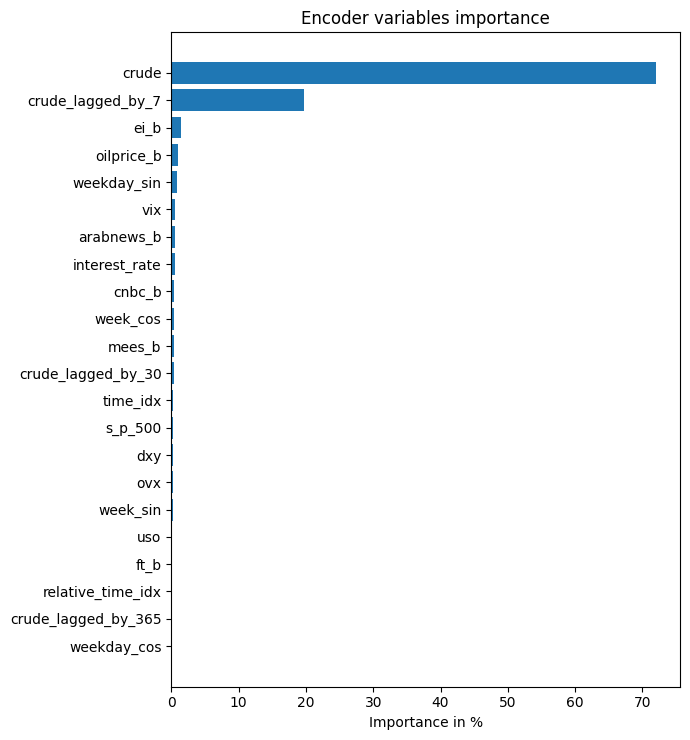

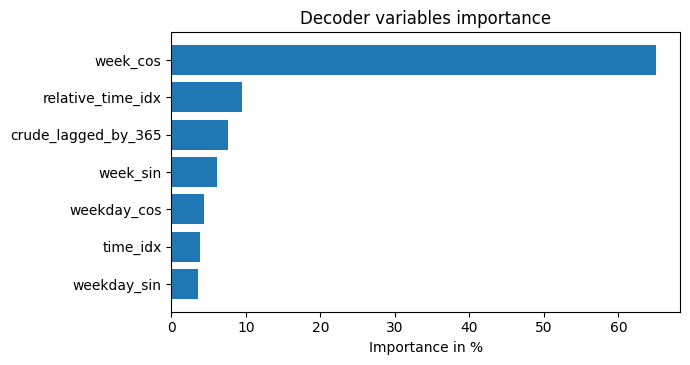

In [42]:
get_all_plots(0,80, 10, tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

In [230]:
first = get_first_preds(tft, test, train, training_dataset, max_encoder_length + max_prediction_length)

         

Window: 100%|██████████| 52/52 [00:48<00:00,  1.07it/s]


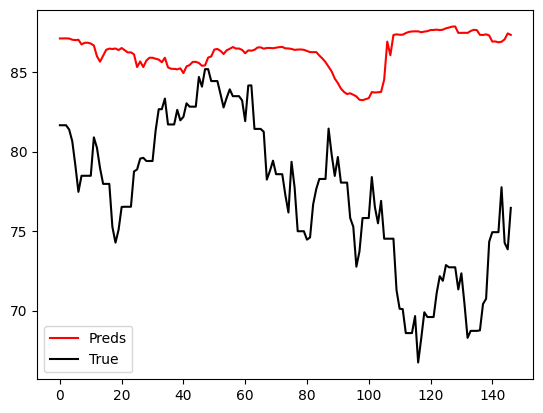

In [232]:
plt.plot(list(range(0, len(first))), first, color = 'r', label = 'Preds')
plt.plot(list(range(0, len(test[['crude']][max_encoder_length:]))), test[['crude']][max_encoder_length:], color = 'k', label = 'True')

plt.legend()
plt.show()

In [227]:
len(test[['crude']][max_encoder_length:])

147

In [147]:
len(test[['crude']][max_encoder_length:])

147

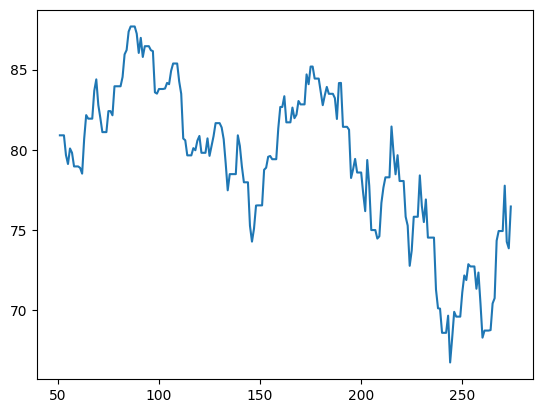

In [118]:
plt.plot(test['crude'][-(max_prediction_length+max_encoder_length):])

In [77]:
# Create test dataset


# Vertically stack the test df at the end of the training df
test_test = test[:(max_encoder_length+max_prediction_length)]


test_test = test_test.copy()
test_test["time_idx"] = range(train["time_idx"].max() + 1, train["time_idx"].max() + 1 + len(test_test))
print(test_test['time_idx'])
test_test = pd.concat([train, test_test], ignore_index=True).fillna(0.0)

test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        test_test, 
                                        predict=True, 
                                        stop_randomization=True)

print(train['time_idx'])

0      1101
1      1102
2      1103
3      1104
4      1105
       ... 
219    1320
220    1321
221    1322
222    1323
223    1324
Name: time_idx, Length: 224, dtype: int64
0          0
1          1
2          2
3          3
4          4
        ... 
1096    1096
1097    1097
1098    1098
1099    1099
1100    1100
Name: time_idx, Length: 1101, dtype: int64


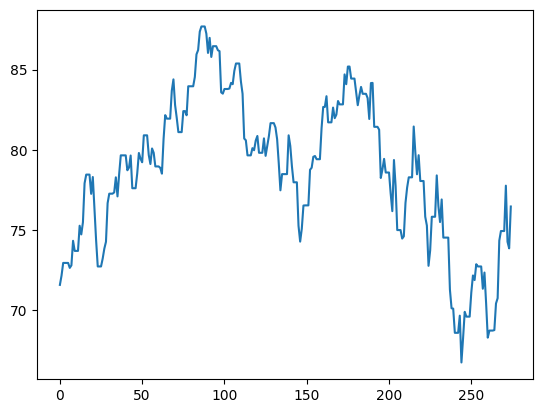

In [174]:
plt.plot(test['crude'])

In [226]:
128+96

224

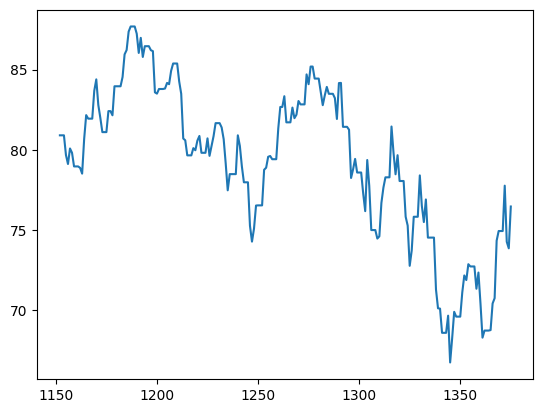

In [185]:
plt.plot(test_test['crude'][-(max_prediction_length+max_encoder_length):])

In [161]:
test_test.shape

(1335, 22)

In [71]:
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

# Get prediction results
test_prediction_results = tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

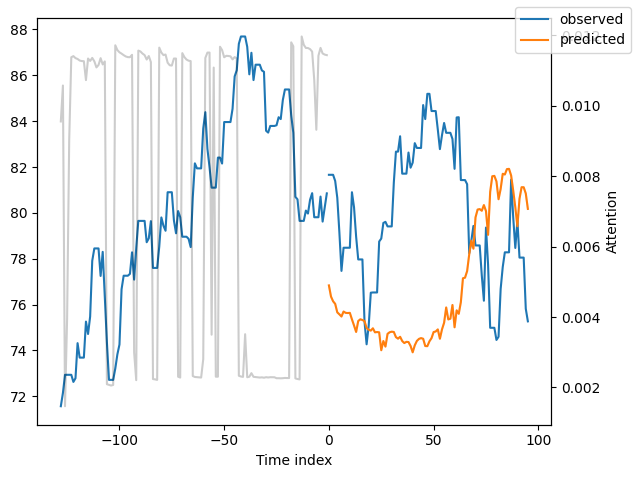

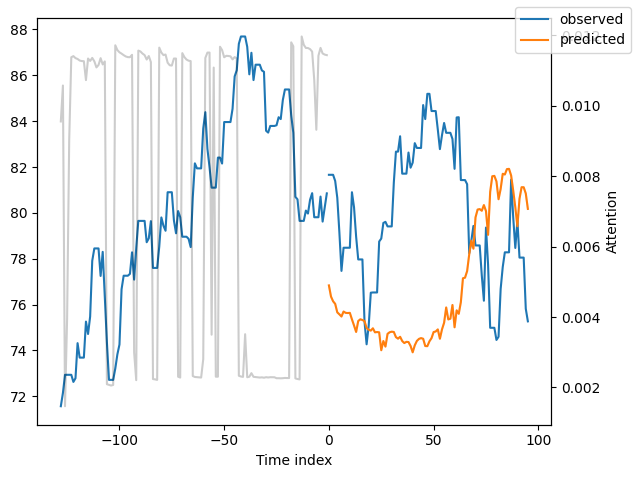

In [72]:
tft.plot_prediction(test_prediction_results.x, test_prediction_results.output, idx=0, show_future_observed=True)

# Optuna Medium Model

## Run

In [ ]:
def objective(trial):


    hidden_size = trial.suggest_int("hidden_size", 8, 16, step=4)


    #hidden_continous_size = trial.suggest_int("hidden_continous_size", 4, hidden_size, step=2)

    HPs = {
        'epochs': trial.suggest_int("epochs", 5, 15, step=5), 
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        'hidden_size': hidden_size,
        #'hidden_continous_size': hidden_continous_size,
        'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
        'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
        'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
        'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
        'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1),
        'batch_size': trial.suggest_int("batch_size", 32, 128, step=16), 
        'max_encoder_length': trial.suggest_int('max_encoder_length', 16, 128, step=16)
    }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None


In [ ]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
                                    'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
                                    'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    #hidden_continous_size = HPs['hidden_continous_size'], 
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [ ]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_large_tuning', 
                            storage='sqlite:///tft_small_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning
study.optimize(objective, n_trials=10)

# save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_large_tuning.pkl")

## Best Medium Model

In [44]:
study = joblib.load("tft_large_tuning.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))
len(sorted_trials)

101

In [47]:
value = sorted_trials[1].value
print(value)
HPs = sorted_trials[1].params
HPs

3.4920928478240967


{'epochs': 15,
 'learning_rate': 0.05415375260388988,
 'hidden_size': 12,
 'lstm_layers': 1,
 'attention_head_size': 3,
 'dropout': 0.4,
 'loss': 'RMSE',
 'gradient_clip_val': 0.8,
 'batch_size': 48,
 'max_encoder_length': 32}

In [48]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [49]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy'
        , 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )




In [50]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    dropout=HPs['dropout'],
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 25.7k


In [51]:
batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [52]:
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [53]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 13.50it/s, v_num=5.48e+7, train_loss_step=7.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:01<00:00,  8.75it/s, v_num=5.48e+7, train_loss_step=7.150, val_loss=9.850, train_loss_epoch=7.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:01<00:00,  9.00it/s, v_num=5.48e+7, train_loss_step=6.590, val_loss=10.50, train_loss_epoch=6.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:01<00:00,  8.59it/s, v_num=5.48e+7, train_loss_step=6.070, val_loss=9.810, train_loss_epoch=6.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s, v_num=5.48e+7, train_loss_step=6.170, val_loss=10.70, train_loss_epoch=6.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 12/12 [00:01<00:00,  8.97it/s, v_num=5.48e+7, train_loss_step=6.300, val_loss=11.90, train_loss_epoch=6.240]


In [56]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape



0.1029595136642456

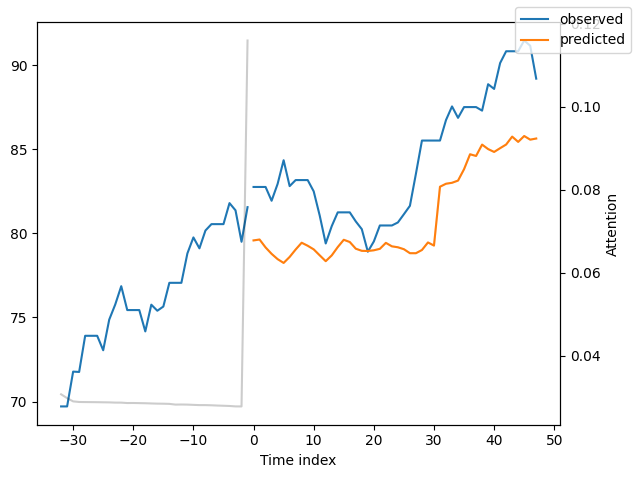

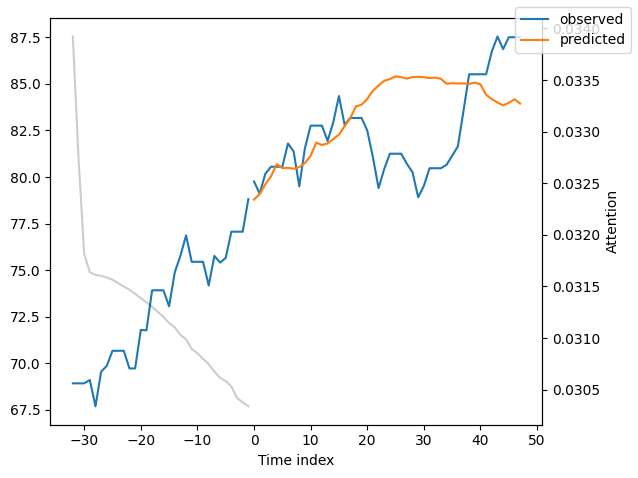

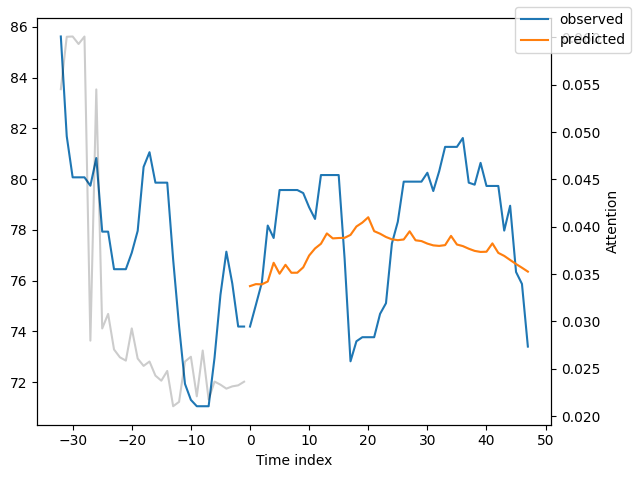

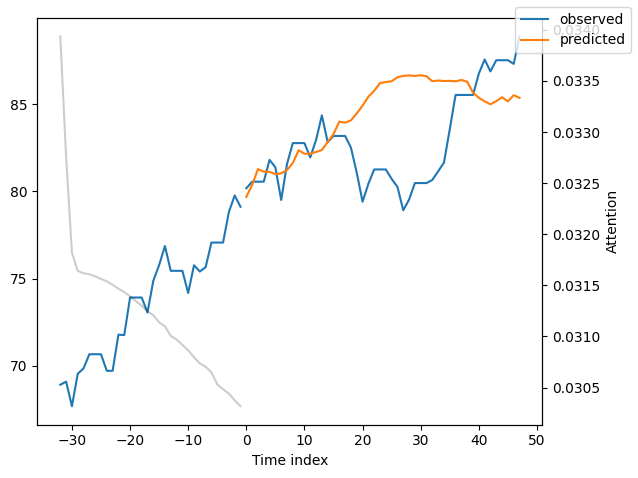

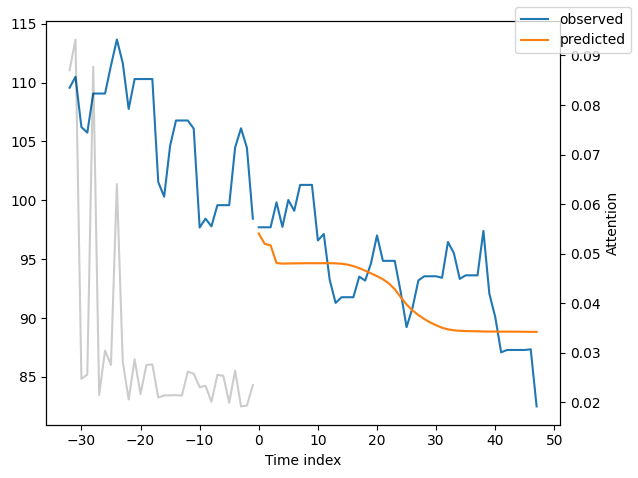

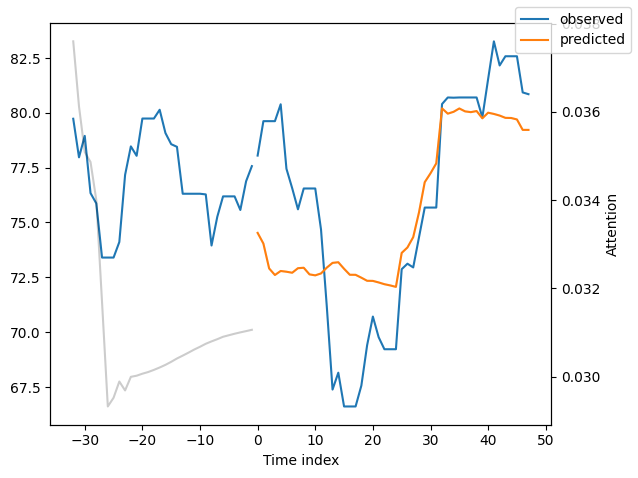

In [57]:
new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 600, 100):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

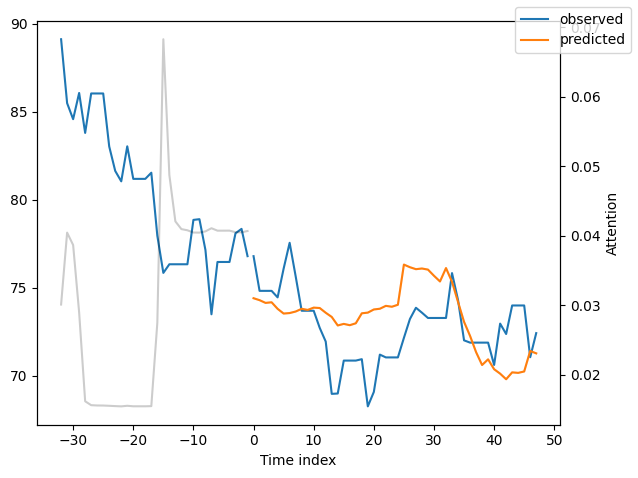

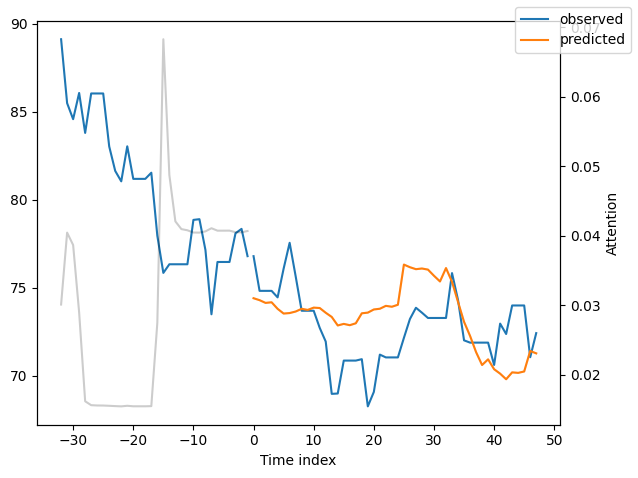

In [231]:
new_raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)


tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [59]:
a, b, c, d = get_total_loss(tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

Window: 100%|██████████| 196/196 [02:05<00:00,  1.56it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0773
  - Mean SMAPE: 0.0736
  - Mean MAE: 5.9631
  - Mean RMSE: 6.9366


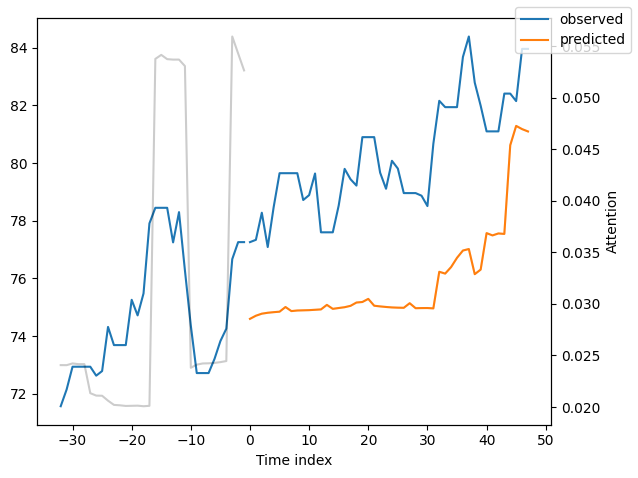

Plot for Window 0


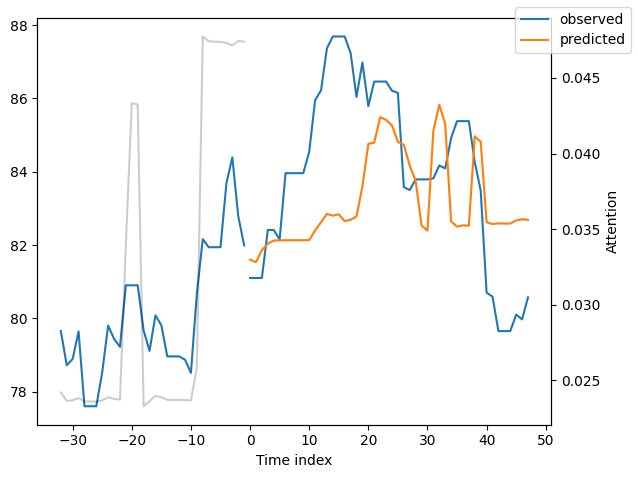

Plot for Window 40


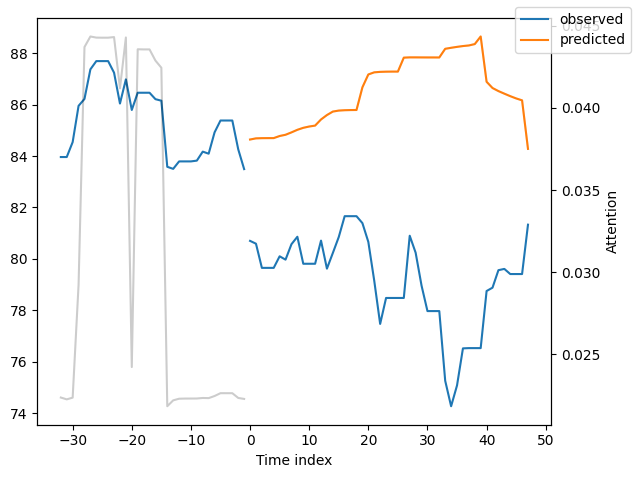

Plot for Window 80


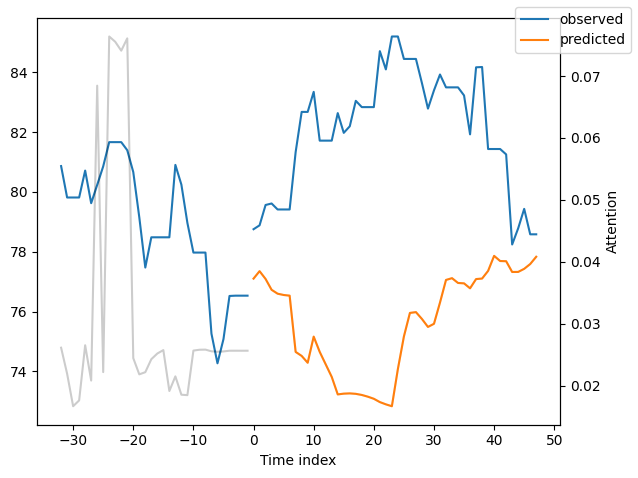

Plot for Window 120


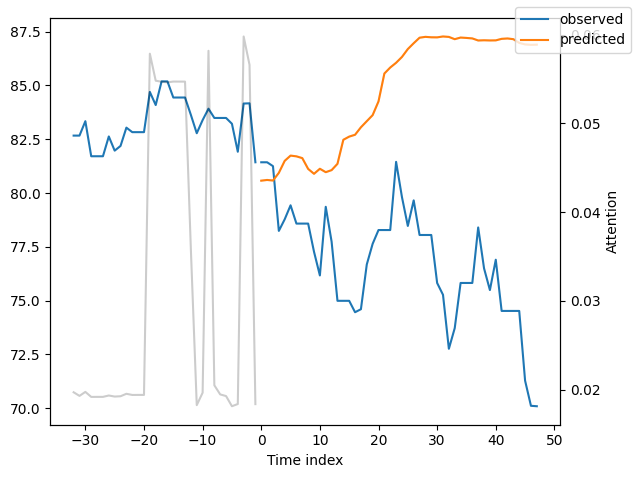

Plot for Window 160


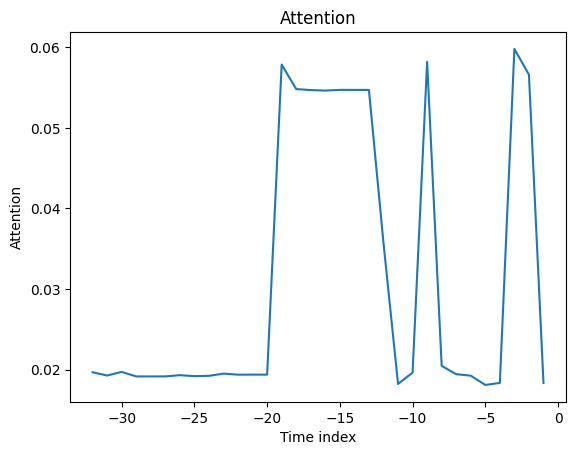

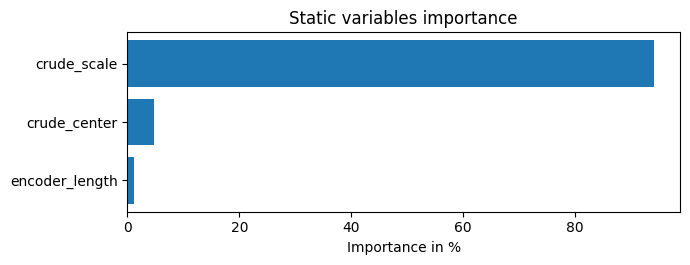

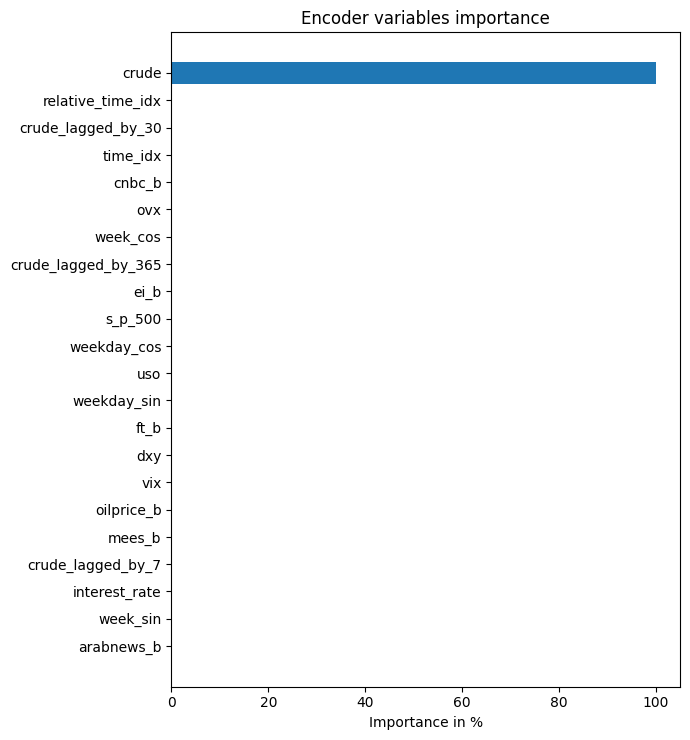

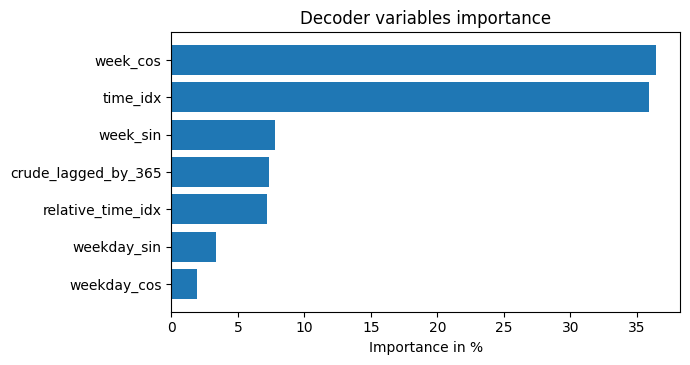

In [58]:
get_all_plots(0,200, 40, tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

In [ ]:
first = get_first_preds(tft, test, train, training_dataset, max_encoder_length + max_prediction_length)

         

Window:   1%|          | 1/196 [00:00<01:59,  1.63it/s]

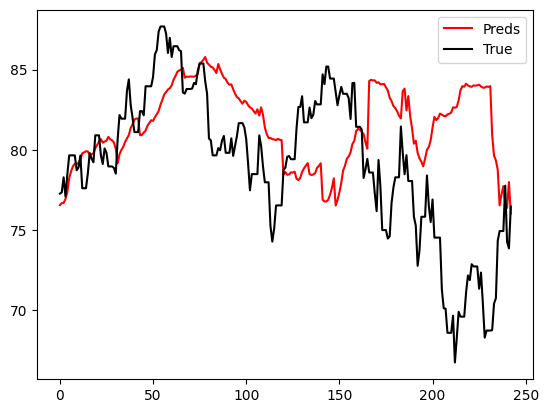

In [234]:
plt.plot(list(range(0, len(first))), first, color = 'r', label = 'Preds')
plt.plot(list(range(0, len(test[['crude']][max_encoder_length:]))), test[['crude']][max_encoder_length:], color = 'k', label = 'True')

plt.legend()
plt.show()

# Optuna Small Model

## Run

In [64]:
def objective(trial):


    hidden_size = trial.suggest_int("hidden_size", 8, 16, step=4)


    #hidden_continous_size = trial.suggest_int("hidden_continous_size", 4, hidden_size, step=2)

    HPs = {
        'epochs': trial.suggest_int("epochs", 5, 15, step=5), 
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        'hidden_size': hidden_size,
        #'hidden_continous_size': hidden_continous_size,
        'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
        'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
        'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
        'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
        'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1),
        'batch_size': trial.suggest_int("batch_size", 32, 128, step=16), 
        'max_encoder_length': trial.suggest_int('max_encoder_length', 16, 128, step=16)
    }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None


In [65]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 16 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
                                    'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
                                    'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    #hidden_continous_size = HPs['hidden_continous_size'], 
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [66]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_small_tuning', 
                            storage='sqlite:///tft_small_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning
study.optimize(objective, n_trials=10)

# save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_small_tuning.pkl")

[I 2024-12-14 02:17:56,422] Using an existing study with name 'tft_small_tuning' instead of creating a new one.


Number of parameters in network: 20.7k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  9.38it/s, v_num=5.48e+7, train_loss_step=4.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s, v_num=5.48e+7, train_loss_step=4.170, val_loss=1.540, train_loss_epoch=4.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s, v_num=5.48e+7, train_loss_step=3.810, val_loss=1.250, train_loss_epoch=4.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.27it/s, v_num=5.48e+7, train_loss_step=3.030, val_loss=3.330, train_loss_epoch=3.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s, v_num=5.48e+7, train_loss_step=3.390, val_loss=3.590, train_loss_epoch=3.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s, v_num=5.48e+7, train_loss_step=3.390, val_loss=2.09

[I 2024-12-14 02:18:10,386] Trial 20 finished with value: 6.241814613342285 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.01805944336349882, 'lstm_layers': 4, 'attention_head_size': 2, 'dropout': 0.2, 'loss': 'MAE', 'gradient_clip_val': 0.9, 'batch_size': 96, 'max_encoder_length': 32}. Best is trial 18 with value: 2.3353981971740723.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.90%
    MAPE  (Mean Absolute Percentage Error):          2.84%
    RMSE  (Root Mean Squared Error):                2.50
    MAE   (Mean Absolute Error):                    2.09
    MSE   (Mean Squared Error):                    6.24
    
Number of parameters in network: 20.6k
Epoch 0: 100%|██████████| 14/14 [00:00<00:00, 15.15it/s, v_num=5.48e+7, train_loss_step=42.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:01<00:00,  8.08it/s, v_num=5.48e+7, train_loss_step=28.10, val_loss=3.630, train_loss_epoch=36.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s, v_num=5.48e+7, train_loss_step=25.10, val_loss=2.880, train_loss_epoch=36.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, v_num=5.48e+7, train_loss_step=26.30, val_loss

[I 2024-12-14 02:18:25,425] Trial 21 finished with value: 2.202672243118286 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.00021191845519387298, 'lstm_layers': 4, 'attention_head_size': 4, 'dropout': 0.1, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 48, 'max_encoder_length': 16}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 1.60%
    MAPE  (Mean Absolute Percentage Error):          1.58%
    RMSE  (Root Mean Squared Error):                1.48
    MAE   (Mean Absolute Error):                    1.16
    MSE   (Mean Squared Error):                    2.20
    
Number of parameters in network: 20.6k
Epoch 0: 100%|██████████| 14/14 [00:00<00:00, 15.29it/s, v_num=5.48e+7, train_loss_step=36.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:01<00:00,  7.65it/s, v_num=5.48e+7, train_loss_step=28.20, val_loss=3.310, train_loss_epoch=37.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:01<00:00,  8.50it/s, v_num=5.48e+7, train_loss_step=23.50, val_loss=2.830, train_loss_epoch=33.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s, v_num=5.48e+7, train_loss_step=25.20, val_loss

[I 2024-12-14 02:18:41,473] Trial 22 finished with value: 2.3284645080566406 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.0018081581604852967, 'lstm_layers': 4, 'attention_head_size': 4, 'dropout': 0.1, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 48, 'max_encoder_length': 16}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 1.78%
    MAPE  (Mean Absolute Percentage Error):          1.79%
    RMSE  (Root Mean Squared Error):                1.53
    MAE   (Mean Absolute Error):                    1.30
    MSE   (Mean Squared Error):                    2.33
    
Number of parameters in network: 20.6k
Epoch 0: 100%|██████████| 14/14 [00:00<00:00, 15.11it/s, v_num=5.48e+7, train_loss_step=41.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:01<00:00,  8.30it/s, v_num=5.48e+7, train_loss_step=35.90, val_loss=4.760, train_loss_epoch=44.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:01<00:00,  7.97it/s, v_num=5.48e+7, train_loss_step=40.00, val_loss=4.410, train_loss_epoch=38.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, v_num=5.48e+7, train_loss_step=23.60, val_loss

[I 2024-12-14 02:18:58,373] Trial 23 finished with value: 7.150835990905762 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.001791858384825108, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.2, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 48, 'max_encoder_length': 32}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.20%
    MAPE  (Mean Absolute Percentage Error):          3.14%
    RMSE  (Root Mean Squared Error):                2.67
    MAE   (Mean Absolute Error):                    2.30
    MSE   (Mean Squared Error):                    7.15
    
Number of parameters in network: 20.6k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 12.48it/s, v_num=5.48e+7, train_loss_step=75.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, v_num=5.48e+7, train_loss_step=45.10, val_loss=7.370, train_loss_epoch=58.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s, v_num=5.48e+7, train_loss_step=33.40, val_loss=9.130, train_loss_epoch=48.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s, v_num=5.48e+7, train_loss_step=32.20, val_loss

[I 2024-12-14 02:19:13,926] Trial 24 finished with value: 7.354084491729736 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.0020909320885972174, 'lstm_layers': 4, 'attention_head_size': 4, 'dropout': 0.1, 'loss': 'MSE', 'gradient_clip_val': 0.9, 'batch_size': 64, 'max_encoder_length': 48}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.16%
    MAPE  (Mean Absolute Percentage Error):          3.19%
    RMSE  (Root Mean Squared Error):                2.71
    MAE   (Mean Absolute Error):                    2.31
    MSE   (Mean Squared Error):                    7.35
    
Number of parameters in network: 20.6k
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 11.90it/s, v_num=5.48e+7, train_loss_step=31.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s, v_num=5.48e+7, train_loss_step=29.50, val_loss=1.980, train_loss_epoch=37.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s, v_num=5.48e+7, train_loss_step=28.20, val_loss=2.570, train_loss_epoch=34.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, v_num=5.48e+7, train_loss_step=32.60, val_loss=3.040, 

[I 2024-12-14 02:19:28,159] Trial 25 finished with value: 3.4722461700439453 and parameters: {'hidden_size': 8, 'epochs': 5, 'learning_rate': 0.0006345297828805463, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.2, 'loss': 'MSE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 16}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.01%
    MAPE  (Mean Absolute Percentage Error):          1.98%
    RMSE  (Root Mean Squared Error):                1.86
    MAE   (Mean Absolute Error):                    1.46
    MSE   (Mean Squared Error):                    3.47
    
Number of parameters in network: 33.8k
Epoch 0: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, v_num=5.48e+7, train_loss_step=30.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:02<00:00,  6.87it/s, v_num=5.48e+7, train_loss_step=23.60, val_loss=8.970, train_loss_epoch=35.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:01<00:00,  7.06it/s, v_num=5.48e+7, train_loss_step=16.00, val_loss=8.210, train_loss_epoch=26.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:02<00:00,  6.37it/s, v_num=5.48e+7, train_loss_step=24.80, val_loss

[I 2024-12-14 02:19:45,862] Trial 26 finished with value: 11.323091506958008 and parameters: {'hidden_size': 12, 'epochs': 5, 'learning_rate': 0.015837725103768237, 'lstm_layers': 4, 'attention_head_size': 4, 'dropout': 0.1, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 48, 'max_encoder_length': 32}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.18%
    MAPE  (Mean Absolute Percentage Error):          4.07%
    RMSE  (Root Mean Squared Error):                3.36
    MAE   (Mean Absolute Error):                    2.99
    MSE   (Mean Squared Error):                    11.32
    
Number of parameters in network: 19.5k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s, v_num=5.48e+7, train_loss_step=4.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s, v_num=5.48e+7, train_loss_step=4.150, val_loss=1.450, train_loss_epoch=4.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s, v_num=5.48e+7, train_loss_step=3.770, val_loss=1.780, train_loss_epoch=4.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s, v_num=5.48e+7, train_loss_step=3.680, val_los

[I 2024-12-14 02:20:15,457] Trial 27 finished with value: 6.714488506317139 and parameters: {'hidden_size': 8, 'epochs': 10, 'learning_rate': 0.003741799150313052, 'lstm_layers': 3, 'attention_head_size': 4, 'dropout': 0.2, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 16}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.13%
    MAPE  (Mean Absolute Percentage Error):          3.07%
    RMSE  (Root Mean Squared Error):                2.59
    MAE   (Mean Absolute Error):                    2.25
    MSE   (Mean Squared Error):                    6.71
    
Number of parameters in network: 33.8k
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.96it/s, v_num=5.48e+7, train_loss_step=34.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s, v_num=5.48e+7, train_loss_step=39.40, val_loss=2.180, train_loss_epoch=57.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.00it/s, v_num=5.48e+7, train_loss_step=45.40, val_loss=4.760, train_loss_epoch=39.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.18it/s, v_num=5.48e+7, train_loss_step=29.70, val_loss

[I 2024-12-14 02:20:33,817] Trial 28 finished with value: 5.974189758300781 and parameters: {'hidden_size': 12, 'epochs': 5, 'learning_rate': 0.07336977144669404, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.9, 'batch_size': 48, 'max_encoder_length': 48}. Best is trial 21 with value: 2.202672243118286.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.94%
    MAPE  (Mean Absolute Percentage Error):          2.99%
    RMSE  (Root Mean Squared Error):                2.44
    MAE   (Mean Absolute Error):                    2.16
    MSE   (Mean Squared Error):                    5.97
    
Number of parameters in network: 33.8k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.81it/s, v_num=5.48e+7, train_loss_step=42.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s, v_num=5.48e+7, train_loss_step=41.20, val_loss=3.890, train_loss_epoch=41.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s, v_num=5.48e+7, train_loss_step=39.60, val_loss=3.960, train_loss_epoch=40.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s, v_num=5.48e+7, train_loss_step=38.00, val_loss=3.910, 

[I 2024-12-14 02:21:14,062] Trial 29 finished with value: 2.0776453018188477 and parameters: {'hidden_size': 12, 'epochs': 15, 'learning_rate': 0.0002090223672914188, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.1, 'loss': 'MSE', 'gradient_clip_val': 1.0, 'batch_size': 96, 'max_encoder_length': 16}. Best is trial 29 with value: 2.0776453018188477.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 1.45%
    MAPE  (Mean Absolute Percentage Error):          1.44%
    RMSE  (Root Mean Squared Error):                1.44
    MAE   (Mean Absolute Error):                    1.06
    MSE   (Mean Squared Error):                    2.08
    


['tft_small_tuning.pkl']

## Best Small Model

In [67]:
study = joblib.load("tft_small_tuning.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))


In [169]:
value = sorted_trials[0].value
print(value)
HPs = sorted_trials[0].params
HPs

2.0776453018188477


{'hidden_size': 12,
 'epochs': 15,
 'learning_rate': 0.0002090223672914188,
 'lstm_layers': 4,
 'attention_head_size': 3,
 'dropout': 0.1,
 'loss': 'MSE',
 'gradient_clip_val': 1.0,
 'batch_size': 96,
 'max_encoder_length': 16}

In [205]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [206]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 16 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy'
        , 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )




In [207]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    dropout=HPs['dropout'],
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 33.8k


In [208]:
batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [209]:
trainer = pl.Trainer(
    max_epochs=25,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [210]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s, v_num=5.48e+7, train_loss_step=30.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s, v_num=5.48e+7, train_loss_step=38.90, val_loss=7.480, train_loss_epoch=37.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s, v_num=5.48e+7, train_loss_step=39.30, val_loss=6.910, train_loss_epoch=36.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s, v_num=5.48e+7, train_loss_step=36.40, val_loss=6.420, train_loss_epoch=36.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s, v_num=5.48e+7, train_loss_step=40.00, val_loss=6.020, train_loss_epoch=36.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s, v_num=5.48e+7, train_loss_step=33.00, val_loss=5.600, train_loss_epoch=35.40]
Validation: 

In [211]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape



0.01791388727724552

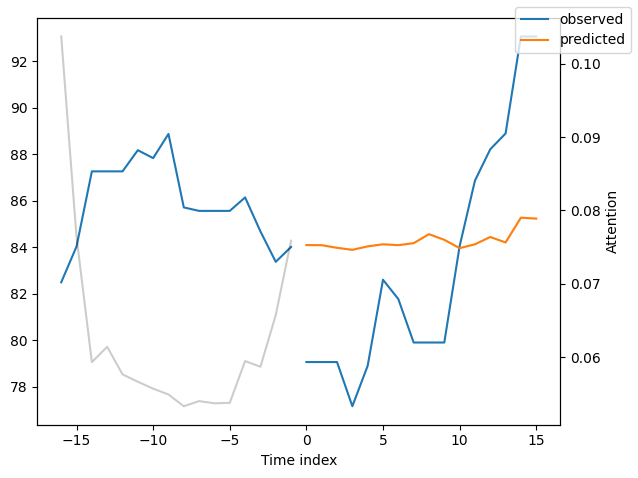

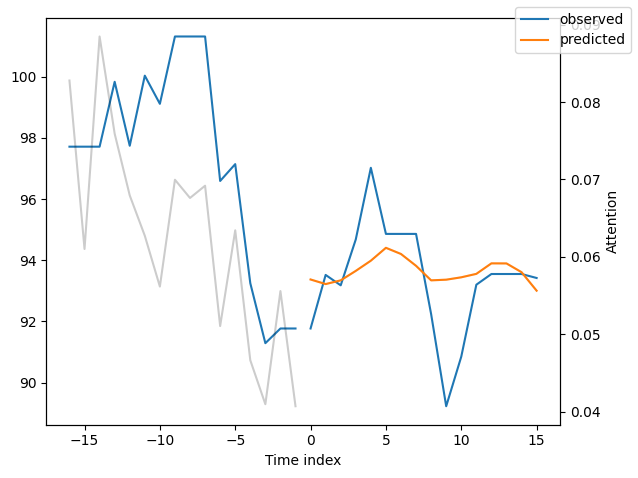

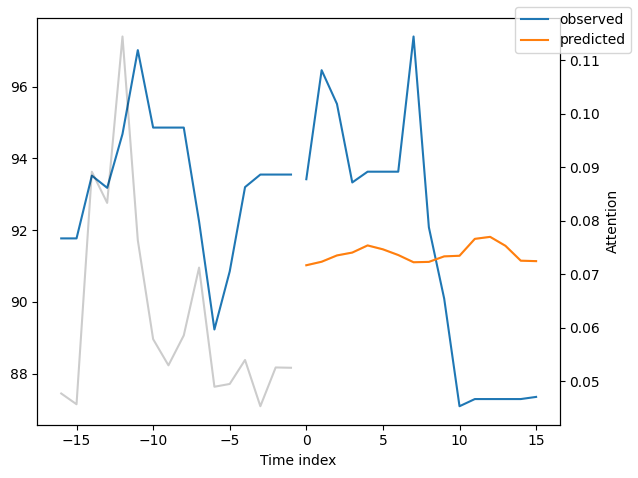

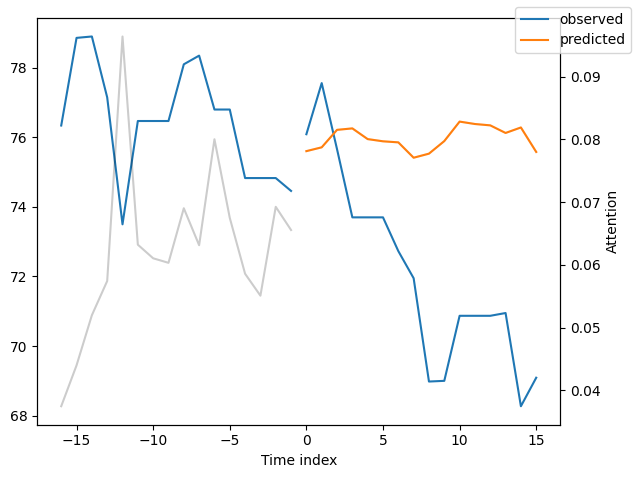

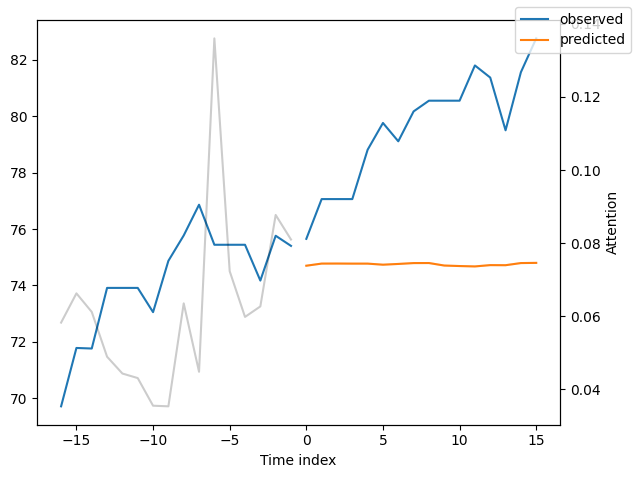

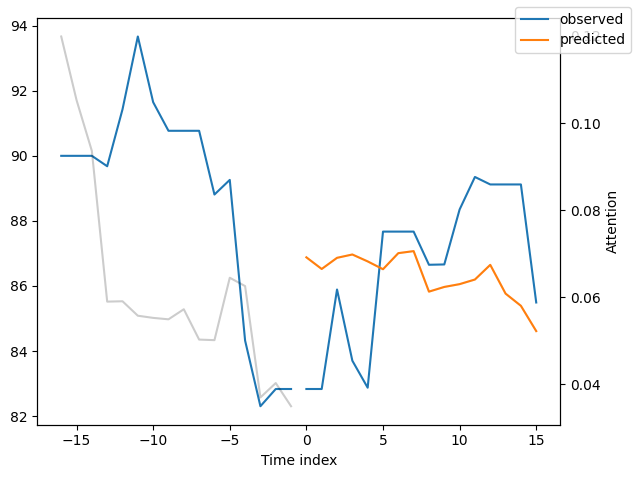

In [212]:
new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 600, 100):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

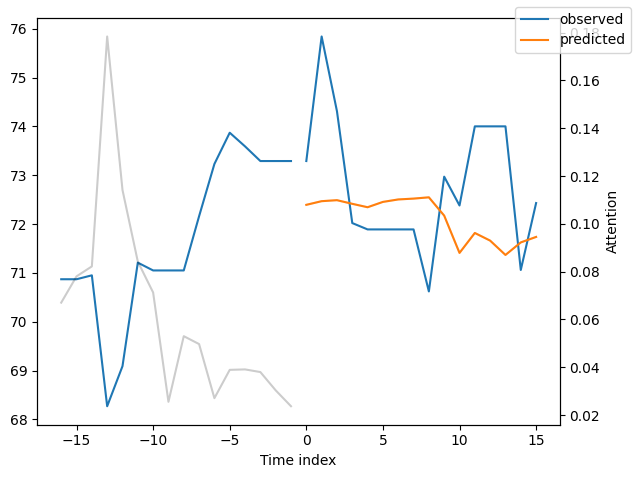

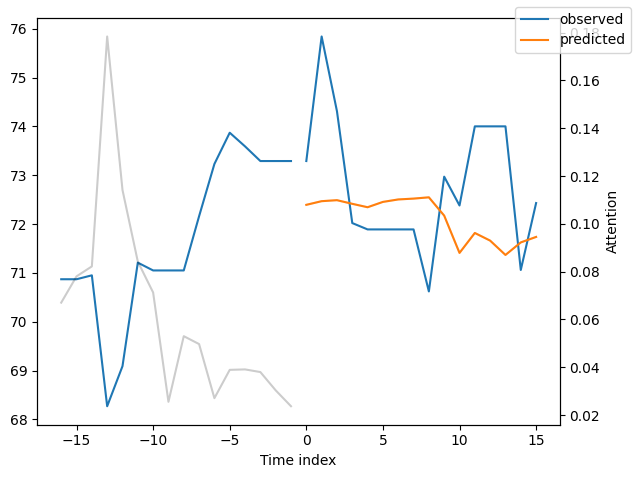

In [213]:
new_raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)


tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [76]:
a, b, c, d = get_total_loss(tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

Window: 100%|██████████| 244/244 [03:51<00:00,  1.05it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0359
  - Mean SMAPE: 0.0356
  - Mean MAE: 2.8041
  - Mean RMSE: 3.1629


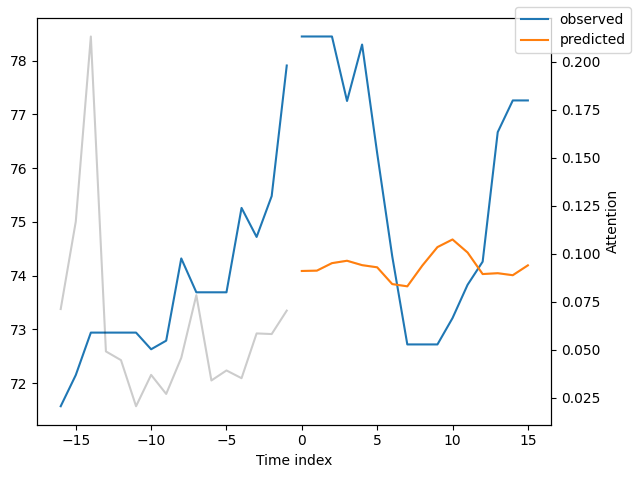

Plot for Window 0


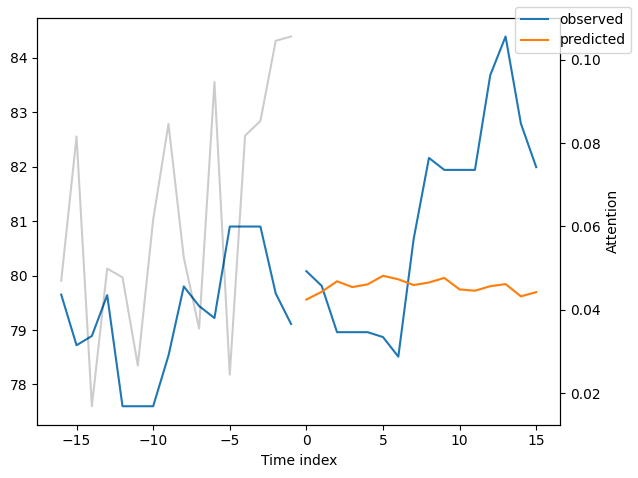

Plot for Window 40


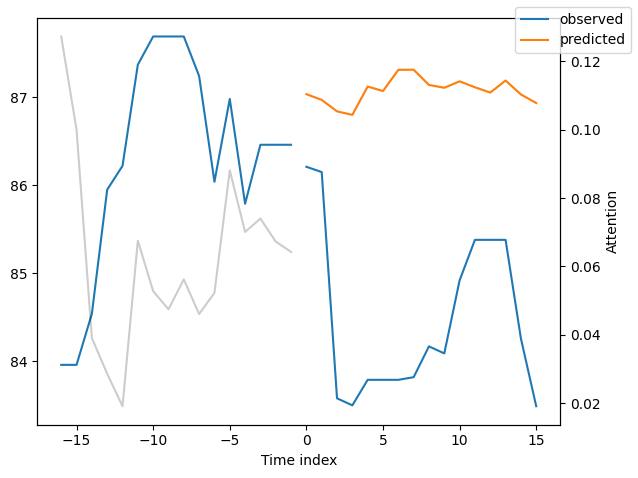

Plot for Window 80


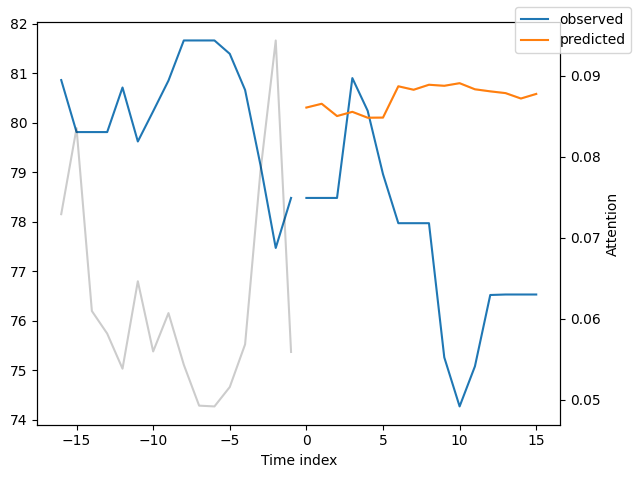

Plot for Window 120


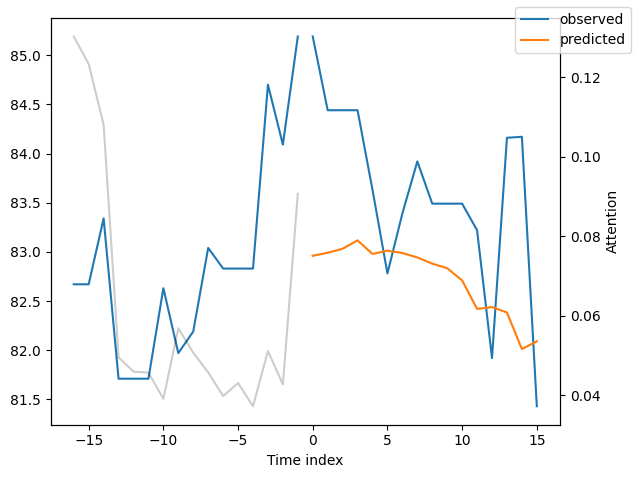

Plot for Window 160


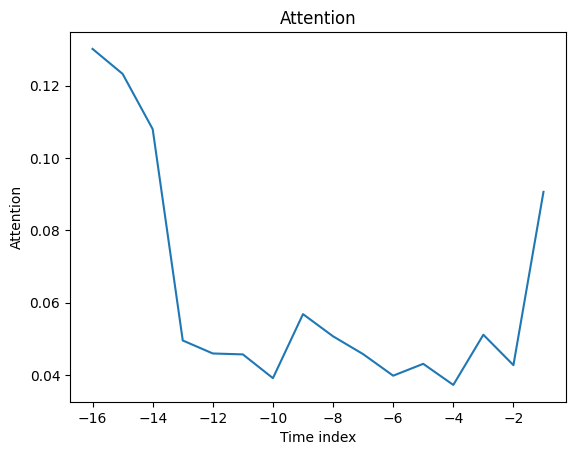

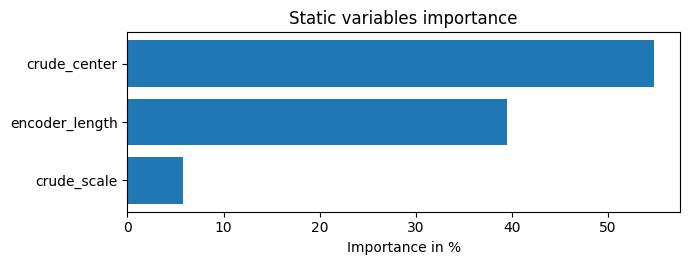

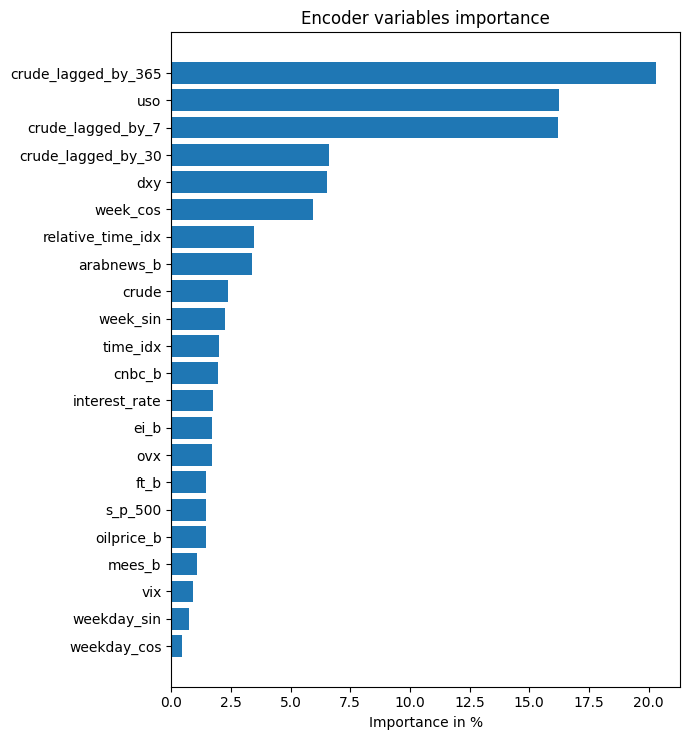

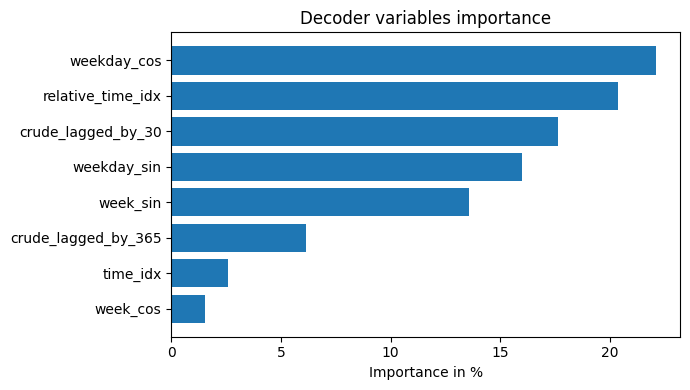

In [214]:
get_all_plots(0,200, 40, tft, test, train, training_dataset, max_encoder_length+max_prediction_length)

In [36]:
first = get_first_preds(tft, test, train, training_dataset, max_encoder_length + max_prediction_length)

         

Window:   1%|          | 3/244 [00:02<03:46,  1.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1512d9b5b420>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ext3

KeyboardInterrupt: 

In [ ]:
plt.plot(list(range(0, len(first))), first, color = 'r', label = 'Preds')
plt.plot(list(range(0, len(test[['crude']][max_encoder_length:]))), test[['crude']][max_encoder_length:], color = 'k', label = 'True')

plt.legend()
plt.show()

# Archive

## Run

In [51]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 15, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 8, 12, step=2),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'hidden_continous_size': trial.suggest_int("hidden_continous_size", 8, 12, step= 2), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16), 
              'max_encoder_length': trial.suggest_int('max_encoder_length', 32, 256, step = 32 )
              }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [55]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [61]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_medium_refined_tuning', 
                            storage='sqlite:///tft_medium_refined_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 

# file and continues the hyperparameer tuning
study.optimize(objective, n_trials=20)

    # save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_medium_refined_tuning.pkl")

[I 2024-12-13 01:53:53,413] Using an existing study with name 'tft_medium_refined_tuning' instead of creating a new one.


Number of parameters in network: 30.7k
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 11.83it/s, v_num=5.47e+7, train_loss_step=0.106] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  6.79it/s, v_num=5.47e+7, train_loss_step=0.087, val_loss=0.107, train_loss_epoch=0.111] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  6.58it/s, v_num=5.47e+7, train_loss_step=0.0915, val_loss=0.0925, train_loss_epoch=0.0959]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  6.97it/s, v_num=5.47e+7, train_loss_step=0.0765, val_loss=0.0834, train_loss_epoch=0.0886]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  6.51it/s, v_num=5.47e+7, train_loss_step=0.0784, val_loss=0.0825, train_loss_epoch=0.0855]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s, v_num=5.47e+7, train_loss_step=0.0779, v

[I 2024-12-13 01:54:24,490] Trial 81 finished with value: 40.522621154785156 and parameters: {'epochs': 15, 'learning_rate': 0.0007502727690573272, 'hidden_size': 10, 'lstm_layers': 2, 'attention_head_size': 4, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.02%
    MAPE  (Mean Absolute Percentage Error):          8.39%
    RMSE  (Root Mean Squared Error):                6.37
    MAE   (Mean Absolute Error):                    6.07
    MSE   (Mean Squared Error):                    40.52
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s, v_num=5.47e+7, train_loss_step=12.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s, v_num=5.47e+7, train_loss_step=11.50, val_loss=7.610, train_loss_epoch=12.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s, v_num=5.47e+7, train_loss_step=11.70, val_loss=7.160, train_loss_epoch=11.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s, v_num=5.47e+7, train_loss_step=10.70, val_loss=6.730,

[I 2024-12-13 01:54:43,605] Trial 82 finished with value: 21.060380935668945 and parameters: {'epochs': 10, 'learning_rate': 0.0002490085024780764, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 128, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.69%
    MAPE  (Mean Absolute Percentage Error):          5.89%
    RMSE  (Root Mean Squared Error):                4.59
    MAE   (Mean Absolute Error):                    4.23
    MSE   (Mean Squared Error):                    21.06
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s, v_num=5.47e+7, train_loss_step=6.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s, v_num=5.47e+7, train_loss_step=5.980, val_loss=1.570, train_loss_epoch=7.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s, v_num=5.47e+7, train_loss_step=4.800, val_loss=3.220, train_loss_epoch=6.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s, v_num=5.47e+7, train_loss_step=4.650, val_los

[I 2024-12-13 01:54:55,415] Trial 83 finished with value: 9.130316734313965 and parameters: {'epochs': 5, 'learning_rate': 0.0025027780063086175, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.48%
    MAPE  (Mean Absolute Percentage Error):          3.55%
    RMSE  (Root Mean Squared Error):                3.02
    MAE   (Mean Absolute Error):                    2.57
    MSE   (Mean Squared Error):                    9.13
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s, v_num=5.47e+7, train_loss_step=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.52it/s, v_num=5.47e+7, train_loss_step=9.220, val_loss=4.770, train_loss_epoch=10.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.54it/s, v_num=5.47e+7, train_loss_step=8.840, val_loss=4.250, train_loss_epoch=9.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, v_num=5.47e+7, train_loss_step=8.730, val_loss=3.790, 

[I 2024-12-13 01:55:12,707] Trial 84 finished with value: 11.8676118850708 and parameters: {'epochs': 5, 'learning_rate': 0.00018770028540472322, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.2, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 48, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.09%
    MAPE  (Mean Absolute Percentage Error):          4.20%
    RMSE  (Root Mean Squared Error):                3.44
    MAE   (Mean Absolute Error):                    3.01
    MSE   (Mean Squared Error):                    11.87
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.53it/s, v_num=5.47e+7, train_loss_step=8.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s, v_num=5.47e+7, train_loss_step=7.250, val_loss=5.580, train_loss_epoch=8.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s, v_num=5.47e+7, train_loss_step=7.000, val_loss=4.400, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s, v_num=5.47e+7, train_loss_step=7.050, val_loss=3.460,

[I 2024-12-13 01:55:41,573] Trial 85 finished with value: 7.223901271820068 and parameters: {'epochs': 15, 'learning_rate': 0.00034440050500141956, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.10%
    MAPE  (Mean Absolute Percentage Error):          3.16%
    RMSE  (Root Mean Squared Error):                2.69
    MAE   (Mean Absolute Error):                    2.27
    MSE   (Mean Squared Error):                    7.22
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s, v_num=5.47e+7, train_loss_step=7.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s, v_num=5.47e+7, train_loss_step=7.320, val_loss=2.370, train_loss_epoch=8.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s, v_num=5.47e+7, train_loss_step=7.540, val_loss=2.030, train_loss_epoch=7.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, v_num=5.47e+7, train_loss_step=6.930, val_loss=1.810, 

[I 2024-12-13 01:56:11,897] Trial 86 finished with value: 4.737497806549072 and parameters: {'epochs': 10, 'learning_rate': 0.0004394601982706644, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.28%
    MAPE  (Mean Absolute Percentage Error):          2.25%
    RMSE  (Root Mean Squared Error):                2.18
    MAE   (Mean Absolute Error):                    1.66
    MSE   (Mean Squared Error):                    4.74
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s, v_num=5.47e+7, train_loss_step=9.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s, v_num=5.47e+7, train_loss_step=6.350, val_loss=7.610, train_loss_epoch=9.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s, v_num=5.47e+7, train_loss_step=5.210, val_loss=3.460, train_loss_epoch=7.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.71it/s, v_num=5.47e+7, train_loss_step=4.540, val_loss=3.890, 

[I 2024-12-13 01:56:28,340] Trial 87 finished with value: 18.224946975708008 and parameters: {'epochs': 5, 'learning_rate': 0.01235689201106243, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.5, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.20%
    MAPE  (Mean Absolute Percentage Error):          5.38%
    RMSE  (Root Mean Squared Error):                4.27
    MAE   (Mean Absolute Error):                    3.86
    MSE   (Mean Squared Error):                    18.22
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.78it/s, v_num=5.47e+7, train_loss_step=12.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, v_num=5.47e+7, train_loss_step=11.30, val_loss=8.240, train_loss_epoch=13.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.63it/s, v_num=5.47e+7, train_loss_step=8.920, val_loss=5.840, train_loss_epoch=11.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s, v_num=5.47e+7, train_loss_step=8.130, val_loss=3.820,

[I 2024-12-13 01:56:49,068] Trial 88 finished with value: 29.79345703125 and parameters: {'epochs': 10, 'learning_rate': 0.0009209403353805805, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.10%
    MAPE  (Mean Absolute Percentage Error):          6.36%
    RMSE  (Root Mean Squared Error):                5.46
    MAE   (Mean Absolute Error):                    4.62
    MSE   (Mean Squared Error):                    29.79
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s, v_num=5.47e+7, train_loss_step=0.098] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, v_num=5.47e+7, train_loss_step=0.0881, val_loss=0.089, train_loss_epoch=0.103]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s, v_num=5.47e+7, train_loss_step=0.0797, val_loss=0.0545, train_loss_epoch=0.0881]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s, v_num=5.47e+7, train_loss_step=0.0742, val_loss=

[I 2024-12-13 01:57:08,623] Trial 89 finished with value: 9.930793762207031 and parameters: {'epochs': 10, 'learning_rate': 0.0005414296528916709, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.59%
    MAPE  (Mean Absolute Percentage Error):          3.68%
    RMSE  (Root Mean Squared Error):                3.15
    MAE   (Mean Absolute Error):                    2.65
    MSE   (Mean Squared Error):                    9.93
    
Number of parameters in network: 33.5k
Epoch 0: 100%|██████████| 14/14 [00:02<00:00,  6.25it/s, v_num=5.47e+7, train_loss_step=160.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:02<00:00,  5.03it/s, v_num=5.47e+7, train_loss_step=63.10, val_loss=51.30, train_loss_epoch=241.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:02<00:00,  5.08it/s, v_num=5.47e+7, train_loss_step=60.20, val_loss=5.410, train_loss_epoch=92.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:02<00:00,  5.22it/s, v_num=5.47e+7, train_loss_step=34.40, val_loss

[I 2024-12-13 01:57:27,741] Trial 90 finished with value: 59.09428024291992 and parameters: {'epochs': 5, 'learning_rate': 0.001177824871506111, 'hidden_size': 10, 'lstm_layers': 2, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MSE', 'gradient_clip_val': 0.9, 'batch_size': 32, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.78%
    MAPE  (Mean Absolute Percentage Error):          8.27%
    RMSE  (Root Mean Squared Error):                7.69
    MAE   (Mean Absolute Error):                    6.04
    MSE   (Mean Squared Error):                    59.09
    
Number of parameters in network: 25.4k
Epoch 0: 100%|██████████| 12/12 [00:01<00:00,  9.47it/s, v_num=5.47e+7, train_loss_step=6.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:01<00:00,  6.81it/s, v_num=5.47e+7, train_loss_step=5.280, val_loss=4.250, train_loss_epoch=8.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:01<00:00,  6.99it/s, v_num=5.47e+7, train_loss_step=4.660, val_loss=8.510, train_loss_epoch=5.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s, v_num=5.47e+7, train_loss_step=4.700, val_los

[I 2024-12-13 01:57:55,212] Trial 91 finished with value: 79.8178482055664 and parameters: {'epochs': 10, 'learning_rate': 0.022787643020819044, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 11.28%
    MAPE  (Mean Absolute Percentage Error):          12.00%
    RMSE  (Root Mean Squared Error):                8.93
    MAE   (Mean Absolute Error):                    8.70
    MSE   (Mean Squared Error):                    79.82
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, v_num=5.47e+7, train_loss_step=8.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=5.47e+7, train_loss_step=8.160, val_loss=1.900, train_loss_epoch=9.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s, v_num=5.47e+7, train_loss_step=7.880, val_loss=1.730, train_loss_epoch=8.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=5.47e+7, train_loss_step=7.720, val_loss=1.68

[I 2024-12-13 01:58:25,382] Trial 92 finished with value: 4.876248836517334 and parameters: {'epochs': 10, 'learning_rate': 0.00041621053712623187, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.46%
    MAPE  (Mean Absolute Percentage Error):          2.43%
    RMSE  (Root Mean Squared Error):                2.21
    MAE   (Mean Absolute Error):                    1.79
    MSE   (Mean Squared Error):                    4.88
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, v_num=5.47e+7, train_loss_step=8.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, v_num=5.47e+7, train_loss_step=7.500, val_loss=2.230, train_loss_epoch=8.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s, v_num=5.47e+7, train_loss_step=7.650, val_loss=1.800, train_loss_epoch=7.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, v_num=5.47e+7, train_loss_step=7.210, val_loss=1.640, 

[I 2024-12-13 01:58:56,250] Trial 93 finished with value: 11.731013298034668 and parameters: {'epochs': 10, 'learning_rate': 0.00028901259256965204, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.08%
    MAPE  (Mean Absolute Percentage Error):          3.97%
    RMSE  (Root Mean Squared Error):                3.43
    MAE   (Mean Absolute Error):                    2.93
    MSE   (Mean Squared Error):                    11.73
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  4.75it/s, v_num=5.47e+7, train_loss_step=6.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s, v_num=5.47e+7, train_loss_step=8.430, val_loss=2.300, train_loss_epoch=8.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s, v_num=5.47e+7, train_loss_step=7.770, val_loss=1.740, train_loss_epoch=7.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s, v_num=5.47e+7, train_loss_step=6.280, val_loss=1.940,

[I 2024-12-13 01:59:45,626] Trial 94 finished with value: 35.321533203125 and parameters: {'epochs': 15, 'learning_rate': 0.0007163085141029715, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 48, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.39%
    MAPE  (Mean Absolute Percentage Error):          7.72%
    RMSE  (Root Mean Squared Error):                5.94
    MAE   (Mean Absolute Error):                    5.55
    MSE   (Mean Squared Error):                    35.32
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=5.47e+7, train_loss_step=8.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=5.47e+7, train_loss_step=6.940, val_loss=1.780, train_loss_epoch=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=5.47e+7, train_loss_step=5.710, val_loss=3.060, train_loss_epoch=7.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, v_num=5.47e+7, train_loss_step=6.360, val_loss=3.300,

[I 2024-12-13 02:00:02,127] Trial 95 finished with value: 4.043964862823486 and parameters: {'epochs': 5, 'learning_rate': 0.0036481658879659743, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.8, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.19%
    MAPE  (Mean Absolute Percentage Error):          2.17%
    RMSE  (Root Mean Squared Error):                2.01
    MAE   (Mean Absolute Error):                    1.59
    MSE   (Mean Squared Error):                    4.04
    
Number of parameters in network: 31.8k
Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, v_num=5.47e+7, train_loss_step=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, v_num=5.47e+7, train_loss_step=7.470, val_loss=2.300, train_loss_epoch=11.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=6.680, val_loss=1.570, train_loss_epoch=8.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=5.990, val_loss=1.910, 

[I 2024-12-13 02:00:18,132] Trial 96 finished with value: 6.314725399017334 and parameters: {'epochs': 5, 'learning_rate': 0.003828754838880079, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 1.0, 'batch_size': 112, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.50%
    MAPE  (Mean Absolute Percentage Error):          2.54%
    RMSE  (Root Mean Squared Error):                2.51
    MAE   (Mean Absolute Error):                    1.83
    MSE   (Mean Squared Error):                    6.31
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=5.47e+7, train_loss_step=0.0729]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=5.47e+7, train_loss_step=0.0718, val_loss=0.0537, train_loss_epoch=0.0929]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=5.47e+7, train_loss_step=0.0594, val_loss=0.125, train_loss_epoch=0.0694] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=5.47e+7, train_loss_step=0.0528, val_loss

[I 2024-12-13 02:00:35,740] Trial 97 finished with value: 417.4295654296875 and parameters: {'epochs': 5, 'learning_rate': 0.006196482791859688, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'SMAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 24.56%
    MAPE  (Mean Absolute Percentage Error):          28.05%
    RMSE  (Root Mean Squared Error):                20.43
    MAE   (Mean Absolute Error):                    20.33
    MSE   (Mean Squared Error):                    417.43
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s, v_num=5.47e+7, train_loss_step=8.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s, v_num=5.47e+7, train_loss_step=7.370, val_loss=2.340, train_loss_epoch=10.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, v_num=5.47e+7, train_loss_step=5.840, val_loss=4.720, train_loss_epoch=7.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, v_num=5.47e+7, train_loss_step=4.860, val_loss=7

[I 2024-12-13 02:00:52,890] Trial 98 finished with value: 41.00082015991211 and parameters: {'epochs': 5, 'learning_rate': 0.007401652929273947, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 256}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.38%
    MAPE  (Mean Absolute Percentage Error):          6.72%
    RMSE  (Root Mean Squared Error):                6.40
    MAE   (Mean Absolute Error):                    4.92
    MSE   (Mean Squared Error):                    41.00
    
Number of parameters in network: 29.1k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, v_num=5.47e+7, train_loss_step=0.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=5.47e+7, train_loss_step=0.0818, val_loss=0.0236, train_loss_epoch=0.113]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=5.47e+7, train_loss_step=0.0719, val_loss=0.0309, train_loss_epoch=0.087]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=5.47e+7, train_loss_step=0.0766, val_loss=0

[I 2024-12-13 02:01:03,770] Trial 99 finished with value: 3.526397705078125 and parameters: {'epochs': 5, 'learning_rate': 0.002526626130695399, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 2, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.08%
    MAPE  (Mean Absolute Percentage Error):          2.08%
    RMSE  (Root Mean Squared Error):                1.88
    MAE   (Mean Absolute Error):                    1.51
    MSE   (Mean Squared Error):                    3.53
    
Number of parameters in network: 21.8k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=5.47e+7, train_loss_step=0.0752]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=5.47e+7, train_loss_step=0.0645, val_loss=0.0353, train_loss_epoch=0.0848]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, v_num=5.47e+7, train_loss_step=0.0649, val_loss=0.0498, train_loss_epoch=0.067] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, v_num=5.47e+7, train_loss_step=0.0586, val_loss

[I 2024-12-13 02:01:21,129] Trial 100 finished with value: 5.688180923461914 and parameters: {'epochs': 5, 'learning_rate': 0.0018681301802036029, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.84%
    MAPE  (Mean Absolute Percentage Error):          2.83%
    RMSE  (Root Mean Squared Error):                2.38
    MAE   (Mean Absolute Error):                    2.06
    MSE   (Mean Squared Error):                    5.69
    


['tft_medium_refined_tuning.pkl']

In [81]:
# joblib.dump(study, "tft_medium_tuning.pkl")

['tft_medium_tuning.pkl']

In [63]:
study.best_trials

[FrozenTrial(number=28, state=1, values=[2.955333948135376], datetime_start=datetime.datetime(2024, 12, 13, 1, 24, 18, 108478), datetime_complete=datetime.datetime(2024, 12, 13, 1, 24, 34, 325066), params={'epochs': 5, 'learning_rate': 0.00588052466230126, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 256}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'epochs': IntDistribution(high=15, log=False, low=5, step=5), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'hidden_size': IntDistribution(high=12, log=False, low=8, step=2), 'lstm_layers': IntDistribution(high=4, log=False, low=1, step=1), 'attention_head_size': IntDistribution(high=4, log=False, low=1, step=1), 'hidden_continous_size': IntDistribution(high=12, log=False, low=8, step=2), 'dropout': FloatDistribution(high=0.5, log=False, l

In [143]:
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))

sorted_trials[2]

FrozenTrial(number=73, state=1, values=[3.4772346019744873], datetime_start=datetime.datetime(2024, 12, 13, 1, 49, 7, 527351), datetime_complete=datetime.datetime(2024, 12, 13, 1, 49, 38, 993142), params={'epochs': 10, 'learning_rate': 0.0004044500344979071, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 160}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'epochs': IntDistribution(high=15, log=False, low=5, step=5), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'hidden_size': IntDistribution(high=12, log=False, low=8, step=2), 'lstm_layers': IntDistribution(high=4, log=False, low=1, step=1), 'attention_head_size': IntDistribution(high=4, log=False, low=1, step=1), 'hidden_continous_size': IntDistribution(high=12, log=False, low=8, step=2), 'dropout': FloatDistribution(high=0.5, log=False,

In [286]:
HPs = sorted_trials[2].params
HPs
sorted_trials[2].value

3.4772346019744873

## Best Medium Model

In [127]:
# study = joblib.load("tft_medium_tuning.pkl")

# HPs = study.best_params
# HPs

{'epochs': 15,
 'learning_rate': 0.00367249822320984,
 'hidden_size': 16,
 'lstm_layers': 2,
 'attention_head_size': 3,
 'hidden_continous_size': 16,
 'dropout': 0.2,
 'loss': 'RMSE',
 'gradient_clip_val': 0.8,
 'batch_size': 128,
 'max_encoder_length': 160}

In [301]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [302]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )


    # con[["time_idx"]]+=train[["time_idx"]].max()+1
    # con = pd.concat([train, con], ignore_index=True).fillna(0.0)

    # validation_dataset = TimeSeriesDataSet.from_dataset(
    # training_dataset, 
    # con, 
    # predict= False,
    # stop_randomization=True,
    # min_prediction_idx=training_cutoff + 1)
    
    tests = get_test_windows(test, max_encoder_length, max_prediction_length)
    val_windows = get_test_windows(val, max_encoder_length, max_prediction_length)


In [311]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    #dropout=HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'], 
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 31.7k


In [290]:
trainer = pl.Trainer(
    accelerator="gpu"
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Finding best initial lr:  20%|██        | 20/100 [00:13<00:47,  1.67it/s]

NameError: name 'exit' is not defined

In [304]:

batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [312]:
trainer = pl.Trainer(
    max_epochs=HPs['epochs'],
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [313]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s, v_num=5.47e+7, train_loss_step=0.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s, v_num=5.47e+7, train_loss_step=0.101, val_loss=0.101, train_loss_epoch=0.120] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s, v_num=5.47e+7, train_loss_step=0.0887, val_loss=0.0812, train_loss_epoch=0.107]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s, v_num=5.47e+7, train_loss_step=0.0892, val_loss=0.0637, train_loss_epoch=0.096]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s, v_num=5.47e+7, train_loss_step=0.0807, val_loss=0.0484, train_loss_epoch=0.0868]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s, v_num=5.47e+7, train_loss_step=0.0818, val_loss=0.0376, train_loss_epoch=0.0788]
V

In [315]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape

0.023683853447437286

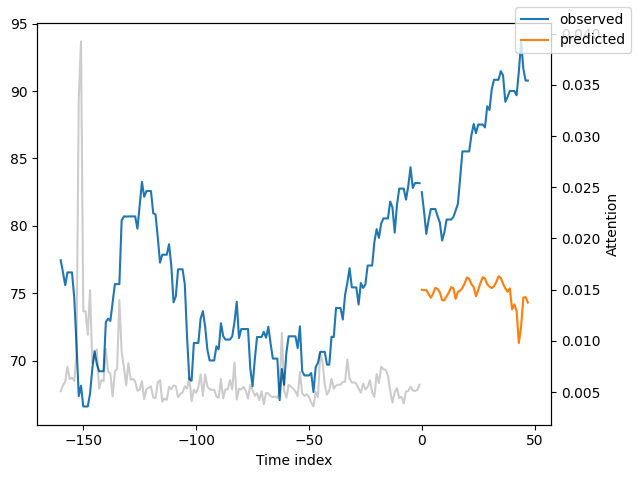

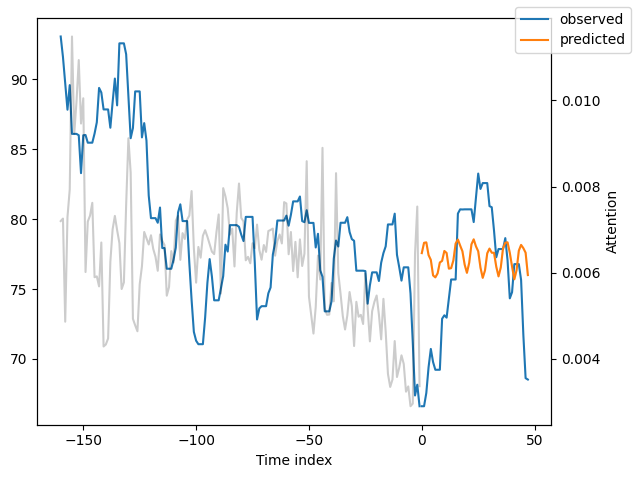

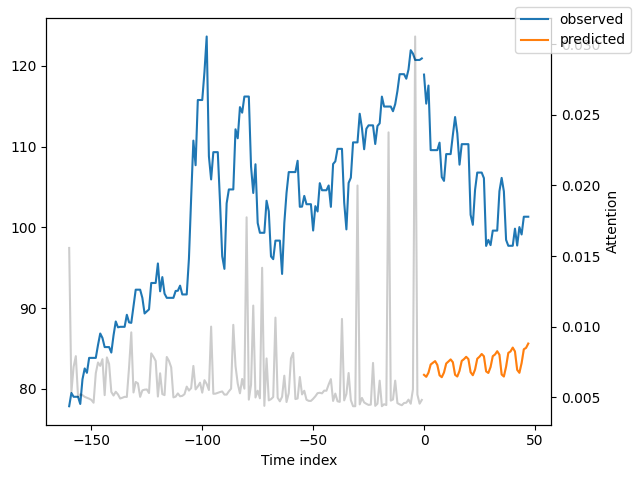

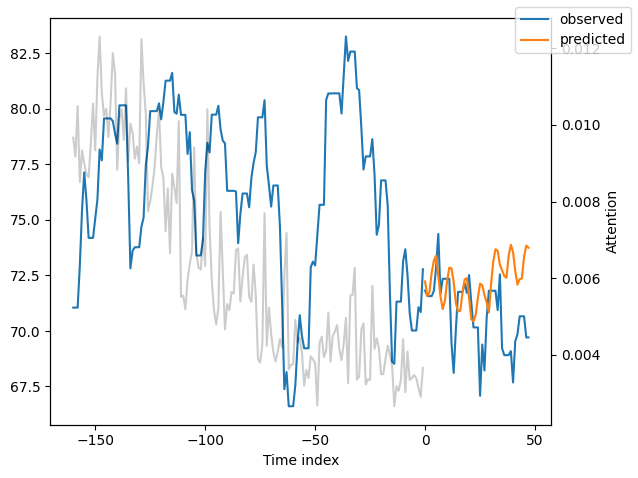

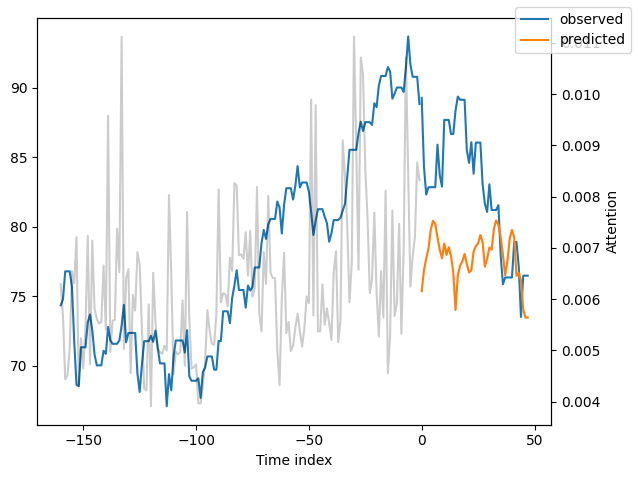

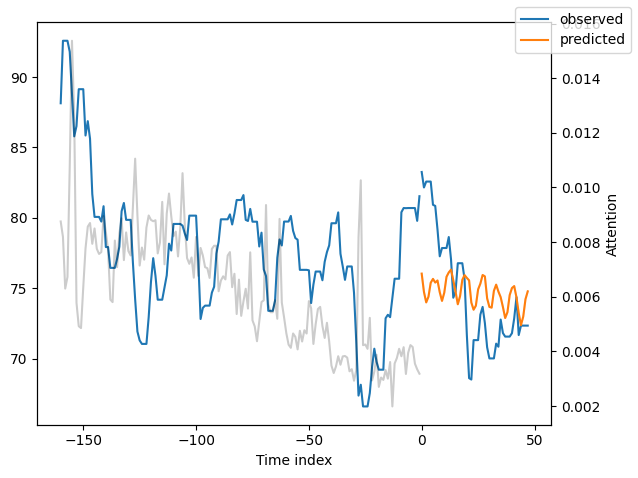

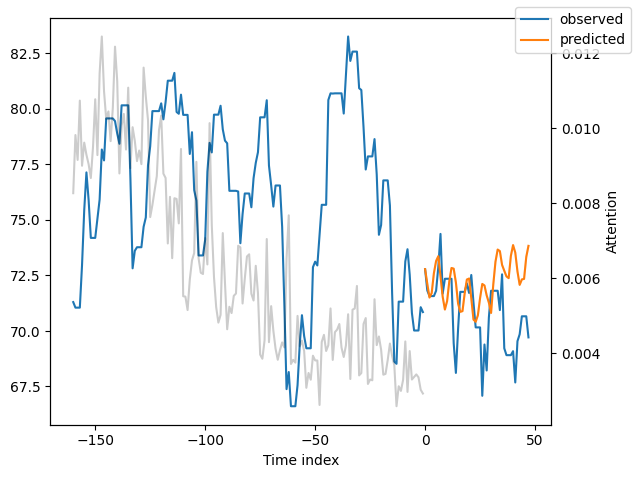

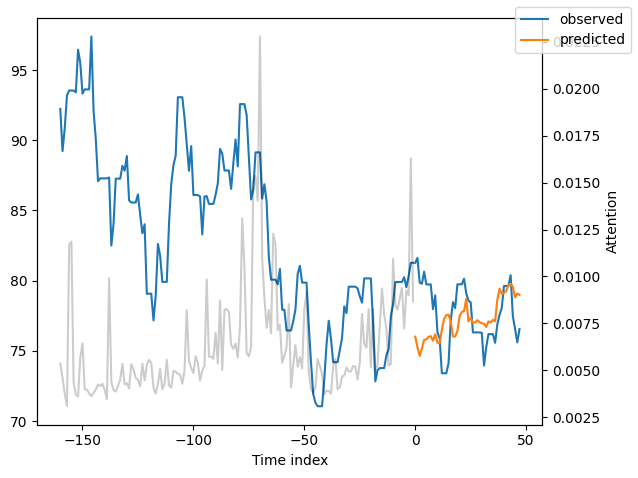

In [316]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape

new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 400, 50):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

In [317]:
test_windows = get_test_windows(con, HPs['max_encoder_length'], 48)
len(test_windows)
#a, b, c, d = get_total_loss(tft, test_windows, train, training_dataset, 192+48)

68

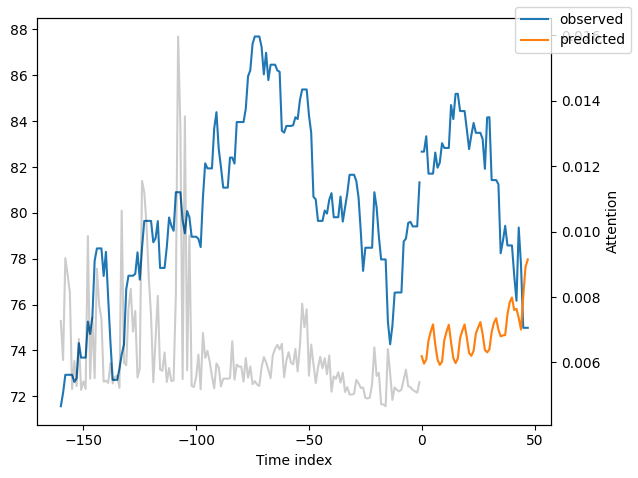

Plot for Window 0


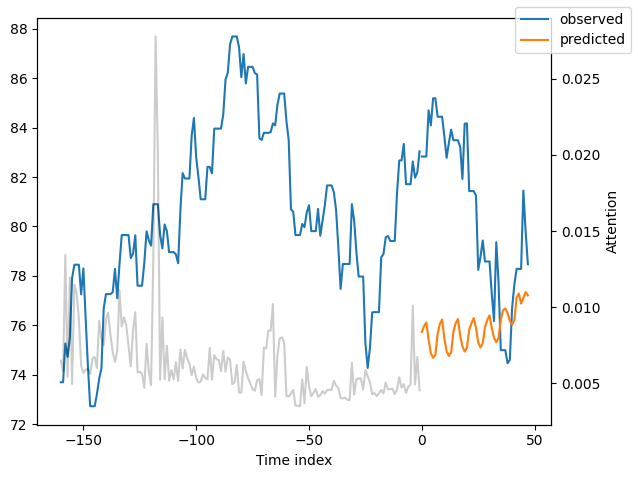

Plot for Window 10


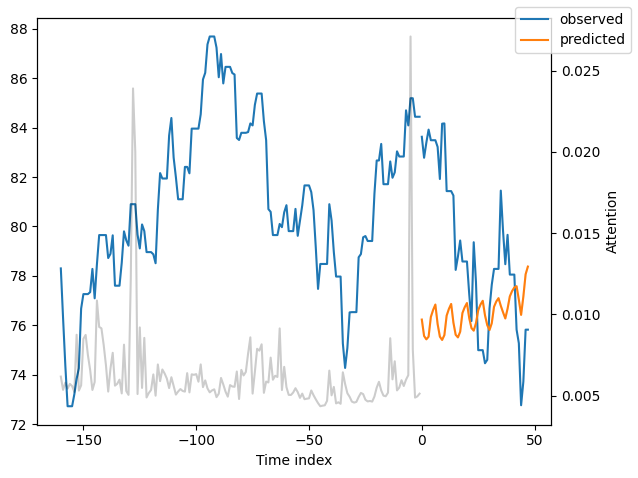

Plot for Window 20


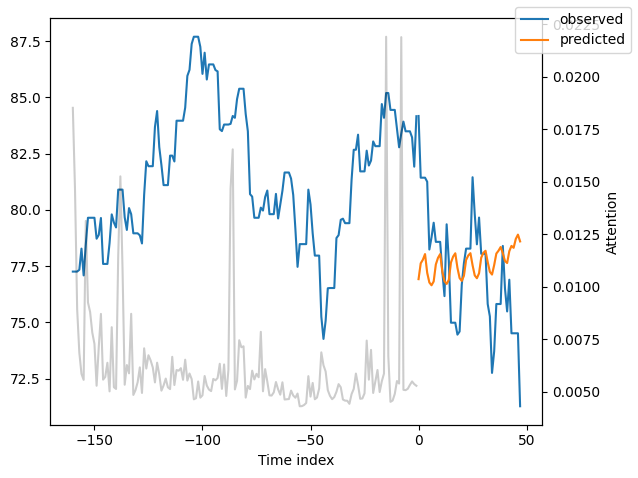

Plot for Window 30


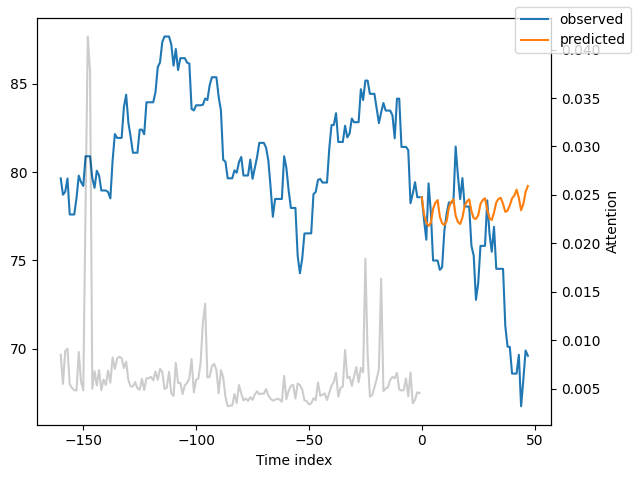

Plot for Window 40


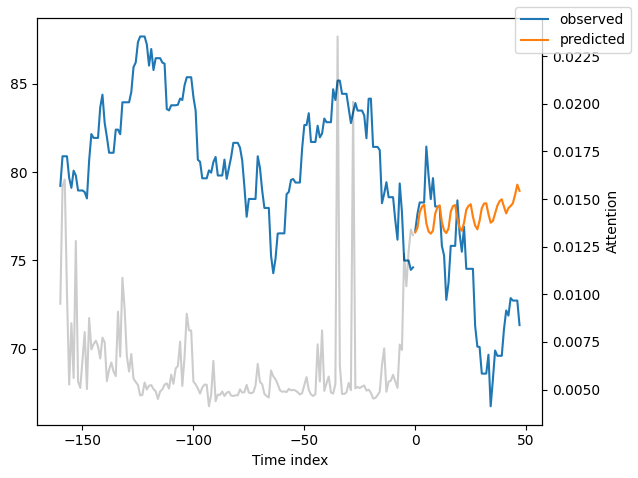

Plot for Window 50


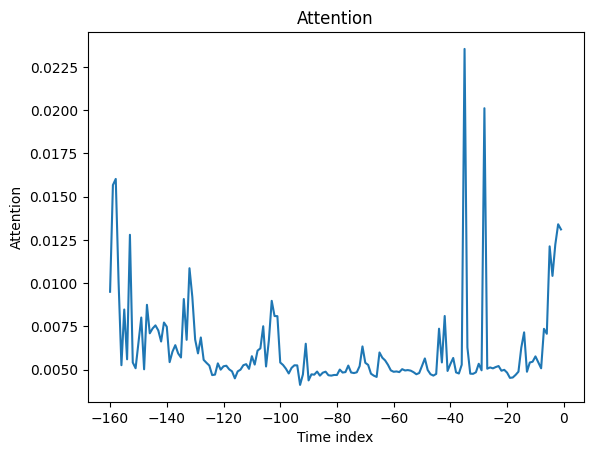

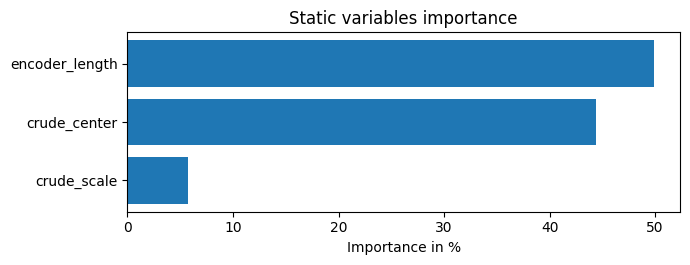

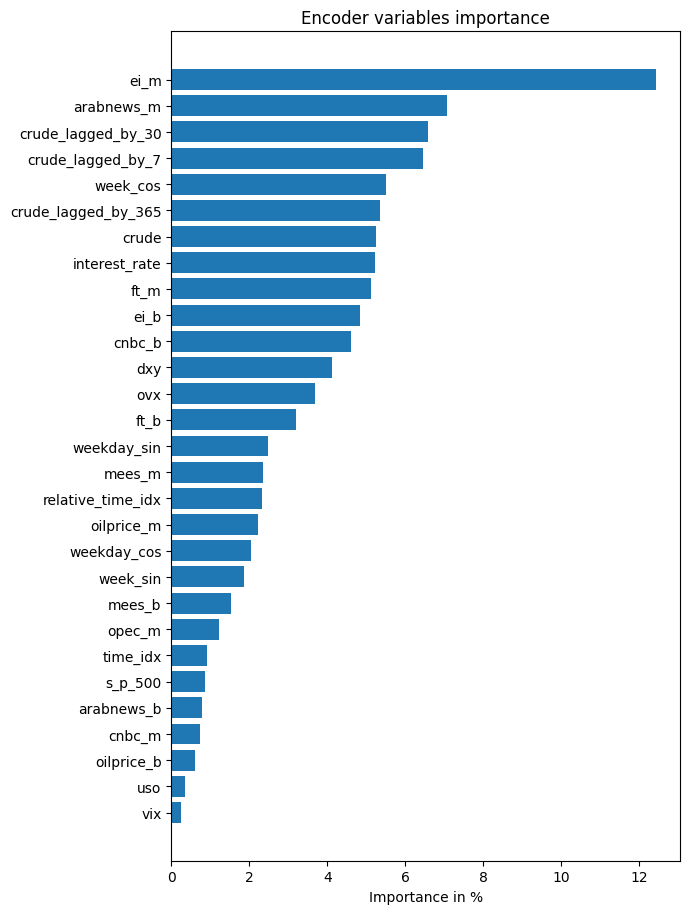

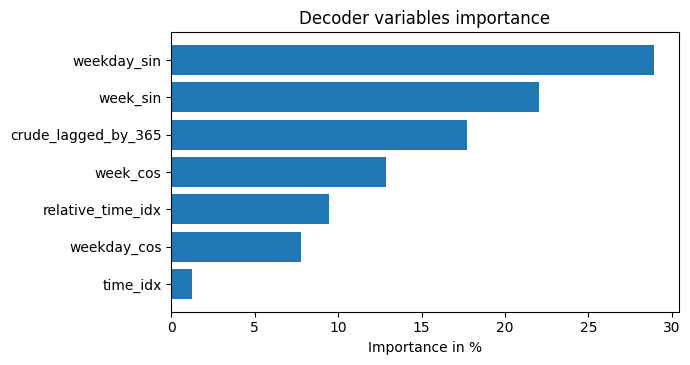

In [318]:
get_all_plots(0, 60, 10, tft, test_windows, train, training_dataset, HPs['max_encoder_length']+48 )

83

In [44]:
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        con, 
                                        predict=True, 
                                        stop_randomization=True)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

AssertionError: data index has to be unique

In [ ]:
mape, smape, mae, rmse = get_total_loss(tft, val_windows, train, training_dataset, 112)



In [ ]:

mape, smape, mae, rmse = get_total_loss(tft, tests, train, training_dataset, 112)


In [ ]:
get_all_plots(0, 26, 5, tft, val_windows, train, training_dataset, 112)

# MISC

In [154]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(6.9737, device='cuda:0')

In [156]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(6.9737, device='cuda:0')

In [130]:
one.time_idx

0          0
1          1
2          2
3          3
4          4
        ... 
1160    1160
1161    1161
1162    1162
1163    1163
1164    1164
Name: time_idx, Length: 1165, dtype: int64

In [132]:
one.time_idx

0          0
1          1
2          2
3          3
4          4
        ... 
1160    1160
1161    1161
1162    1162
1163    1163
1164    1164
Name: time_idx, Length: 1165, dtype: int64

In [137]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(4.7324, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


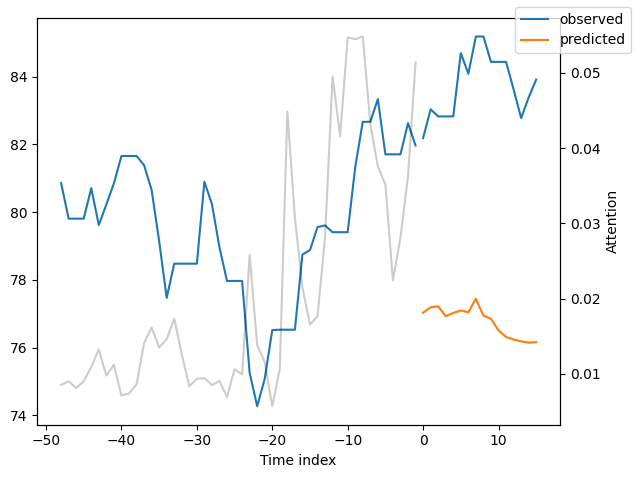

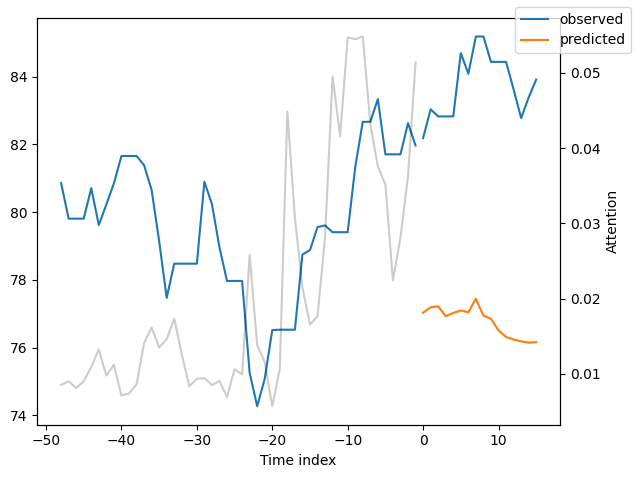

In [157]:
new_raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x925 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

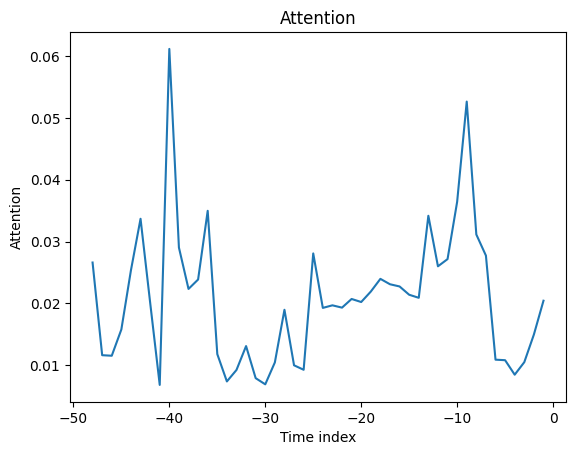

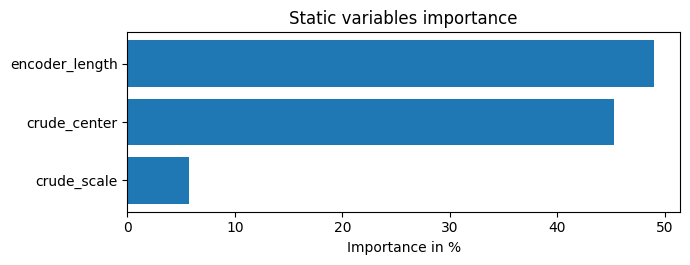

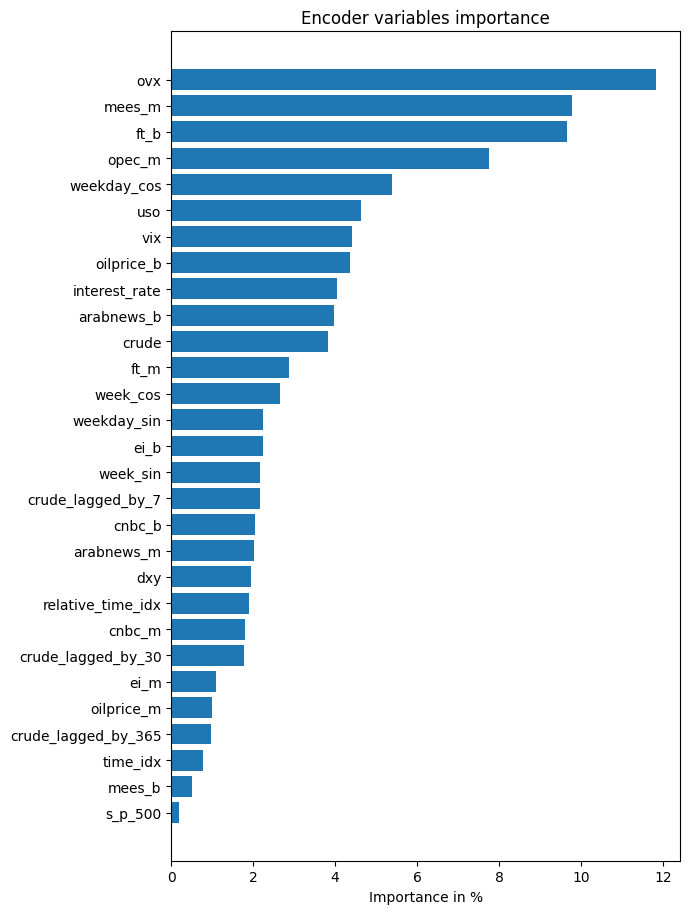

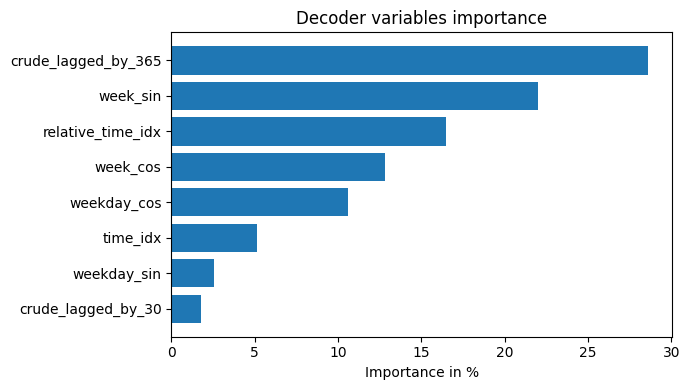

In [158]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [119]:
new_raw_predictions.x['encoder_target']

tensor([[81.9400, 81.9400, 81.9400, 83.6800, 84.3900, 82.7900, 81.9900, 81.1000,
         81.1000, 81.1000, 82.4100, 82.4100, 82.1500, 83.9600, 83.9600, 83.9600,
         83.9600, 84.5400, 85.9500, 86.2200, 87.3700, 87.6900, 87.6900, 87.6900,
         87.2400, 86.0400, 86.9800, 85.7900, 86.4600, 86.4600, 86.4600, 86.2100,
         86.1500, 83.5800, 83.5000, 83.7900, 83.7900, 83.7900, 83.8200, 84.1700,
         84.0900, 84.9200, 85.3800, 85.3800, 85.3800, 84.2600, 83.4900, 80.7000]],
       device='cuda:0')

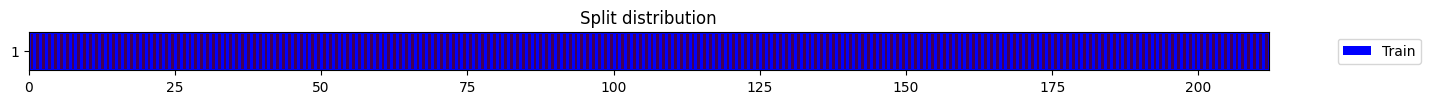

((#212) [0,1,2,3,4,5,6,7,8,9...],)

In [181]:
datetime_col = 'index'
fcst_history = 48 # # steps in the past
fcst_horizon = 16  # # steps in the future
test_size = 0
splits = get_forecasting_splits(test, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                 test_size=test_size)
splits


In [178]:
test

index  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0     1101  4783.45           5.33  12.69  36.35  66.56  102.36  71.57   
1     1102  4780.24           5.33  12.44  36.78  67.65  102.29  72.15   
2     1103  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
3     1104  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
4     1105  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
..     ...      ...            ...    ...    ...    ...     ...    ...   
270   1371  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
271   1372  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
272   1373  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
273   1374  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
274   1375  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

     arabnews_m  cnbc_m  ...    mees_b  oilprice_b  weekday_sin  weekday_cos  \
0           0.5     0.5  ...  0.507777    0.000000     0.974928    -0.222521   
1           0.5     0.5  ...  0.507777    0.000000     0.433884    -0.900969   
2           0.5    -0.3  ... -0.635409    0.000000    -0.433884    -0.900969   
3           0.5    -0.3  ... -0.635409    0.000000    -0.974928    -0.222521   
4           0.5    -0.3  ... -0.635409    0.000000    -0.781831     0.623490   
..          ...     ...  ...       ...         ...          ...          ...   
270         0.0     0.0  ...  0.000000   -0.788622    -0.781831     0.623490   
271         0.0     0.5  ...  0.000000    0.000000     0.000000     1.000000   
272         0.0    -0.3  ...  0.000000    0.000000     0.781831     0.623490   
273         0.0     0.3  ...  0.000000    0.000000     0.974928    -0.222521   
274         0.0    -0.3  ...  0.000000    0.000000     0.433884    -0.900969   

     week_sin  week_cos  month_sin  month_cos  time_idx  constant  
0    0.239316  0.970942   0.500000   0.866025         0         1  
1    0.239316  0.970942   0.500000   0.866025         1         1  
2    0.239316  0.970942   0.500000   0.866025         2         1  
3    0.239316  0.970942   0.500000   0.866025         3         1  
4    0.239316  0.970942   0.500000   0.866025         4         1  
..        ...       ...        ...        ...       ...       ...  
270 -0.992709  0.120537  -0.866025   0.500000       270         1  
271 -0.970942  0.239316  -0.866025   0.500000       271         1  
272 -0.970942  0.239316  -0.866025   0.500000       272         1  
273 -0.970942  0.239316  -0.866025   0.500000       273         1  
274 -0.970942  0.239316  -0.866025   0.500000       274         1  

[275 rows x 29 columns]

In [245]:
test_dataloader

In [655]:
test_preds = tft.predict(test_dataloader, return_x=True)
test_preds.x['encoder_cont'].shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


torch.Size([1, 48, 32])

In [439]:
test_preds.y

(tensor([[79.8000, 79.4400, 79.2200, 80.9000, 80.9000, 80.9000, 79.6700, 79.1100,
          80.0800, 79.8100, 78.9600, 78.9600, 78.9600, 78.8700, 78.5100, 80.6700]],
        device='cuda:0'),
 None)

In [440]:
test[['crude']].iloc[-1]

crude    80.85
Name: 1164, dtype: float64

In [169]:
test_preds.output

Output(prediction=tensor([[[73.3783],
         [74.1104],
         [74.6518],
         [74.3036],
         [74.9997],
         [74.9527],
         [74.9613],
         [74.9330],
         [74.8693],
         [74.8555],
         [74.9176],
         [74.9193],
         [74.8611],
         [74.8594],
         [74.8491],
         [74.8025]]], device='cuda:0'), encoder_attention=tensor([[[[2.1063e-02, 1.9097e-02, 1.8591e-02,  ..., 1.9546e-02,
           1.9840e-02, 1.8457e-02],
          [2.0236e-02, 2.3074e-02, 2.1707e-02,  ..., 2.1185e-02,
           1.9858e-02, 2.1430e-02],
          [2.1603e-02, 2.2817e-02, 2.4871e-02,  ..., 2.2304e-02,
           2.0575e-02, 2.1753e-02],
          [1.3108e-02, 9.2318e-03, 8.9675e-03,  ..., 1.3883e-02,
           2.0501e-02, 1.3632e-02]],

         [[2.0523e-02, 1.9039e-02, 1.8788e-02,  ..., 1.9991e-02,
           2.0455e-02, 1.9434e-02],
          [2.0632e-02, 2.4168e-02, 2.2784e-02,  ..., 2.0751e-02,
           1.8937e-02, 2.1082e-02],
          [2.157

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


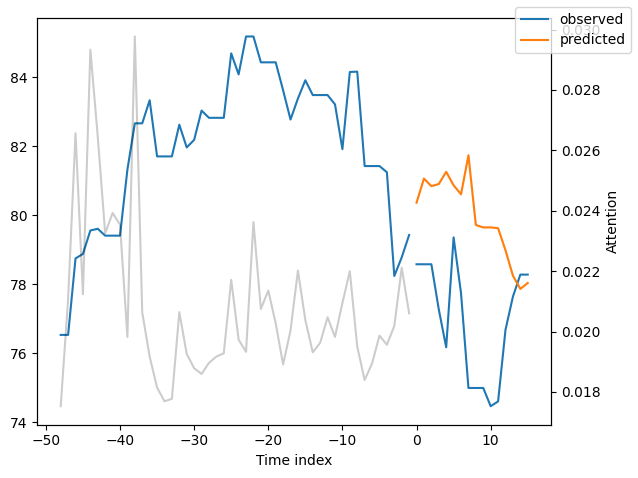

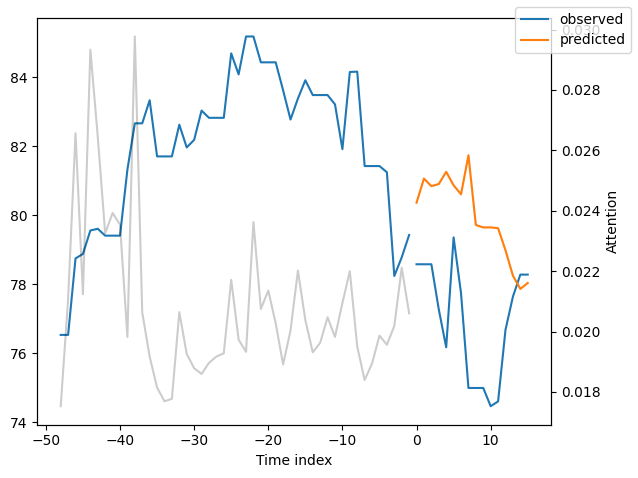

In [677]:
new_raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [37]:
test_dataset

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='crude',
	group_ids=['constant'],
	weight=None,
	max_encoder_length=48,
	min_encoder_length=48,
	min_prediction_idx=0,
	min_prediction_length=16,
	max_prediction_length=16,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['time_idx', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m', 'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b', 'oilprice_b'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags={'crude': [7, 30, 365]},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	meth

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x925 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

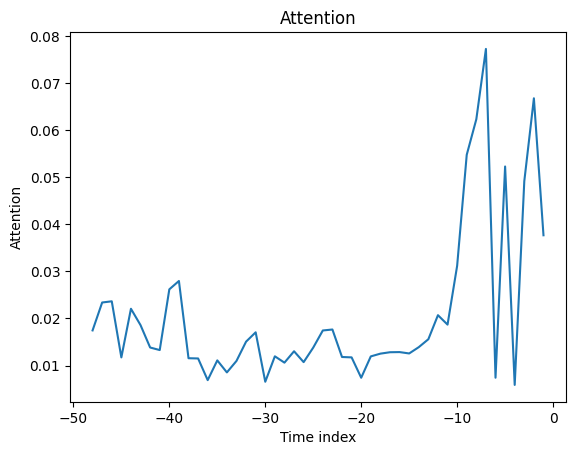

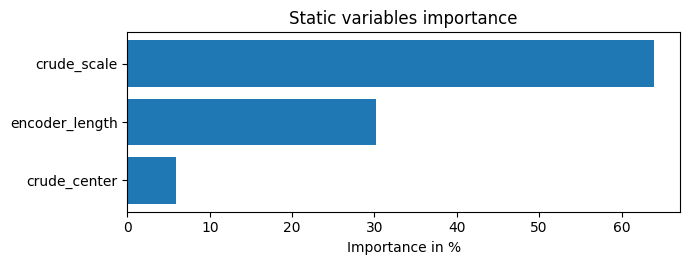

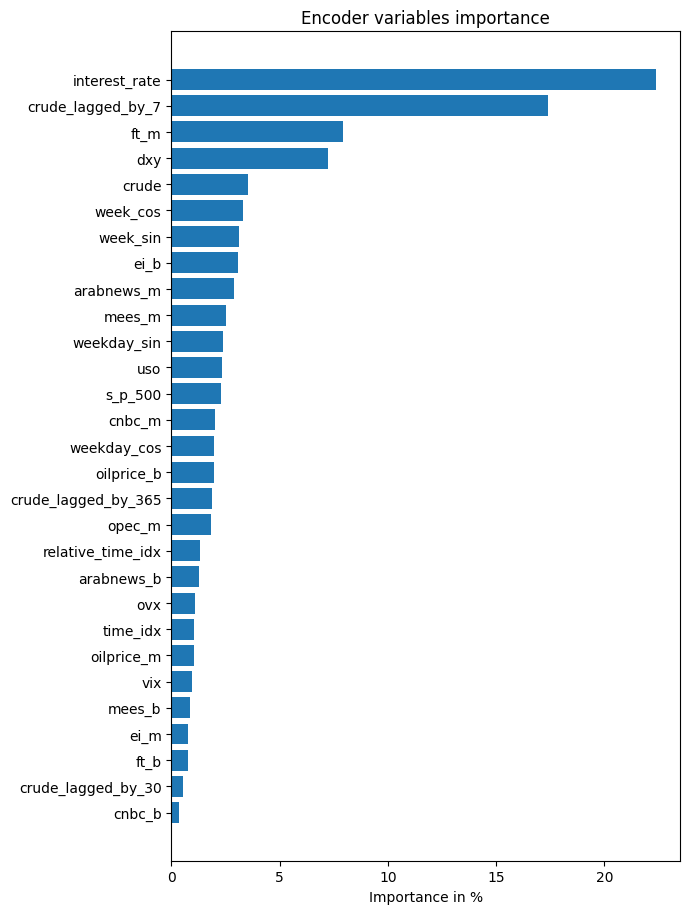

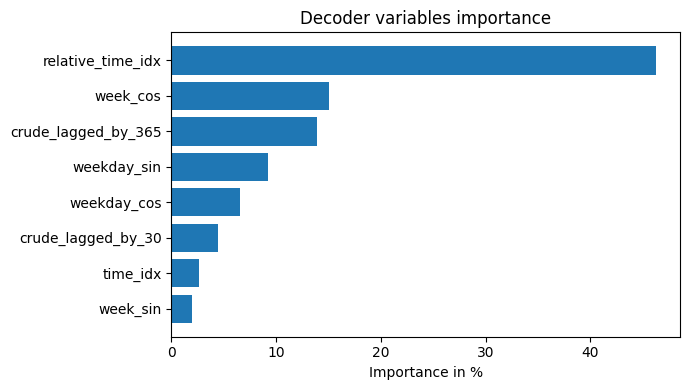

In [678]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [151]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=4,
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder = False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2024-11-25 00:43:56,867] A new study created in memory with name: no-name-3b9a2ce5-de8f-45b4-bdf5-35a958500fc6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=4` reached.
[I 2024-11-25 00:44:02,571] Trial 0 finished with value: 0.09407633543014526 and parameters: {'gradient_clip_val': 0.26018679204303763, 'hidden_size': 43, 'dropout': 0.16092719697370744, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.026488058745987336}. Best is trial 0 with value: 0.09407633543014526.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=4` reached.
[I 2024-11-25 00:44:08,328] Tria

{'gradient_clip_val': 0.5265323531175049, 'hidden_size': 25, 'dropout': 0.25271711318725854, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.002743886795577542}


In [152]:
print(study.best_trial.params)

{'gradient_clip_val': 0.5265323531175049, 'hidden_size': 25, 'dropout': 0.25271711318725854, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.002743886795577542}


In [28]:
os.getcwd()

'/scratch/us2055/Oil_Price/Notebooks'

In [156]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("optuna_test/trial_65/epoch=3.ckpt")


In [157]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(0.1025)

In [158]:
predictions = best_tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(0.2218)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


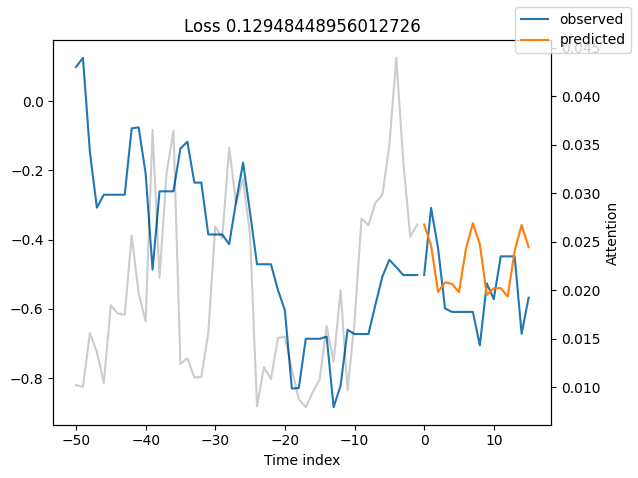

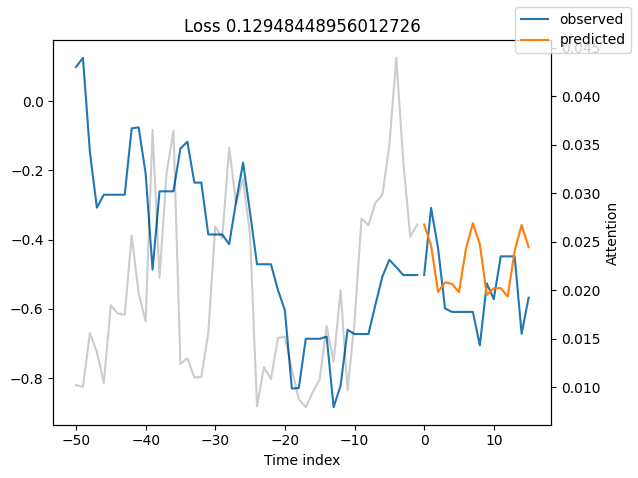

In [159]:
  # plot 10 examples
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


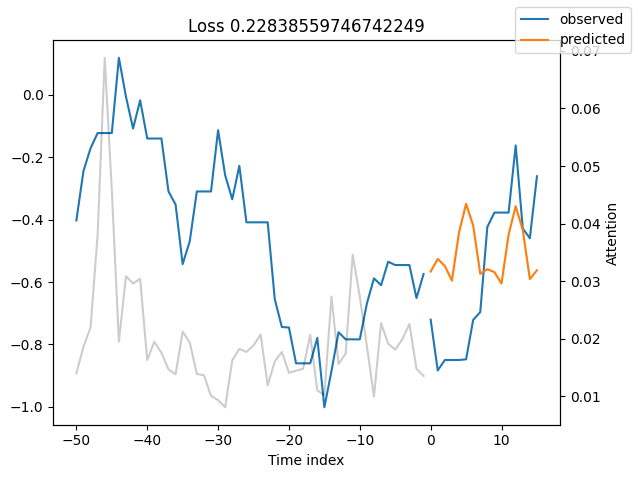

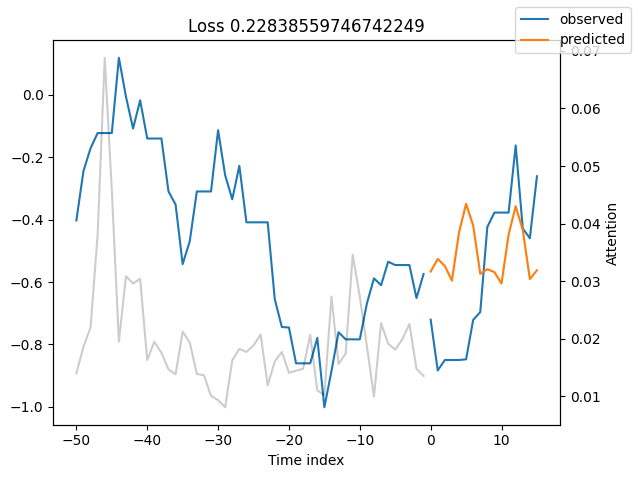

In [161]:
  # plot 10 examples
raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (324938846.py, line 1)